<a href="https://colab.research.google.com/github/WeiKuoLi/single_variable_dnn/blob/main/q4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [35]:
!mkdir /root/.kaggle
!cp kaggle.json /root/.kaggle/
!kaggle competitions download -c ml2022spring-hw1
!ls /root

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.8/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.8/dist-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [36]:
#!unzip *.zip

In [37]:
 # Numerical Operations
import math
import numpy as np

# Reading/Writing Data
import pandas as pd
import os
import csv

# For Progress Bar
from tqdm import tqdm

# Pytorch
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

# For plotting learning curve
from torch.utils.tensorboard import SummaryWriter

In [38]:
import random
my_x=np.arange(-1,1,0.002)
my_y=np.arange(-1,1,0.002)
for i in range(my_y.shape[0]):
  my_y[i]=((math.sin(.4+7*my_x[i]))+.4)*(math.cos(.4+16*my_x[i]))+random.randint(-20,20)/50.0
sampx=pd.DataFrame(my_x,columns=['x'])
sampy=pd.DataFrame(my_y,columns=['y'])
samp=pd.concat([sampx,sampy],axis=1).iloc[: , :]
print(samp.head())
samp.to_csv('sample.csv') 

       x         y
0 -1.000  0.112056
1 -0.998  0.059203
2 -0.996 -0.353485
3 -0.994 -0.085965
4 -0.992  0.021806


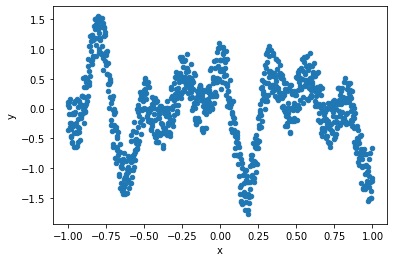

       x         y
0 -1.000  0.112056
1 -0.998  0.059203
2 -0.996 -0.353485
3 -0.994 -0.085965
4 -0.992  0.021806


In [39]:
tmp = pd.read_csv('sample.csv').iloc[: , 1:]
  
import matplotlib.pyplot as plt
tmp.plot(kind='scatter',x="x",y="y") # bar can be replaced by 
# scatter or line or even left as default
plt.show()
print(tmp.head())
my_x=np.arange(-1,1,0.01)

df_test = pd.DataFrame(my_x, columns = ['x' ])
df_test.to_csv('test.csv')

In [40]:
def same_seed(seed): 
    '''Fixes random number generator seeds for reproducibility.'''
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def train_valid_split(data_set, valid_ratio, seed):
    '''Split provided training data into training set and validation set'''
    valid_set_size = int(valid_ratio * len(data_set)) 
    train_set_size = len(data_set) - valid_set_size
    train_set, valid_set = random_split(data_set, [train_set_size, valid_set_size], generator=torch.Generator().manual_seed(seed))
    return np.array(train_set), np.array(valid_set)

def predict(test_loader, model, device):
    model.eval() # Set your model to evaluation mode.
    preds = []
    for x in tqdm(test_loader):
        x = x.to(device)                        
        with torch.no_grad():                   
            pred = model(x)                     
            preds.append(pred.detach().cpu())   
    preds = torch.cat(preds, dim=0).numpy()  
    return preds

In [41]:
class My_Dataset(Dataset):
    '''
    x: Features.
    y: Targets, if none, do prediction.
    '''
    def __init__(self, x, y=None):
        if y is None:
            self.y = y
        else:
            self.y = torch.FloatTensor(y)
        self.x = torch.FloatTensor(x)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

In [33]:
class My_Model(nn.Module):
    def __init__(self, input_dim):
        super(My_Model, self).__init__()
        # TODO: modify model's structure, be aware of dimensions. 
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 80),
            nn.ReLU(),
            nn.Linear(80, 10),
            nn.ReLU(), 
            nn.Linear(10, 1)
        )

    def forward(self, x):
        x = self.layers(x)
        x = x.squeeze(1) # (B, 1) -> (B)
        return x

In [42]:
def select_feat(train_data, valid_data, test_data, select_all=True):
    '''Selects useful features to perform regression'''
    y_train, y_valid = train_data[:,-1], valid_data[:,-1]
    raw_x_train, raw_x_valid, raw_x_test = train_data[:,:-1], valid_data[:,:-1], test_data

    if select_all:
        feat_idx = list(range(raw_x_train.shape[1]))
    else:
        feat_idx = [0] # TODO: Select suitable feature columns.
        
    print(feat_idx)
    return raw_x_train[:,feat_idx], raw_x_valid[:,feat_idx], raw_x_test[:,feat_idx], y_train, y_valid


In [43]:
def trainer(train_loader, valid_loader, model, config, device):

    criterion = nn.MSELoss(reduction='mean') # Define your loss function, do not modify this.

    # Define your optimization algorithm. 
    # TODO: Please check https://pytorch.org/docs/stable/optim.html to get more available algorithms.
    # TODO: L2 regularization (optimizer(weight decay...) or implement by your self).
    #optimizer = torch.optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=0.9) 
    optimizer = torch.optim.Adam(model.parameters())
    #optimizer = torch.optim.Adam(model.parameters(),lr=0.0007,weight_decay=0.03)
    writer = SummaryWriter() # Writer of tensoboard.
    if not os.path.isdir('./models'):
        os.mkdir('./models') # Create directory of saving models.

    n_epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0

    for epoch in range(n_epochs):
        model.train() # Set your model to train mode.
        loss_record = []

        # tqdm is a package to visualize your training progress.
        train_pbar = tqdm(train_loader, position=0, leave=True)

        for x, y in train_pbar:
            optimizer.zero_grad()               # Set gradient to zero.
            x, y = x.to(device), y.to(device)   # Move your data to device. 
            pred = model(x)             
            loss = criterion(pred, y)
            loss.backward()                     # Compute gradient(backpropagation).
            optimizer.step()                    # Update parameters.
            step += 1
            loss_record.append(loss.detach().item())
            
            # Display current epoch number and loss on tqdm progress bar.
            train_pbar.set_description(f'Epoch [{epoch+1}/{n_epochs}]')
            train_pbar.set_postfix({'loss': loss.detach().item()})

        mean_train_loss = sum(loss_record)/len(loss_record)
        writer.add_scalar('Loss/train', mean_train_loss, step)

        model.eval() # Set your model to evaluation mode.
        loss_record = []
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                loss = criterion(pred, y)

            loss_record.append(loss.item())
            
        mean_valid_loss = sum(loss_record)/len(loss_record)
        print(f'Epoch [{epoch+1}/{n_epochs}]: Train loss: {mean_train_loss:.4f}, Valid loss: {mean_valid_loss:.4f}')
        writer.add_scalar('Loss/valid', mean_valid_loss, step)

        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            torch.save(model.state_dict(), config['save_path']) # Save your best model
            print('Saving model with loss {:.3f}...'.format(best_loss))
            early_stop_count = 0
        else: 
            early_stop_count += 1

        if early_stop_count >= config['early_stop']:
            print('\nModel is not improving, so we halt the training session.')
            return

In [44]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = {
    'seed': 5201314,      # Your seed number, you can pick your lucky number. :)
    'select_all': True,   # Whether to use all features.
    'valid_ratio': 0.2,   # validation_size = train_size * valid_ratio
    'n_epochs': 3000,     # Number of epochs.            
    'batch_size': 256, 
    'learning_rate': 1e-3,              
    'early_stop': 40,    # If model has not improved for this many consecutive epochs, stop training.     
    'save_path': './models/model.ckpt'  # Your model will be saved here.
}

In [45]:
!mkdir models
!ls

mkdir: cannot create directory ‘models’: File exists
models		       runs	   sample_data	   test.csv
quant_test_matrix.csv  sample.csv  submission.csv


In [46]:
# Set seed for reproducibility
same_seed(config['seed'])


# train_data size: 2699 x 118 (id + 37 states + 16 features x 5 days) 
# test_data size: 1078 x 117 (without last day's positive rate)
train_data, test_data = pd.read_csv('sample.csv').iloc[: , 1:].values, pd.read_csv('test.csv').iloc[: , 1:].values
print(pd.read_csv('./sample.csv').iloc[: , 1:] .head( ))
train_data, valid_data = train_valid_split(train_data, config['valid_ratio'], config['seed'])

# Print out the data size.
print(f"""train_data size: {train_data.shape} 
valid_data size: {valid_data.shape} 
test_data size: {test_data.shape}""")
 

#print(test_data)

# Select features
x_train, x_valid, x_test, y_train, y_valid = select_feat(train_data, valid_data, test_data, config['select_all'])

# Print out the number of features.
print(f'number of features: {x_train.shape[1]}')

train_dataset, valid_dataset, test_dataset = My_Dataset(x_train, y_train), \
                                            My_Dataset(x_valid, y_valid), \
                                            My_Dataset(x_test)

# Pytorch data loader loads pytorch dataset into batches.
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, pin_memory=True)

       x         y
0 -1.000  0.112056
1 -0.998  0.059203
2 -0.996 -0.353485
3 -0.994 -0.085965
4 -0.992  0.021806
train_data size: (800, 2) 
valid_data size: (200, 2) 
test_data size: (200, 1)
[0]
number of features: 1


In [47]:
 
train_data

array([[-0.552     , -0.39166239],
       [ 0.558     ,  0.37612774],
       [ 0.462     ,  0.39549381],
       ...,
       [-0.836     ,  0.86452187],
       [-0.876     ,  0.47990198],
       [ 0.526     ,  0.51453629]])

In [48]:
model = My_Model(input_dim=x_train.shape[1]).to(device) # put your model and data on the same computation device.
trainer(train_loader, valid_loader, model, config, device)

Epoch [1/3000]: 100%|██████████| 4/4 [00:00<00:00, 94.53it/s, loss=0.306]


Epoch [1/3000]: Train loss: 0.3862, Valid loss: 0.4483
Saving model with loss 0.448...


Epoch [2/3000]: 100%|██████████| 4/4 [00:00<00:00, 109.98it/s, loss=0.404]


Epoch [2/3000]: Train loss: 0.3951, Valid loss: 0.4309
Saving model with loss 0.431...


Epoch [3/3000]: 100%|██████████| 4/4 [00:00<00:00, 114.36it/s, loss=0.417]


Epoch [3/3000]: Train loss: 0.3958, Valid loss: 0.4239
Saving model with loss 0.424...


Epoch [4/3000]: 100%|██████████| 4/4 [00:00<00:00, 112.13it/s, loss=0.291]


Epoch [4/3000]: Train loss: 0.3685, Valid loss: 0.4237
Saving model with loss 0.424...


Epoch [5/3000]: 100%|██████████| 4/4 [00:00<00:00, 119.54it/s, loss=0.291]


Epoch [5/3000]: Train loss: 0.3671, Valid loss: 0.4281


Epoch [6/3000]: 100%|██████████| 4/4 [00:00<00:00, 114.35it/s, loss=0.425]


Epoch [6/3000]: Train loss: 0.3947, Valid loss: 0.4341


Epoch [7/3000]: 100%|██████████| 4/4 [00:00<00:00, 112.22it/s, loss=0.365]


Epoch [7/3000]: Train loss: 0.3822, Valid loss: 0.4335


Epoch [8/3000]: 100%|██████████| 4/4 [00:00<00:00, 123.90it/s, loss=0.293]


Epoch [8/3000]: Train loss: 0.3652, Valid loss: 0.4282


Epoch [9/3000]: 100%|██████████| 4/4 [00:00<00:00, 106.83it/s, loss=0.345]


Epoch [9/3000]: Train loss: 0.3758, Valid loss: 0.4241


Epoch [10/3000]: 100%|██████████| 4/4 [00:00<00:00, 125.55it/s, loss=0.249]


Epoch [10/3000]: Train loss: 0.3542, Valid loss: 0.4241


Epoch [11/3000]: 100%|██████████| 4/4 [00:00<00:00, 111.34it/s, loss=0.344]


Epoch [11/3000]: Train loss: 0.3746, Valid loss: 0.4286


Epoch [12/3000]: 100%|██████████| 4/4 [00:00<00:00, 106.08it/s, loss=0.442]


Epoch [12/3000]: Train loss: 0.3957, Valid loss: 0.4307


Epoch [13/3000]: 100%|██████████| 4/4 [00:00<00:00, 90.85it/s, loss=0.308]


Epoch [13/3000]: Train loss: 0.3662, Valid loss: 0.4302


Epoch [14/3000]: 100%|██████████| 4/4 [00:00<00:00, 109.26it/s, loss=0.322]


Epoch [14/3000]: Train loss: 0.3686, Valid loss: 0.4276


Epoch [15/3000]: 100%|██████████| 4/4 [00:00<00:00, 111.92it/s, loss=0.389]


Epoch [15/3000]: Train loss: 0.3826, Valid loss: 0.4263


Epoch [16/3000]: 100%|██████████| 4/4 [00:00<00:00, 106.38it/s, loss=0.374]


Epoch [16/3000]: Train loss: 0.3787, Valid loss: 0.4235
Saving model with loss 0.423...


Epoch [17/3000]: 100%|██████████| 4/4 [00:00<00:00, 104.35it/s, loss=0.414]


Epoch [17/3000]: Train loss: 0.3872, Valid loss: 0.4215
Saving model with loss 0.422...


Epoch [18/3000]: 100%|██████████| 4/4 [00:00<00:00, 110.20it/s, loss=0.281]


Epoch [18/3000]: Train loss: 0.3571, Valid loss: 0.4203
Saving model with loss 0.420...


Epoch [19/3000]: 100%|██████████| 4/4 [00:00<00:00, 115.54it/s, loss=0.463]


Epoch [19/3000]: Train loss: 0.3967, Valid loss: 0.4200
Saving model with loss 0.420...


Epoch [20/3000]: 100%|██████████| 4/4 [00:00<00:00, 117.73it/s, loss=0.281]


Epoch [20/3000]: Train loss: 0.3566, Valid loss: 0.4195
Saving model with loss 0.420...


Epoch [21/3000]: 100%|██████████| 4/4 [00:00<00:00, 104.45it/s, loss=0.344]


Epoch [21/3000]: Train loss: 0.3697, Valid loss: 0.4207


Epoch [22/3000]: 100%|██████████| 4/4 [00:00<00:00, 101.67it/s, loss=0.399]


Epoch [22/3000]: Train loss: 0.3807, Valid loss: 0.4200


Epoch [23/3000]: 100%|██████████| 4/4 [00:00<00:00, 99.26it/s, loss=0.4]


Epoch [23/3000]: Train loss: 0.3806, Valid loss: 0.4196


Epoch [24/3000]: 100%|██████████| 4/4 [00:00<00:00, 99.39it/s, loss=0.301]


Epoch [24/3000]: Train loss: 0.3582, Valid loss: 0.4198


Epoch [25/3000]: 100%|██████████| 4/4 [00:00<00:00, 106.05it/s, loss=0.479]


Epoch [25/3000]: Train loss: 0.3964, Valid loss: 0.4211


Epoch [26/3000]: 100%|██████████| 4/4 [00:00<00:00, 98.78it/s, loss=0.329]


Epoch [26/3000]: Train loss: 0.3633, Valid loss: 0.4200


Epoch [27/3000]: 100%|██████████| 4/4 [00:00<00:00, 91.33it/s, loss=0.359]


Epoch [27/3000]: Train loss: 0.3690, Valid loss: 0.4180
Saving model with loss 0.418...


Epoch [28/3000]: 100%|██████████| 4/4 [00:00<00:00, 107.50it/s, loss=0.291]


Epoch [28/3000]: Train loss: 0.3535, Valid loss: 0.4160
Saving model with loss 0.416...


Epoch [29/3000]: 100%|██████████| 4/4 [00:00<00:00, 90.18it/s, loss=0.231]


Epoch [29/3000]: Train loss: 0.3401, Valid loss: 0.4173


Epoch [30/3000]: 100%|██████████| 4/4 [00:00<00:00, 104.06it/s, loss=0.354]


Epoch [30/3000]: Train loss: 0.3663, Valid loss: 0.4171


Epoch [31/3000]: 100%|██████████| 4/4 [00:00<00:00, 105.30it/s, loss=0.472]


Epoch [31/3000]: Train loss: 0.3915, Valid loss: 0.4174


Epoch [32/3000]: 100%|██████████| 4/4 [00:00<00:00, 101.26it/s, loss=0.443]


Epoch [32/3000]: Train loss: 0.3843, Valid loss: 0.4139
Saving model with loss 0.414...


Epoch [33/3000]: 100%|██████████| 4/4 [00:00<00:00, 98.13it/s, loss=0.418]

Epoch [33/3000]: Train loss: 0.3784, Valid loss: 0.4090


Saving model with loss 0.409...


Epoch [34/3000]: 100%|██████████| 4/4 [00:00<00:00, 116.89it/s, loss=0.277]


Epoch [34/3000]: Train loss: 0.3474, Valid loss: 0.4083
Saving model with loss 0.408...


Epoch [35/3000]: 100%|██████████| 4/4 [00:00<00:00, 111.23it/s, loss=0.369]


Epoch [35/3000]: Train loss: 0.3676, Valid loss: 0.4091


Epoch [36/3000]: 100%|██████████| 4/4 [00:00<00:00, 114.04it/s, loss=0.403]


Epoch [36/3000]: Train loss: 0.3739, Valid loss: 0.4083
Saving model with loss 0.408...


Epoch [37/3000]: 100%|██████████| 4/4 [00:00<00:00, 99.23it/s, loss=0.345]


Epoch [37/3000]: Train loss: 0.3602, Valid loss: 0.4059
Saving model with loss 0.406...


Epoch [38/3000]: 100%|██████████| 4/4 [00:00<00:00, 115.53it/s, loss=0.468]


Epoch [38/3000]: Train loss: 0.3866, Valid loss: 0.4056
Saving model with loss 0.406...


Epoch [39/3000]: 100%|██████████| 4/4 [00:00<00:00, 109.26it/s, loss=0.323]


Epoch [39/3000]: Train loss: 0.3538, Valid loss: 0.4070


Epoch [40/3000]: 100%|██████████| 4/4 [00:00<00:00, 109.17it/s, loss=0.38]


Epoch [40/3000]: Train loss: 0.3657, Valid loss: 0.4063


Epoch [41/3000]: 100%|██████████| 4/4 [00:00<00:00, 124.16it/s, loss=0.396]


Epoch [41/3000]: Train loss: 0.3686, Valid loss: 0.4060


Epoch [42/3000]: 100%|██████████| 4/4 [00:00<00:00, 86.03it/s, loss=0.25]


Epoch [42/3000]: Train loss: 0.3355, Valid loss: 0.4055
Saving model with loss 0.405...


Epoch [43/3000]: 100%|██████████| 4/4 [00:00<00:00, 105.73it/s, loss=0.316]

Epoch [43/3000]: Train loss: 0.3495, Valid loss: 0.4053


Saving model with loss 0.405...


Epoch [44/3000]: 100%|██████████| 4/4 [00:00<00:00, 114.33it/s, loss=0.252]


Epoch [44/3000]: Train loss: 0.3350, Valid loss: 0.4061


Epoch [45/3000]: 100%|██████████| 4/4 [00:00<00:00, 93.27it/s, loss=0.306]


Epoch [45/3000]: Train loss: 0.3460, Valid loss: 0.4038
Saving model with loss 0.404...


Epoch [46/3000]: 100%|██████████| 4/4 [00:00<00:00, 105.99it/s, loss=0.32]


Epoch [46/3000]: Train loss: 0.3477, Valid loss: 0.4029
Saving model with loss 0.403...


Epoch [47/3000]: 100%|██████████| 4/4 [00:00<00:00, 91.35it/s, loss=0.578]


Epoch [47/3000]: Train loss: 0.4035, Valid loss: 0.4026
Saving model with loss 0.403...


Epoch [48/3000]: 100%|██████████| 4/4 [00:00<00:00, 120.06it/s, loss=0.274]


Epoch [48/3000]: Train loss: 0.3368, Valid loss: 0.4045


Epoch [49/3000]: 100%|██████████| 4/4 [00:00<00:00, 103.33it/s, loss=0.346]


Epoch [49/3000]: Train loss: 0.3522, Valid loss: 0.4034


Epoch [50/3000]: 100%|██████████| 4/4 [00:00<00:00, 117.51it/s, loss=0.468]


Epoch [50/3000]: Train loss: 0.3778, Valid loss: 0.3970
Saving model with loss 0.397...


Epoch [51/3000]: 100%|██████████| 4/4 [00:00<00:00, 96.58it/s, loss=0.294]


Epoch [51/3000]: Train loss: 0.3405, Valid loss: 0.3922
Saving model with loss 0.392...


Epoch [52/3000]: 100%|██████████| 4/4 [00:00<00:00, 109.60it/s, loss=0.387]


Epoch [52/3000]: Train loss: 0.3619, Valid loss: 0.3925


Epoch [53/3000]: 100%|██████████| 4/4 [00:00<00:00, 113.96it/s, loss=0.396]


Epoch [53/3000]: Train loss: 0.3602, Valid loss: 0.3985


Epoch [54/3000]: 100%|██████████| 4/4 [00:00<00:00, 116.01it/s, loss=0.452]


Epoch [54/3000]: Train loss: 0.3724, Valid loss: 0.4065


Epoch [55/3000]: 100%|██████████| 4/4 [00:00<00:00, 97.14it/s, loss=0.192]


Epoch [55/3000]: Train loss: 0.3151, Valid loss: 0.3995


Epoch [56/3000]: 100%|██████████| 4/4 [00:00<00:00, 117.72it/s, loss=0.45]


Epoch [56/3000]: Train loss: 0.3700, Valid loss: 0.4003


Epoch [57/3000]: 100%|██████████| 4/4 [00:00<00:00, 100.79it/s, loss=0.421]


Epoch [57/3000]: Train loss: 0.3638, Valid loss: 0.3964


Epoch [58/3000]: 100%|██████████| 4/4 [00:00<00:00, 98.20it/s, loss=0.282]


Epoch [58/3000]: Train loss: 0.3319, Valid loss: 0.3904
Saving model with loss 0.390...


Epoch [59/3000]: 100%|██████████| 4/4 [00:00<00:00, 107.65it/s, loss=0.371]


Epoch [59/3000]: Train loss: 0.3502, Valid loss: 0.3890
Saving model with loss 0.389...


Epoch [60/3000]: 100%|██████████| 4/4 [00:00<00:00, 98.13it/s, loss=0.343]


Epoch [60/3000]: Train loss: 0.3436, Valid loss: 0.3882
Saving model with loss 0.388...


Epoch [61/3000]: 100%|██████████| 4/4 [00:00<00:00, 133.22it/s, loss=0.23]


Epoch [61/3000]: Train loss: 0.3179, Valid loss: 0.3925


Epoch [62/3000]: 100%|██████████| 4/4 [00:00<00:00, 102.41it/s, loss=0.305]


Epoch [62/3000]: Train loss: 0.3340, Valid loss: 0.3959


Epoch [63/3000]: 100%|██████████| 4/4 [00:00<00:00, 94.43it/s, loss=0.507]


Epoch [63/3000]: Train loss: 0.3782, Valid loss: 0.3925


Epoch [64/3000]: 100%|██████████| 4/4 [00:00<00:00, 113.29it/s, loss=0.363]


Epoch [64/3000]: Train loss: 0.3455, Valid loss: 0.3855
Saving model with loss 0.385...


Epoch [65/3000]: 100%|██████████| 4/4 [00:00<00:00, 93.88it/s, loss=0.381]


Epoch [65/3000]: Train loss: 0.3491, Valid loss: 0.3837
Saving model with loss 0.384...


Epoch [66/3000]: 100%|██████████| 4/4 [00:00<00:00, 96.24it/s, loss=0.338]


Epoch [66/3000]: Train loss: 0.3384, Valid loss: 0.3874


Epoch [67/3000]: 100%|██████████| 4/4 [00:00<00:00, 85.97it/s, loss=0.262]


Epoch [67/3000]: Train loss: 0.3219, Valid loss: 0.3954


Epoch [68/3000]: 100%|██████████| 4/4 [00:00<00:00, 89.95it/s, loss=0.512]


Epoch [68/3000]: Train loss: 0.3778, Valid loss: 0.3936


Epoch [69/3000]: 100%|██████████| 4/4 [00:00<00:00, 90.24it/s, loss=0.327]


Epoch [69/3000]: Train loss: 0.3362, Valid loss: 0.3859


Epoch [70/3000]: 100%|██████████| 4/4 [00:00<00:00, 107.94it/s, loss=0.362]


Epoch [70/3000]: Train loss: 0.3424, Valid loss: 0.3801
Saving model with loss 0.380...


Epoch [71/3000]: 100%|██████████| 4/4 [00:00<00:00, 103.88it/s, loss=0.437]


Epoch [71/3000]: Train loss: 0.3576, Valid loss: 0.3847


Epoch [72/3000]: 100%|██████████| 4/4 [00:00<00:00, 82.93it/s, loss=0.183]


Epoch [72/3000]: Train loss: 0.3012, Valid loss: 0.3879


Epoch [73/3000]: 100%|██████████| 4/4 [00:00<00:00, 93.78it/s, loss=0.215]


Epoch [73/3000]: Train loss: 0.3082, Valid loss: 0.3924


Epoch [74/3000]: 100%|██████████| 4/4 [00:00<00:00, 90.56it/s, loss=0.501]


Epoch [74/3000]: Train loss: 0.3707, Valid loss: 0.3861


Epoch [75/3000]: 100%|██████████| 4/4 [00:00<00:00, 103.46it/s, loss=0.367]


Epoch [75/3000]: Train loss: 0.3392, Valid loss: 0.3757
Saving model with loss 0.376...


Epoch [76/3000]: 100%|██████████| 4/4 [00:00<00:00, 102.26it/s, loss=0.258]


Epoch [76/3000]: Train loss: 0.3207, Valid loss: 0.3736
Saving model with loss 0.374...


Epoch [77/3000]: 100%|██████████| 4/4 [00:00<00:00, 102.72it/s, loss=0.397]


Epoch [77/3000]: Train loss: 0.3473, Valid loss: 0.3820


Epoch [78/3000]: 100%|██████████| 4/4 [00:00<00:00, 85.88it/s, loss=0.331]


Epoch [78/3000]: Train loss: 0.3303, Valid loss: 0.3927


Epoch [79/3000]: 100%|██████████| 4/4 [00:00<00:00, 124.58it/s, loss=0.358]


Epoch [79/3000]: Train loss: 0.3389, Valid loss: 0.3897


Epoch [80/3000]: 100%|██████████| 4/4 [00:00<00:00, 89.37it/s, loss=0.369]


Epoch [80/3000]: Train loss: 0.3393, Valid loss: 0.3793


Epoch [81/3000]: 100%|██████████| 4/4 [00:00<00:00, 122.46it/s, loss=0.359]


Epoch [81/3000]: Train loss: 0.3352, Valid loss: 0.3765


Epoch [82/3000]: 100%|██████████| 4/4 [00:00<00:00, 111.98it/s, loss=0.318]


Epoch [82/3000]: Train loss: 0.3259, Valid loss: 0.3781


Epoch [83/3000]: 100%|██████████| 4/4 [00:00<00:00, 116.56it/s, loss=0.315]


Epoch [83/3000]: Train loss: 0.3248, Valid loss: 0.3805


Epoch [84/3000]: 100%|██████████| 4/4 [00:00<00:00, 108.47it/s, loss=0.276]


Epoch [84/3000]: Train loss: 0.3158, Valid loss: 0.3757


Epoch [85/3000]: 100%|██████████| 4/4 [00:00<00:00, 113.90it/s, loss=0.249]


Epoch [85/3000]: Train loss: 0.3091, Valid loss: 0.3726
Saving model with loss 0.373...


Epoch [86/3000]: 100%|██████████| 4/4 [00:00<00:00, 123.32it/s, loss=0.392]


Epoch [86/3000]: Train loss: 0.3398, Valid loss: 0.3785


Epoch [87/3000]: 100%|██████████| 4/4 [00:00<00:00, 94.77it/s, loss=0.355]


Epoch [87/3000]: Train loss: 0.3317, Valid loss: 0.3834


Epoch [88/3000]: 100%|██████████| 4/4 [00:00<00:00, 70.19it/s, loss=0.335]


Epoch [88/3000]: Train loss: 0.3270, Valid loss: 0.3776


Epoch [89/3000]: 100%|██████████| 4/4 [00:00<00:00, 118.80it/s, loss=0.256]


Epoch [89/3000]: Train loss: 0.3080, Valid loss: 0.3692
Saving model with loss 0.369...


Epoch [90/3000]: 100%|██████████| 4/4 [00:00<00:00, 121.75it/s, loss=0.518]


Epoch [90/3000]: Train loss: 0.3648, Valid loss: 0.3692


Epoch [91/3000]: 100%|██████████| 4/4 [00:00<00:00, 110.76it/s, loss=0.207]


Epoch [91/3000]: Train loss: 0.2969, Valid loss: 0.3737


Epoch [92/3000]: 100%|██████████| 4/4 [00:00<00:00, 132.70it/s, loss=0.384]


Epoch [92/3000]: Train loss: 0.3347, Valid loss: 0.3705


Epoch [93/3000]: 100%|██████████| 4/4 [00:00<00:00, 122.75it/s, loss=0.568]


Epoch [93/3000]: Train loss: 0.3739, Valid loss: 0.3660
Saving model with loss 0.366...


Epoch [94/3000]: 100%|██████████| 4/4 [00:00<00:00, 86.22it/s, loss=0.387]


Epoch [94/3000]: Train loss: 0.3341, Valid loss: 0.3640
Saving model with loss 0.364...


Epoch [95/3000]: 100%|██████████| 4/4 [00:00<00:00, 125.51it/s, loss=0.419]


Epoch [95/3000]: Train loss: 0.3406, Valid loss: 0.3689


Epoch [96/3000]: 100%|██████████| 4/4 [00:00<00:00, 114.16it/s, loss=0.325]


Epoch [96/3000]: Train loss: 0.3201, Valid loss: 0.3678


Epoch [97/3000]: 100%|██████████| 4/4 [00:00<00:00, 114.52it/s, loss=0.404]


Epoch [97/3000]: Train loss: 0.3357, Valid loss: 0.3633
Saving model with loss 0.363...


Epoch [98/3000]: 100%|██████████| 4/4 [00:00<00:00, 93.50it/s, loss=0.289]


Epoch [98/3000]: Train loss: 0.3111, Valid loss: 0.3610
Saving model with loss 0.361...


Epoch [99/3000]: 100%|██████████| 4/4 [00:00<00:00, 95.35it/s, loss=0.309]


Epoch [99/3000]: Train loss: 0.3146, Valid loss: 0.3650


Epoch [100/3000]: 100%|██████████| 4/4 [00:00<00:00, 100.25it/s, loss=0.333]


Epoch [100/3000]: Train loss: 0.3186, Valid loss: 0.3633


Epoch [101/3000]: 100%|██████████| 4/4 [00:00<00:00, 114.60it/s, loss=0.247]


Epoch [101/3000]: Train loss: 0.2998, Valid loss: 0.3615


Epoch [102/3000]: 100%|██████████| 4/4 [00:00<00:00, 119.29it/s, loss=0.257]


Epoch [102/3000]: Train loss: 0.3022, Valid loss: 0.3637


Epoch [103/3000]: 100%|██████████| 4/4 [00:00<00:00, 105.30it/s, loss=0.318]


Epoch [103/3000]: Train loss: 0.3149, Valid loss: 0.3688


Epoch [104/3000]: 100%|██████████| 4/4 [00:00<00:00, 97.69it/s, loss=0.284]


Epoch [104/3000]: Train loss: 0.3072, Valid loss: 0.3677


Epoch [105/3000]: 100%|██████████| 4/4 [00:00<00:00, 105.19it/s, loss=0.187]


Epoch [105/3000]: Train loss: 0.2848, Valid loss: 0.3648


Epoch [106/3000]: 100%|██████████| 4/4 [00:00<00:00, 92.73it/s, loss=0.186]


Epoch [106/3000]: Train loss: 0.2838, Valid loss: 0.3686


Epoch [107/3000]: 100%|██████████| 4/4 [00:00<00:00, 76.87it/s, loss=0.324]


Epoch [107/3000]: Train loss: 0.3145, Valid loss: 0.3686


Epoch [108/3000]: 100%|██████████| 4/4 [00:00<00:00, 109.27it/s, loss=0.197]


Epoch [108/3000]: Train loss: 0.2856, Valid loss: 0.3628


Epoch [109/3000]: 100%|██████████| 4/4 [00:00<00:00, 111.25it/s, loss=0.502]


Epoch [109/3000]: Train loss: 0.3510, Valid loss: 0.3587
Saving model with loss 0.359...


Epoch [110/3000]: 100%|██████████| 4/4 [00:00<00:00, 88.30it/s, loss=0.281]


Epoch [110/3000]: Train loss: 0.3025, Valid loss: 0.3519
Saving model with loss 0.352...


Epoch [111/3000]: 100%|██████████| 4/4 [00:00<00:00, 104.12it/s, loss=0.363]


Epoch [111/3000]: Train loss: 0.3206, Valid loss: 0.3566


Epoch [112/3000]: 100%|██████████| 4/4 [00:00<00:00, 99.72it/s, loss=0.318]


Epoch [112/3000]: Train loss: 0.3112, Valid loss: 0.3775


Epoch [113/3000]: 100%|██████████| 4/4 [00:00<00:00, 105.85it/s, loss=0.26]


Epoch [113/3000]: Train loss: 0.3017, Valid loss: 0.3666


Epoch [114/3000]: 100%|██████████| 4/4 [00:00<00:00, 108.09it/s, loss=0.224]


Epoch [114/3000]: Train loss: 0.2889, Valid loss: 0.3522


Epoch [115/3000]: 100%|██████████| 4/4 [00:00<00:00, 111.83it/s, loss=0.25]


Epoch [115/3000]: Train loss: 0.2948, Valid loss: 0.3488
Saving model with loss 0.349...


Epoch [116/3000]: 100%|██████████| 4/4 [00:00<00:00, 95.70it/s, loss=0.241]


Epoch [116/3000]: Train loss: 0.2913, Valid loss: 0.3529


Epoch [117/3000]: 100%|██████████| 4/4 [00:00<00:00, 74.59it/s, loss=0.385]


Epoch [117/3000]: Train loss: 0.3214, Valid loss: 0.3536


Epoch [118/3000]: 100%|██████████| 4/4 [00:00<00:00, 105.27it/s, loss=0.457]


Epoch [118/3000]: Train loss: 0.3371, Valid loss: 0.3519


Epoch [119/3000]: 100%|██████████| 4/4 [00:00<00:00, 103.70it/s, loss=0.316]


Epoch [119/3000]: Train loss: 0.3053, Valid loss: 0.3443
Saving model with loss 0.344...


Epoch [120/3000]: 100%|██████████| 4/4 [00:00<00:00, 111.11it/s, loss=0.342]


Epoch [120/3000]: Train loss: 0.3127, Valid loss: 0.3449


Epoch [121/3000]: 100%|██████████| 4/4 [00:00<00:00, 109.01it/s, loss=0.212]


Epoch [121/3000]: Train loss: 0.2820, Valid loss: 0.3540


Epoch [122/3000]: 100%|██████████| 4/4 [00:00<00:00, 111.71it/s, loss=0.217]


Epoch [122/3000]: Train loss: 0.2828, Valid loss: 0.3542


Epoch [123/3000]: 100%|██████████| 4/4 [00:00<00:00, 111.15it/s, loss=0.237]


Epoch [123/3000]: Train loss: 0.2865, Valid loss: 0.3494


Epoch [124/3000]: 100%|██████████| 4/4 [00:00<00:00, 108.35it/s, loss=0.249]


Epoch [124/3000]: Train loss: 0.2881, Valid loss: 0.3440
Saving model with loss 0.344...


Epoch [125/3000]: 100%|██████████| 4/4 [00:00<00:00, 93.94it/s, loss=0.227]


Epoch [125/3000]: Train loss: 0.2839, Valid loss: 0.3429
Saving model with loss 0.343...


Epoch [126/3000]: 100%|██████████| 4/4 [00:00<00:00, 95.61it/s, loss=0.252]


Epoch [126/3000]: Train loss: 0.2884, Valid loss: 0.3528


Epoch [127/3000]: 100%|██████████| 4/4 [00:00<00:00, 100.40it/s, loss=0.377]


Epoch [127/3000]: Train loss: 0.3158, Valid loss: 0.3548


Epoch [128/3000]: 100%|██████████| 4/4 [00:00<00:00, 86.86it/s, loss=0.294]


Epoch [128/3000]: Train loss: 0.2971, Valid loss: 0.3462


Epoch [129/3000]: 100%|██████████| 4/4 [00:00<00:00, 96.65it/s, loss=0.254]


Epoch [129/3000]: Train loss: 0.2872, Valid loss: 0.3418
Saving model with loss 0.342...


Epoch [130/3000]: 100%|██████████| 4/4 [00:00<00:00, 102.05it/s, loss=0.146]


Epoch [130/3000]: Train loss: 0.2649, Valid loss: 0.3393
Saving model with loss 0.339...


Epoch [131/3000]: 100%|██████████| 4/4 [00:00<00:00, 101.43it/s, loss=0.253]


Epoch [131/3000]: Train loss: 0.2859, Valid loss: 0.3496


Epoch [132/3000]: 100%|██████████| 4/4 [00:00<00:00, 100.95it/s, loss=0.375]


Epoch [132/3000]: Train loss: 0.3135, Valid loss: 0.3546


Epoch [133/3000]: 100%|██████████| 4/4 [00:00<00:00, 110.68it/s, loss=0.385]


Epoch [133/3000]: Train loss: 0.3154, Valid loss: 0.3415


Epoch [134/3000]: 100%|██████████| 4/4 [00:00<00:00, 102.22it/s, loss=0.143]


Epoch [134/3000]: Train loss: 0.2610, Valid loss: 0.3328
Saving model with loss 0.333...


Epoch [135/3000]: 100%|██████████| 4/4 [00:00<00:00, 90.34it/s, loss=0.278]


Epoch [135/3000]: Train loss: 0.2924, Valid loss: 0.3354


Epoch [136/3000]: 100%|██████████| 4/4 [00:00<00:00, 81.38it/s, loss=0.326]


Epoch [136/3000]: Train loss: 0.2994, Valid loss: 0.3530


Epoch [137/3000]: 100%|██████████| 4/4 [00:00<00:00, 97.26it/s, loss=0.274]


Epoch [137/3000]: Train loss: 0.2939, Valid loss: 0.3614


Epoch [138/3000]: 100%|██████████| 4/4 [00:00<00:00, 90.80it/s, loss=0.438]


Epoch [138/3000]: Train loss: 0.3285, Valid loss: 0.3377


Epoch [139/3000]: 100%|██████████| 4/4 [00:00<00:00, 94.04it/s, loss=0.485]


Epoch [139/3000]: Train loss: 0.3336, Valid loss: 0.3336


Epoch [140/3000]: 100%|██████████| 4/4 [00:00<00:00, 102.42it/s, loss=0.206]


Epoch [140/3000]: Train loss: 0.2727, Valid loss: 0.3376


Epoch [141/3000]: 100%|██████████| 4/4 [00:00<00:00, 103.39it/s, loss=0.264]


Epoch [141/3000]: Train loss: 0.2848, Valid loss: 0.3442


Epoch [142/3000]: 100%|██████████| 4/4 [00:00<00:00, 104.69it/s, loss=0.4]


Epoch [142/3000]: Train loss: 0.3137, Valid loss: 0.3358


Epoch [143/3000]: 100%|██████████| 4/4 [00:00<00:00, 110.11it/s, loss=0.257]


Epoch [143/3000]: Train loss: 0.2824, Valid loss: 0.3321
Saving model with loss 0.332...


Epoch [144/3000]: 100%|██████████| 4/4 [00:00<00:00, 100.93it/s, loss=0.221]


Epoch [144/3000]: Train loss: 0.2735, Valid loss: 0.3327


Epoch [145/3000]: 100%|██████████| 4/4 [00:00<00:00, 78.08it/s, loss=0.312]


Epoch [145/3000]: Train loss: 0.2932, Valid loss: 0.3354


Epoch [146/3000]: 100%|██████████| 4/4 [00:00<00:00, 110.88it/s, loss=0.277]


Epoch [146/3000]: Train loss: 0.2847, Valid loss: 0.3475


Epoch [147/3000]: 100%|██████████| 4/4 [00:00<00:00, 86.01it/s, loss=0.185]


Epoch [147/3000]: Train loss: 0.2679, Valid loss: 0.3400


Epoch [148/3000]: 100%|██████████| 4/4 [00:00<00:00, 78.04it/s, loss=0.308]


Epoch [148/3000]: Train loss: 0.2931, Valid loss: 0.3276
Saving model with loss 0.328...


Epoch [149/3000]: 100%|██████████| 4/4 [00:00<00:00, 109.33it/s, loss=0.27]


Epoch [149/3000]: Train loss: 0.2826, Valid loss: 0.3321


Epoch [150/3000]: 100%|██████████| 4/4 [00:00<00:00, 96.53it/s, loss=0.263]


Epoch [150/3000]: Train loss: 0.2795, Valid loss: 0.3330


Epoch [151/3000]: 100%|██████████| 4/4 [00:00<00:00, 129.20it/s, loss=0.417]


Epoch [151/3000]: Train loss: 0.3135, Valid loss: 0.3323


Epoch [152/3000]: 100%|██████████| 4/4 [00:00<00:00, 116.45it/s, loss=0.185]


Epoch [152/3000]: Train loss: 0.2620, Valid loss: 0.3269
Saving model with loss 0.327...


Epoch [153/3000]: 100%|██████████| 4/4 [00:00<00:00, 125.74it/s, loss=0.202]


Epoch [153/3000]: Train loss: 0.2651, Valid loss: 0.3291


Epoch [154/3000]: 100%|██████████| 4/4 [00:00<00:00, 130.50it/s, loss=0.346]


Epoch [154/3000]: Train loss: 0.2968, Valid loss: 0.3270


Epoch [155/3000]: 100%|██████████| 4/4 [00:00<00:00, 114.72it/s, loss=0.335]


Epoch [155/3000]: Train loss: 0.2936, Valid loss: 0.3224
Saving model with loss 0.322...


Epoch [156/3000]: 100%|██████████| 4/4 [00:00<00:00, 135.51it/s, loss=0.321]


Epoch [156/3000]: Train loss: 0.2908, Valid loss: 0.3252


Epoch [157/3000]: 100%|██████████| 4/4 [00:00<00:00, 114.49it/s, loss=0.23]


Epoch [157/3000]: Train loss: 0.2702, Valid loss: 0.3243


Epoch [158/3000]: 100%|██████████| 4/4 [00:00<00:00, 115.59it/s, loss=0.157]


Epoch [158/3000]: Train loss: 0.2535, Valid loss: 0.3234


Epoch [159/3000]: 100%|██████████| 4/4 [00:00<00:00, 81.19it/s, loss=0.164]


Epoch [159/3000]: Train loss: 0.2542, Valid loss: 0.3237


Epoch [160/3000]: 100%|██████████| 4/4 [00:00<00:00, 53.44it/s, loss=0.169]


Epoch [160/3000]: Train loss: 0.2552, Valid loss: 0.3282


Epoch [161/3000]: 100%|██████████| 4/4 [00:00<00:00, 106.53it/s, loss=0.305]


Epoch [161/3000]: Train loss: 0.2864, Valid loss: 0.3260


Epoch [162/3000]: 100%|██████████| 4/4 [00:00<00:00, 118.98it/s, loss=0.161]


Epoch [162/3000]: Train loss: 0.2533, Valid loss: 0.3225


Epoch [163/3000]: 100%|██████████| 4/4 [00:00<00:00, 82.45it/s, loss=0.446]


Epoch [163/3000]: Train loss: 0.3154, Valid loss: 0.3236


Epoch [164/3000]: 100%|██████████| 4/4 [00:00<00:00, 107.27it/s, loss=0.375]


Epoch [164/3000]: Train loss: 0.2991, Valid loss: 0.3234


Epoch [165/3000]: 100%|██████████| 4/4 [00:00<00:00, 112.69it/s, loss=0.36]


Epoch [165/3000]: Train loss: 0.2956, Valid loss: 0.3168
Saving model with loss 0.317...


Epoch [166/3000]: 100%|██████████| 4/4 [00:00<00:00, 89.90it/s, loss=0.336]


Epoch [166/3000]: Train loss: 0.2895, Valid loss: 0.3169


Epoch [167/3000]: 100%|██████████| 4/4 [00:00<00:00, 93.69it/s, loss=0.284]


Epoch [167/3000]: Train loss: 0.2791, Valid loss: 0.3283


Epoch [168/3000]: 100%|██████████| 4/4 [00:00<00:00, 104.65it/s, loss=0.193]


Epoch [168/3000]: Train loss: 0.2596, Valid loss: 0.3308


Epoch [169/3000]: 100%|██████████| 4/4 [00:00<00:00, 87.27it/s, loss=0.269]


Epoch [169/3000]: Train loss: 0.2761, Valid loss: 0.3101
Saving model with loss 0.310...


Epoch [170/3000]: 100%|██████████| 4/4 [00:00<00:00, 107.08it/s, loss=0.343]


Epoch [170/3000]: Train loss: 0.2902, Valid loss: 0.3094
Saving model with loss 0.309...


Epoch [171/3000]: 100%|██████████| 4/4 [00:00<00:00, 102.73it/s, loss=0.348]


Epoch [171/3000]: Train loss: 0.2895, Valid loss: 0.3180


Epoch [172/3000]: 100%|██████████| 4/4 [00:00<00:00, 106.29it/s, loss=0.384]


Epoch [172/3000]: Train loss: 0.2974, Valid loss: 0.3164


Epoch [173/3000]: 100%|██████████| 4/4 [00:00<00:00, 114.61it/s, loss=0.213]


Epoch [173/3000]: Train loss: 0.2593, Valid loss: 0.3128


Epoch [174/3000]: 100%|██████████| 4/4 [00:00<00:00, 82.78it/s, loss=0.168]


Epoch [174/3000]: Train loss: 0.2492, Valid loss: 0.3136


Epoch [175/3000]: 100%|██████████| 4/4 [00:00<00:00, 107.95it/s, loss=0.406]


Epoch [175/3000]: Train loss: 0.3020, Valid loss: 0.3126


Epoch [176/3000]: 100%|██████████| 4/4 [00:00<00:00, 104.49it/s, loss=0.303]


Epoch [176/3000]: Train loss: 0.2776, Valid loss: 0.3058
Saving model with loss 0.306...


Epoch [177/3000]: 100%|██████████| 4/4 [00:00<00:00, 106.47it/s, loss=0.226]


Epoch [177/3000]: Train loss: 0.2628, Valid loss: 0.3044
Saving model with loss 0.304...


Epoch [178/3000]: 100%|██████████| 4/4 [00:00<00:00, 103.02it/s, loss=0.296]


Epoch [178/3000]: Train loss: 0.2761, Valid loss: 0.3125


Epoch [179/3000]: 100%|██████████| 4/4 [00:00<00:00, 104.41it/s, loss=0.323]


Epoch [179/3000]: Train loss: 0.2812, Valid loss: 0.3165


Epoch [180/3000]: 100%|██████████| 4/4 [00:00<00:00, 117.57it/s, loss=0.244]


Epoch [180/3000]: Train loss: 0.2638, Valid loss: 0.3102


Epoch [181/3000]: 100%|██████████| 4/4 [00:00<00:00, 64.30it/s, loss=0.408]


Epoch [181/3000]: Train loss: 0.2988, Valid loss: 0.3071


Epoch [182/3000]: 100%|██████████| 4/4 [00:00<00:00, 87.72it/s, loss=0.238]


Epoch [182/3000]: Train loss: 0.2621, Valid loss: 0.3102


Epoch [183/3000]: 100%|██████████| 4/4 [00:00<00:00, 96.67it/s, loss=0.342]


Epoch [183/3000]: Train loss: 0.2849, Valid loss: 0.3060


Epoch [184/3000]: 100%|██████████| 4/4 [00:00<00:00, 128.17it/s, loss=0.29]


Epoch [184/3000]: Train loss: 0.2728, Valid loss: 0.3104


Epoch [185/3000]: 100%|██████████| 4/4 [00:00<00:00, 107.66it/s, loss=0.246]


Epoch [185/3000]: Train loss: 0.2692, Valid loss: 0.3078


Epoch [186/3000]: 100%|██████████| 4/4 [00:00<00:00, 100.65it/s, loss=0.249]


Epoch [186/3000]: Train loss: 0.2632, Valid loss: 0.3200


Epoch [187/3000]: 100%|██████████| 4/4 [00:00<00:00, 121.90it/s, loss=0.317]


Epoch [187/3000]: Train loss: 0.2835, Valid loss: 0.3258


Epoch [188/3000]: 100%|██████████| 4/4 [00:00<00:00, 15.66it/s, loss=0.322]


Epoch [188/3000]: Train loss: 0.2833, Valid loss: 0.3043
Saving model with loss 0.304...


Epoch [189/3000]: 100%|██████████| 4/4 [00:00<00:00, 120.60it/s, loss=0.216]


Epoch [189/3000]: Train loss: 0.2536, Valid loss: 0.3008
Saving model with loss 0.301...


Epoch [190/3000]: 100%|██████████| 4/4 [00:00<00:00, 124.90it/s, loss=0.187]


Epoch [190/3000]: Train loss: 0.2484, Valid loss: 0.3028


Epoch [191/3000]: 100%|██████████| 4/4 [00:00<00:00, 139.00it/s, loss=0.24]


Epoch [191/3000]: Train loss: 0.2593, Valid loss: 0.3033


Epoch [192/3000]: 100%|██████████| 4/4 [00:00<00:00, 124.75it/s, loss=0.261]


Epoch [192/3000]: Train loss: 0.2625, Valid loss: 0.3042


Epoch [193/3000]: 100%|██████████| 4/4 [00:00<00:00, 115.18it/s, loss=0.284]


Epoch [193/3000]: Train loss: 0.2677, Valid loss: 0.2982
Saving model with loss 0.298...


Epoch [194/3000]: 100%|██████████| 4/4 [00:00<00:00, 128.36it/s, loss=0.437]


Epoch [194/3000]: Train loss: 0.3016, Valid loss: 0.2955
Saving model with loss 0.296...


Epoch [195/3000]: 100%|██████████| 4/4 [00:00<00:00, 116.70it/s, loss=0.283]


Epoch [195/3000]: Train loss: 0.2669, Valid loss: 0.3009


Epoch [196/3000]: 100%|██████████| 4/4 [00:00<00:00, 111.89it/s, loss=0.269]


Epoch [196/3000]: Train loss: 0.2641, Valid loss: 0.3057


Epoch [197/3000]: 100%|██████████| 4/4 [00:00<00:00, 129.67it/s, loss=0.273]


Epoch [197/3000]: Train loss: 0.2647, Valid loss: 0.2983


Epoch [198/3000]: 100%|██████████| 4/4 [00:00<00:00, 121.89it/s, loss=0.37]


Epoch [198/3000]: Train loss: 0.2844, Valid loss: 0.3004


Epoch [199/3000]: 100%|██████████| 4/4 [00:00<00:00, 94.04it/s, loss=0.319]


Epoch [199/3000]: Train loss: 0.2769, Valid loss: 0.3022


Epoch [200/3000]: 100%|██████████| 4/4 [00:00<00:00, 120.82it/s, loss=0.272]


Epoch [200/3000]: Train loss: 0.2659, Valid loss: 0.2995


Epoch [201/3000]: 100%|██████████| 4/4 [00:00<00:00, 121.56it/s, loss=0.275]


Epoch [201/3000]: Train loss: 0.2624, Valid loss: 0.3051


Epoch [202/3000]: 100%|██████████| 4/4 [00:00<00:00, 107.39it/s, loss=0.197]


Epoch [202/3000]: Train loss: 0.2502, Valid loss: 0.3047


Epoch [203/3000]: 100%|██████████| 4/4 [00:00<00:00, 107.72it/s, loss=0.156]


Epoch [203/3000]: Train loss: 0.2435, Valid loss: 0.2931
Saving model with loss 0.293...


Epoch [204/3000]: 100%|██████████| 4/4 [00:00<00:00, 110.03it/s, loss=0.331]


Epoch [204/3000]: Train loss: 0.2760, Valid loss: 0.2915
Saving model with loss 0.292...


Epoch [205/3000]: 100%|██████████| 4/4 [00:00<00:00, 110.37it/s, loss=0.227]


Epoch [205/3000]: Train loss: 0.2508, Valid loss: 0.2993


Epoch [206/3000]: 100%|██████████| 4/4 [00:00<00:00, 100.03it/s, loss=0.309]


Epoch [206/3000]: Train loss: 0.2697, Valid loss: 0.2969


Epoch [207/3000]: 100%|██████████| 4/4 [00:00<00:00, 111.20it/s, loss=0.164]


Epoch [207/3000]: Train loss: 0.2359, Valid loss: 0.2894
Saving model with loss 0.289...


Epoch [208/3000]: 100%|██████████| 4/4 [00:00<00:00, 112.60it/s, loss=0.196]


Epoch [208/3000]: Train loss: 0.2462, Valid loss: 0.2926


Epoch [209/3000]: 100%|██████████| 4/4 [00:00<00:00, 123.84it/s, loss=0.286]


Epoch [209/3000]: Train loss: 0.2650, Valid loss: 0.2959


Epoch [210/3000]: 100%|██████████| 4/4 [00:00<00:00, 115.90it/s, loss=0.236]


Epoch [210/3000]: Train loss: 0.2504, Valid loss: 0.2934


Epoch [211/3000]: 100%|██████████| 4/4 [00:00<00:00, 140.76it/s, loss=0.2]


Epoch [211/3000]: Train loss: 0.2437, Valid loss: 0.2891
Saving model with loss 0.289...


Epoch [212/3000]: 100%|██████████| 4/4 [00:00<00:00, 126.61it/s, loss=0.237]


Epoch [212/3000]: Train loss: 0.2513, Valid loss: 0.2926


Epoch [213/3000]: 100%|██████████| 4/4 [00:00<00:00, 127.30it/s, loss=0.315]


Epoch [213/3000]: Train loss: 0.2676, Valid loss: 0.2869
Saving model with loss 0.287...


Epoch [214/3000]: 100%|██████████| 4/4 [00:00<00:00, 139.61it/s, loss=0.195]


Epoch [214/3000]: Train loss: 0.2416, Valid loss: 0.2815
Saving model with loss 0.281...


Epoch [215/3000]: 100%|██████████| 4/4 [00:00<00:00, 136.62it/s, loss=0.37]


Epoch [215/3000]: Train loss: 0.2787, Valid loss: 0.2917


Epoch [216/3000]: 100%|██████████| 4/4 [00:00<00:00, 113.83it/s, loss=0.224]


Epoch [216/3000]: Train loss: 0.2481, Valid loss: 0.2936


Epoch [217/3000]: 100%|██████████| 4/4 [00:00<00:00, 115.10it/s, loss=0.28]


Epoch [217/3000]: Train loss: 0.2590, Valid loss: 0.2823


Epoch [218/3000]: 100%|██████████| 4/4 [00:00<00:00, 123.83it/s, loss=0.318]


Epoch [218/3000]: Train loss: 0.2665, Valid loss: 0.2883


Epoch [219/3000]: 100%|██████████| 4/4 [00:00<00:00, 130.24it/s, loss=0.235]


Epoch [219/3000]: Train loss: 0.2490, Valid loss: 0.2898


Epoch [220/3000]: 100%|██████████| 4/4 [00:00<00:00, 133.18it/s, loss=0.231]


Epoch [220/3000]: Train loss: 0.2482, Valid loss: 0.2801
Saving model with loss 0.280...


Epoch [221/3000]: 100%|██████████| 4/4 [00:00<00:00, 124.81it/s, loss=0.32]


Epoch [221/3000]: Train loss: 0.2696, Valid loss: 0.2818


Epoch [222/3000]: 100%|██████████| 4/4 [00:00<00:00, 122.47it/s, loss=0.262]


Epoch [222/3000]: Train loss: 0.2519, Valid loss: 0.2946


Epoch [223/3000]: 100%|██████████| 4/4 [00:00<00:00, 85.10it/s, loss=0.258]


Epoch [223/3000]: Train loss: 0.2545, Valid loss: 0.3017


Epoch [224/3000]: 100%|██████████| 4/4 [00:00<00:00, 120.92it/s, loss=0.385]


Epoch [224/3000]: Train loss: 0.2816, Valid loss: 0.2793
Saving model with loss 0.279...


Epoch [225/3000]: 100%|██████████| 4/4 [00:00<00:00, 78.57it/s, loss=0.236]


Epoch [225/3000]: Train loss: 0.2468, Valid loss: 0.2763
Saving model with loss 0.276...


Epoch [226/3000]: 100%|██████████| 4/4 [00:00<00:00, 125.09it/s, loss=0.263]


Epoch [226/3000]: Train loss: 0.2536, Valid loss: 0.2797


Epoch [227/3000]: 100%|██████████| 4/4 [00:00<00:00, 126.86it/s, loss=0.193]


Epoch [227/3000]: Train loss: 0.2358, Valid loss: 0.2758
Saving model with loss 0.276...


Epoch [228/3000]: 100%|██████████| 4/4 [00:00<00:00, 110.21it/s, loss=0.201]


Epoch [228/3000]: Train loss: 0.2384, Valid loss: 0.2805


Epoch [229/3000]: 100%|██████████| 4/4 [00:00<00:00, 121.50it/s, loss=0.152]


Epoch [229/3000]: Train loss: 0.2279, Valid loss: 0.2854


Epoch [230/3000]: 100%|██████████| 4/4 [00:00<00:00, 129.64it/s, loss=0.105]


Epoch [230/3000]: Train loss: 0.2175, Valid loss: 0.2814


Epoch [231/3000]: 100%|██████████| 4/4 [00:00<00:00, 128.43it/s, loss=0.191]


Epoch [231/3000]: Train loss: 0.2344, Valid loss: 0.2768


Epoch [232/3000]: 100%|██████████| 4/4 [00:00<00:00, 122.83it/s, loss=0.291]


Epoch [232/3000]: Train loss: 0.2557, Valid loss: 0.2767


Epoch [233/3000]: 100%|██████████| 4/4 [00:00<00:00, 138.77it/s, loss=0.272]


Epoch [233/3000]: Train loss: 0.2512, Valid loss: 0.2725
Saving model with loss 0.272...


Epoch [234/3000]: 100%|██████████| 4/4 [00:00<00:00, 128.56it/s, loss=0.254]


Epoch [234/3000]: Train loss: 0.2474, Valid loss: 0.2805


Epoch [235/3000]: 100%|██████████| 4/4 [00:00<00:00, 117.12it/s, loss=0.32]


Epoch [235/3000]: Train loss: 0.2621, Valid loss: 0.2814


Epoch [236/3000]: 100%|██████████| 4/4 [00:00<00:00, 110.14it/s, loss=0.291]


Epoch [236/3000]: Train loss: 0.2553, Valid loss: 0.2717
Saving model with loss 0.272...


Epoch [237/3000]: 100%|██████████| 4/4 [00:00<00:00, 118.31it/s, loss=0.364]


Epoch [237/3000]: Train loss: 0.2707, Valid loss: 0.2707
Saving model with loss 0.271...


Epoch [238/3000]: 100%|██████████| 4/4 [00:00<00:00, 125.65it/s, loss=0.225]


Epoch [238/3000]: Train loss: 0.2401, Valid loss: 0.2736


Epoch [239/3000]: 100%|██████████| 4/4 [00:00<00:00, 112.78it/s, loss=0.229]


Epoch [239/3000]: Train loss: 0.2394, Valid loss: 0.2788


Epoch [240/3000]: 100%|██████████| 4/4 [00:00<00:00, 28.52it/s, loss=0.273]


Epoch [240/3000]: Train loss: 0.2507, Valid loss: 0.2777


Epoch [241/3000]: 100%|██████████| 4/4 [00:00<00:00, 79.87it/s, loss=0.198]


Epoch [241/3000]: Train loss: 0.2329, Valid loss: 0.2783


Epoch [242/3000]: 100%|██████████| 4/4 [00:00<00:00, 78.98it/s, loss=0.245]


Epoch [242/3000]: Train loss: 0.2445, Valid loss: 0.2797


Epoch [243/3000]: 100%|██████████| 4/4 [00:00<00:00, 108.43it/s, loss=0.253]


Epoch [243/3000]: Train loss: 0.2454, Valid loss: 0.2710


Epoch [244/3000]: 100%|██████████| 4/4 [00:00<00:00, 78.85it/s, loss=0.348]


Epoch [244/3000]: Train loss: 0.2647, Valid loss: 0.2673
Saving model with loss 0.267...


Epoch [245/3000]: 100%|██████████| 4/4 [00:00<00:00, 109.62it/s, loss=0.229]


Epoch [245/3000]: Train loss: 0.2388, Valid loss: 0.2684


Epoch [246/3000]: 100%|██████████| 4/4 [00:00<00:00, 93.39it/s, loss=0.287]


Epoch [246/3000]: Train loss: 0.2505, Valid loss: 0.2705


Epoch [247/3000]: 100%|██████████| 4/4 [00:00<00:00, 88.80it/s, loss=0.378]


Epoch [247/3000]: Train loss: 0.2717, Valid loss: 0.2707


Epoch [248/3000]: 100%|██████████| 4/4 [00:00<00:00, 95.41it/s, loss=0.177]


Epoch [248/3000]: Train loss: 0.2264, Valid loss: 0.2725


Epoch [249/3000]: 100%|██████████| 4/4 [00:00<00:00, 96.35it/s, loss=0.242]


Epoch [249/3000]: Train loss: 0.2411, Valid loss: 0.2683


Epoch [250/3000]: 100%|██████████| 4/4 [00:00<00:00, 95.49it/s, loss=0.232]


Epoch [250/3000]: Train loss: 0.2380, Valid loss: 0.2733


Epoch [251/3000]: 100%|██████████| 4/4 [00:00<00:00, 109.04it/s, loss=0.266]


Epoch [251/3000]: Train loss: 0.2457, Valid loss: 0.2770


Epoch [252/3000]: 100%|██████████| 4/4 [00:00<00:00, 111.79it/s, loss=0.255]


Epoch [252/3000]: Train loss: 0.2422, Valid loss: 0.2653
Saving model with loss 0.265...


Epoch [253/3000]: 100%|██████████| 4/4 [00:00<00:00, 96.25it/s, loss=0.3]


Epoch [253/3000]: Train loss: 0.2520, Valid loss: 0.2686


Epoch [254/3000]: 100%|██████████| 4/4 [00:00<00:00, 105.97it/s, loss=0.261]


Epoch [254/3000]: Train loss: 0.2459, Valid loss: 0.2753


Epoch [255/3000]: 100%|██████████| 4/4 [00:00<00:00, 103.99it/s, loss=0.303]


Epoch [255/3000]: Train loss: 0.2543, Valid loss: 0.2688


Epoch [256/3000]: 100%|██████████| 4/4 [00:00<00:00, 108.36it/s, loss=0.174]


Epoch [256/3000]: Train loss: 0.2225, Valid loss: 0.2708


Epoch [257/3000]: 100%|██████████| 4/4 [00:00<00:00, 102.30it/s, loss=0.167]


Epoch [257/3000]: Train loss: 0.2217, Valid loss: 0.2700


Epoch [258/3000]: 100%|██████████| 4/4 [00:00<00:00, 103.48it/s, loss=0.297]


Epoch [258/3000]: Train loss: 0.2498, Valid loss: 0.2653
Saving model with loss 0.265...


Epoch [259/3000]: 100%|██████████| 4/4 [00:00<00:00, 104.92it/s, loss=0.224]


Epoch [259/3000]: Train loss: 0.2335, Valid loss: 0.2636
Saving model with loss 0.264...


Epoch [260/3000]: 100%|██████████| 4/4 [00:00<00:00, 104.58it/s, loss=0.203]


Epoch [260/3000]: Train loss: 0.2281, Valid loss: 0.2646


Epoch [261/3000]: 100%|██████████| 4/4 [00:00<00:00, 88.61it/s, loss=0.281]


Epoch [261/3000]: Train loss: 0.2448, Valid loss: 0.2654


Epoch [262/3000]: 100%|██████████| 4/4 [00:00<00:00, 115.17it/s, loss=0.245]


Epoch [262/3000]: Train loss: 0.2368, Valid loss: 0.2607
Saving model with loss 0.261...


Epoch [263/3000]: 100%|██████████| 4/4 [00:00<00:00, 88.11it/s, loss=0.178]


Epoch [263/3000]: Train loss: 0.2223, Valid loss: 0.2579
Saving model with loss 0.258...


Epoch [264/3000]: 100%|██████████| 4/4 [00:00<00:00, 100.71it/s, loss=0.19]


Epoch [264/3000]: Train loss: 0.2248, Valid loss: 0.2624


Epoch [265/3000]: 100%|██████████| 4/4 [00:00<00:00, 108.61it/s, loss=0.193]


Epoch [265/3000]: Train loss: 0.2243, Valid loss: 0.2610


Epoch [266/3000]: 100%|██████████| 4/4 [00:00<00:00, 105.34it/s, loss=0.302]


Epoch [266/3000]: Train loss: 0.2484, Valid loss: 0.2588


Epoch [267/3000]: 100%|██████████| 4/4 [00:00<00:00, 95.21it/s, loss=0.349]


Epoch [267/3000]: Train loss: 0.2578, Valid loss: 0.2612


Epoch [268/3000]: 100%|██████████| 4/4 [00:00<00:00, 120.86it/s, loss=0.227]


Epoch [268/3000]: Train loss: 0.2350, Valid loss: 0.2613


Epoch [269/3000]: 100%|██████████| 4/4 [00:00<00:00, 88.15it/s, loss=0.222]


Epoch [269/3000]: Train loss: 0.2326, Valid loss: 0.2554
Saving model with loss 0.255...


Epoch [270/3000]: 100%|██████████| 4/4 [00:00<00:00, 95.54it/s, loss=0.157]


Epoch [270/3000]: Train loss: 0.2172, Valid loss: 0.2582


Epoch [271/3000]: 100%|██████████| 4/4 [00:00<00:00, 77.58it/s, loss=0.219]


Epoch [271/3000]: Train loss: 0.2301, Valid loss: 0.2659


Epoch [272/3000]: 100%|██████████| 4/4 [00:00<00:00, 97.08it/s, loss=0.263]


Epoch [272/3000]: Train loss: 0.2397, Valid loss: 0.2661


Epoch [273/3000]: 100%|██████████| 4/4 [00:00<00:00, 105.47it/s, loss=0.308]


Epoch [273/3000]: Train loss: 0.2513, Valid loss: 0.2597


Epoch [274/3000]: 100%|██████████| 4/4 [00:00<00:00, 103.62it/s, loss=0.23]


Epoch [274/3000]: Train loss: 0.2314, Valid loss: 0.2664


Epoch [275/3000]: 100%|██████████| 4/4 [00:00<00:00, 88.77it/s, loss=0.193]


Epoch [275/3000]: Train loss: 0.2226, Valid loss: 0.2713


Epoch [276/3000]: 100%|██████████| 4/4 [00:00<00:00, 85.10it/s, loss=0.202]


Epoch [276/3000]: Train loss: 0.2282, Valid loss: 0.2613


Epoch [277/3000]: 100%|██████████| 4/4 [00:00<00:00, 114.95it/s, loss=0.261]


Epoch [277/3000]: Train loss: 0.2411, Valid loss: 0.2542
Saving model with loss 0.254...


Epoch [278/3000]: 100%|██████████| 4/4 [00:00<00:00, 113.36it/s, loss=0.215]


Epoch [278/3000]: Train loss: 0.2271, Valid loss: 0.2599


Epoch [279/3000]: 100%|██████████| 4/4 [00:00<00:00, 111.73it/s, loss=0.269]


Epoch [279/3000]: Train loss: 0.2380, Valid loss: 0.2587


Epoch [280/3000]: 100%|██████████| 4/4 [00:00<00:00, 105.35it/s, loss=0.125]


Epoch [280/3000]: Train loss: 0.2055, Valid loss: 0.2579


Epoch [281/3000]: 100%|██████████| 4/4 [00:00<00:00, 103.66it/s, loss=0.252]


Epoch [281/3000]: Train loss: 0.2329, Valid loss: 0.2583


Epoch [282/3000]: 100%|██████████| 4/4 [00:00<00:00, 106.33it/s, loss=0.231]


Epoch [282/3000]: Train loss: 0.2283, Valid loss: 0.2551


Epoch [283/3000]: 100%|██████████| 4/4 [00:00<00:00, 108.80it/s, loss=0.287]


Epoch [283/3000]: Train loss: 0.2401, Valid loss: 0.2537
Saving model with loss 0.254...


Epoch [284/3000]: 100%|██████████| 4/4 [00:00<00:00, 98.03it/s, loss=0.267]


Epoch [284/3000]: Train loss: 0.2353, Valid loss: 0.2547


Epoch [285/3000]: 100%|██████████| 4/4 [00:00<00:00, 107.65it/s, loss=0.241]


Epoch [285/3000]: Train loss: 0.2291, Valid loss: 0.2583


Epoch [286/3000]: 100%|██████████| 4/4 [00:00<00:00, 92.85it/s, loss=0.259]


Epoch [286/3000]: Train loss: 0.2327, Valid loss: 0.2505
Saving model with loss 0.251...


Epoch [287/3000]: 100%|██████████| 4/4 [00:00<00:00, 79.92it/s, loss=0.248]


Epoch [287/3000]: Train loss: 0.2319, Valid loss: 0.2501
Saving model with loss 0.250...


Epoch [288/3000]: 100%|██████████| 4/4 [00:00<00:00, 107.09it/s, loss=0.155]


Epoch [288/3000]: Train loss: 0.2102, Valid loss: 0.2610


Epoch [289/3000]: 100%|██████████| 4/4 [00:00<00:00, 102.90it/s, loss=0.188]


Epoch [289/3000]: Train loss: 0.2189, Valid loss: 0.2621


Epoch [290/3000]: 100%|██████████| 4/4 [00:00<00:00, 114.44it/s, loss=0.285]


Epoch [290/3000]: Train loss: 0.2391, Valid loss: 0.2492
Saving model with loss 0.249...


Epoch [291/3000]: 100%|██████████| 4/4 [00:00<00:00, 92.68it/s, loss=0.17]


Epoch [291/3000]: Train loss: 0.2165, Valid loss: 0.2454
Saving model with loss 0.245...


Epoch [292/3000]: 100%|██████████| 4/4 [00:00<00:00, 99.84it/s, loss=0.165]


Epoch [292/3000]: Train loss: 0.2117, Valid loss: 0.2614


Epoch [293/3000]: 100%|██████████| 4/4 [00:00<00:00, 101.59it/s, loss=0.191]


Epoch [293/3000]: Train loss: 0.2176, Valid loss: 0.2499


Epoch [294/3000]: 100%|██████████| 4/4 [00:00<00:00, 126.62it/s, loss=0.201]


Epoch [294/3000]: Train loss: 0.2186, Valid loss: 0.2465


Epoch [295/3000]: 100%|██████████| 4/4 [00:00<00:00, 108.23it/s, loss=0.153]


Epoch [295/3000]: Train loss: 0.2117, Valid loss: 0.2496


Epoch [296/3000]: 100%|██████████| 4/4 [00:00<00:00, 114.51it/s, loss=0.223]


Epoch [296/3000]: Train loss: 0.2217, Valid loss: 0.2597


Epoch [297/3000]: 100%|██████████| 4/4 [00:00<00:00, 99.91it/s, loss=0.153]


Epoch [297/3000]: Train loss: 0.2070, Valid loss: 0.2538


Epoch [298/3000]: 100%|██████████| 4/4 [00:00<00:00, 117.12it/s, loss=0.24]


Epoch [298/3000]: Train loss: 0.2249, Valid loss: 0.2497


Epoch [299/3000]: 100%|██████████| 4/4 [00:00<00:00, 113.49it/s, loss=0.166]


Epoch [299/3000]: Train loss: 0.2081, Valid loss: 0.2586


Epoch [300/3000]: 100%|██████████| 4/4 [00:00<00:00, 114.21it/s, loss=0.21]


Epoch [300/3000]: Train loss: 0.2185, Valid loss: 0.2549


Epoch [301/3000]: 100%|██████████| 4/4 [00:00<00:00, 124.21it/s, loss=0.166]


Epoch [301/3000]: Train loss: 0.2069, Valid loss: 0.2477


Epoch [302/3000]: 100%|██████████| 4/4 [00:00<00:00, 117.53it/s, loss=0.269]


Epoch [302/3000]: Train loss: 0.2291, Valid loss: 0.2505


Epoch [303/3000]: 100%|██████████| 4/4 [00:00<00:00, 111.69it/s, loss=0.225]


Epoch [303/3000]: Train loss: 0.2201, Valid loss: 0.2549


Epoch [304/3000]: 100%|██████████| 4/4 [00:00<00:00, 118.35it/s, loss=0.248]


Epoch [304/3000]: Train loss: 0.2249, Valid loss: 0.2489


Epoch [305/3000]: 100%|██████████| 4/4 [00:00<00:00, 123.43it/s, loss=0.204]


Epoch [305/3000]: Train loss: 0.2137, Valid loss: 0.2521


Epoch [306/3000]: 100%|██████████| 4/4 [00:00<00:00, 110.94it/s, loss=0.153]


Epoch [306/3000]: Train loss: 0.2022, Valid loss: 0.2456


Epoch [307/3000]: 100%|██████████| 4/4 [00:00<00:00, 113.79it/s, loss=0.257]


Epoch [307/3000]: Train loss: 0.2242, Valid loss: 0.2465


Epoch [308/3000]: 100%|██████████| 4/4 [00:00<00:00, 113.09it/s, loss=0.239]


Epoch [308/3000]: Train loss: 0.2203, Valid loss: 0.2466


Epoch [309/3000]: 100%|██████████| 4/4 [00:00<00:00, 115.23it/s, loss=0.266]


Epoch [309/3000]: Train loss: 0.2255, Valid loss: 0.2463


Epoch [310/3000]: 100%|██████████| 4/4 [00:00<00:00, 107.87it/s, loss=0.191]


Epoch [310/3000]: Train loss: 0.2086, Valid loss: 0.2458


Epoch [311/3000]: 100%|██████████| 4/4 [00:00<00:00, 97.49it/s, loss=0.38]


Epoch [311/3000]: Train loss: 0.2506, Valid loss: 0.2430
Saving model with loss 0.243...


Epoch [312/3000]: 100%|██████████| 4/4 [00:00<00:00, 113.78it/s, loss=0.12]


Epoch [312/3000]: Train loss: 0.1930, Valid loss: 0.2400
Saving model with loss 0.240...


Epoch [313/3000]: 100%|██████████| 4/4 [00:00<00:00, 119.81it/s, loss=0.145]


Epoch [313/3000]: Train loss: 0.1981, Valid loss: 0.2442


Epoch [314/3000]: 100%|██████████| 4/4 [00:00<00:00, 51.41it/s, loss=0.166]


Epoch [314/3000]: Train loss: 0.2033, Valid loss: 0.2525


Epoch [315/3000]: 100%|██████████| 4/4 [00:00<00:00, 94.86it/s, loss=0.154]


Epoch [315/3000]: Train loss: 0.2007, Valid loss: 0.2406


Epoch [316/3000]: 100%|██████████| 4/4 [00:00<00:00, 101.63it/s, loss=0.215]


Epoch [316/3000]: Train loss: 0.2170, Valid loss: 0.2341
Saving model with loss 0.234...


Epoch [317/3000]: 100%|██████████| 4/4 [00:00<00:00, 124.75it/s, loss=0.301]


Epoch [317/3000]: Train loss: 0.2314, Valid loss: 0.2552


Epoch [318/3000]: 100%|██████████| 4/4 [00:00<00:00, 121.64it/s, loss=0.261]


Epoch [318/3000]: Train loss: 0.2284, Valid loss: 0.2450


Epoch [319/3000]: 100%|██████████| 4/4 [00:00<00:00, 103.72it/s, loss=0.176]


Epoch [319/3000]: Train loss: 0.2043, Valid loss: 0.2329
Saving model with loss 0.233...


Epoch [320/3000]: 100%|██████████| 4/4 [00:00<00:00, 113.53it/s, loss=0.234]


Epoch [320/3000]: Train loss: 0.2164, Valid loss: 0.2366


Epoch [321/3000]: 100%|██████████| 4/4 [00:00<00:00, 122.69it/s, loss=0.193]


Epoch [321/3000]: Train loss: 0.2064, Valid loss: 0.2379


Epoch [322/3000]: 100%|██████████| 4/4 [00:00<00:00, 97.55it/s, loss=0.125]


Epoch [322/3000]: Train loss: 0.1903, Valid loss: 0.2424


Epoch [323/3000]: 100%|██████████| 4/4 [00:00<00:00, 123.52it/s, loss=0.224]


Epoch [323/3000]: Train loss: 0.2129, Valid loss: 0.2444


Epoch [324/3000]: 100%|██████████| 4/4 [00:00<00:00, 123.46it/s, loss=0.196]


Epoch [324/3000]: Train loss: 0.2062, Valid loss: 0.2373


Epoch [325/3000]: 100%|██████████| 4/4 [00:00<00:00, 131.91it/s, loss=0.144]


Epoch [325/3000]: Train loss: 0.1939, Valid loss: 0.2375


Epoch [326/3000]: 100%|██████████| 4/4 [00:00<00:00, 117.44it/s, loss=0.23]


Epoch [326/3000]: Train loss: 0.2119, Valid loss: 0.2470


Epoch [327/3000]: 100%|██████████| 4/4 [00:00<00:00, 143.74it/s, loss=0.217]


Epoch [327/3000]: Train loss: 0.2119, Valid loss: 0.2411


Epoch [328/3000]: 100%|██████████| 4/4 [00:00<00:00, 113.08it/s, loss=0.205]


Epoch [328/3000]: Train loss: 0.2067, Valid loss: 0.2282
Saving model with loss 0.228...


Epoch [329/3000]: 100%|██████████| 4/4 [00:00<00:00, 114.95it/s, loss=0.171]


Epoch [329/3000]: Train loss: 0.1998, Valid loss: 0.2289


Epoch [330/3000]: 100%|██████████| 4/4 [00:00<00:00, 127.10it/s, loss=0.168]


Epoch [330/3000]: Train loss: 0.1978, Valid loss: 0.2317


Epoch [331/3000]: 100%|██████████| 4/4 [00:00<00:00, 114.27it/s, loss=0.199]


Epoch [331/3000]: Train loss: 0.2035, Valid loss: 0.2324


Epoch [332/3000]: 100%|██████████| 4/4 [00:00<00:00, 123.60it/s, loss=0.186]


Epoch [332/3000]: Train loss: 0.1999, Valid loss: 0.2319


Epoch [333/3000]: 100%|██████████| 4/4 [00:00<00:00, 113.80it/s, loss=0.186]


Epoch [333/3000]: Train loss: 0.2004, Valid loss: 0.2331


Epoch [334/3000]: 100%|██████████| 4/4 [00:00<00:00, 118.10it/s, loss=0.296]


Epoch [334/3000]: Train loss: 0.2245, Valid loss: 0.2327


Epoch [335/3000]: 100%|██████████| 4/4 [00:00<00:00, 135.11it/s, loss=0.228]


Epoch [335/3000]: Train loss: 0.2095, Valid loss: 0.2338


Epoch [336/3000]: 100%|██████████| 4/4 [00:00<00:00, 95.70it/s, loss=0.236]


Epoch [336/3000]: Train loss: 0.2118, Valid loss: 0.2282
Saving model with loss 0.228...


Epoch [337/3000]: 100%|██████████| 4/4 [00:00<00:00, 101.64it/s, loss=0.279]


Epoch [337/3000]: Train loss: 0.2197, Valid loss: 0.2372


Epoch [338/3000]: 100%|██████████| 4/4 [00:00<00:00, 106.16it/s, loss=0.175]


Epoch [338/3000]: Train loss: 0.1973, Valid loss: 0.2405


Epoch [339/3000]: 100%|██████████| 4/4 [00:00<00:00, 125.95it/s, loss=0.153]


Epoch [339/3000]: Train loss: 0.1921, Valid loss: 0.2289


Epoch [340/3000]: 100%|██████████| 4/4 [00:00<00:00, 116.35it/s, loss=0.246]


Epoch [340/3000]: Train loss: 0.2114, Valid loss: 0.2247
Saving model with loss 0.225...


Epoch [341/3000]: 100%|██████████| 4/4 [00:00<00:00, 120.47it/s, loss=0.291]


Epoch [341/3000]: Train loss: 0.2230, Valid loss: 0.2296


Epoch [342/3000]: 100%|██████████| 4/4 [00:00<00:00, 111.48it/s, loss=0.209]


Epoch [342/3000]: Train loss: 0.2031, Valid loss: 0.2418


Epoch [343/3000]: 100%|██████████| 4/4 [00:00<00:00, 120.58it/s, loss=0.258]


Epoch [343/3000]: Train loss: 0.2156, Valid loss: 0.2338


Epoch [344/3000]: 100%|██████████| 4/4 [00:00<00:00, 119.65it/s, loss=0.265]


Epoch [344/3000]: Train loss: 0.2136, Valid loss: 0.2228
Saving model with loss 0.223...


Epoch [345/3000]: 100%|██████████| 4/4 [00:00<00:00, 114.67it/s, loss=0.196]


Epoch [345/3000]: Train loss: 0.2020, Valid loss: 0.2251


Epoch [346/3000]: 100%|██████████| 4/4 [00:00<00:00, 75.78it/s, loss=0.208]


Epoch [346/3000]: Train loss: 0.2010, Valid loss: 0.2313


Epoch [347/3000]: 100%|██████████| 4/4 [00:00<00:00, 116.97it/s, loss=0.248]


Epoch [347/3000]: Train loss: 0.2092, Valid loss: 0.2251


Epoch [348/3000]: 100%|██████████| 4/4 [00:00<00:00, 126.56it/s, loss=0.237]


Epoch [348/3000]: Train loss: 0.2061, Valid loss: 0.2211
Saving model with loss 0.221...


Epoch [349/3000]: 100%|██████████| 4/4 [00:00<00:00, 125.32it/s, loss=0.215]


Epoch [349/3000]: Train loss: 0.2012, Valid loss: 0.2315


Epoch [350/3000]: 100%|██████████| 4/4 [00:00<00:00, 112.31it/s, loss=0.174]


Epoch [350/3000]: Train loss: 0.1934, Valid loss: 0.2286


Epoch [351/3000]: 100%|██████████| 4/4 [00:00<00:00, 123.18it/s, loss=0.203]


Epoch [351/3000]: Train loss: 0.1978, Valid loss: 0.2224


Epoch [352/3000]: 100%|██████████| 4/4 [00:00<00:00, 87.73it/s, loss=0.264]


Epoch [352/3000]: Train loss: 0.2110, Valid loss: 0.2220


Epoch [353/3000]: 100%|██████████| 4/4 [00:00<00:00, 117.65it/s, loss=0.269]


Epoch [353/3000]: Train loss: 0.2124, Valid loss: 0.2225


Epoch [354/3000]: 100%|██████████| 4/4 [00:00<00:00, 135.21it/s, loss=0.19]


Epoch [354/3000]: Train loss: 0.1949, Valid loss: 0.2242


Epoch [355/3000]: 100%|██████████| 4/4 [00:00<00:00, 115.00it/s, loss=0.261]


Epoch [355/3000]: Train loss: 0.2096, Valid loss: 0.2259


Epoch [356/3000]: 100%|██████████| 4/4 [00:00<00:00, 107.13it/s, loss=0.199]


Epoch [356/3000]: Train loss: 0.1958, Valid loss: 0.2283


Epoch [357/3000]: 100%|██████████| 4/4 [00:00<00:00, 125.31it/s, loss=0.114]


Epoch [357/3000]: Train loss: 0.1772, Valid loss: 0.2194
Saving model with loss 0.219...


Epoch [358/3000]: 100%|██████████| 4/4 [00:00<00:00, 117.43it/s, loss=0.224]


Epoch [358/3000]: Train loss: 0.2004, Valid loss: 0.2217


Epoch [359/3000]: 100%|██████████| 4/4 [00:00<00:00, 118.46it/s, loss=0.206]


Epoch [359/3000]: Train loss: 0.1976, Valid loss: 0.2355


Epoch [360/3000]: 100%|██████████| 4/4 [00:00<00:00, 103.98it/s, loss=0.207]


Epoch [360/3000]: Train loss: 0.2015, Valid loss: 0.2231


Epoch [361/3000]: 100%|██████████| 4/4 [00:00<00:00, 104.13it/s, loss=0.21]


Epoch [361/3000]: Train loss: 0.1967, Valid loss: 0.2156
Saving model with loss 0.216...


Epoch [362/3000]: 100%|██████████| 4/4 [00:00<00:00, 117.12it/s, loss=0.184]


Epoch [362/3000]: Train loss: 0.1922, Valid loss: 0.2186


Epoch [363/3000]: 100%|██████████| 4/4 [00:00<00:00, 115.12it/s, loss=0.235]


Epoch [363/3000]: Train loss: 0.2015, Valid loss: 0.2185


Epoch [364/3000]: 100%|██████████| 4/4 [00:00<00:00, 113.73it/s, loss=0.234]


Epoch [364/3000]: Train loss: 0.2013, Valid loss: 0.2161


Epoch [365/3000]: 100%|██████████| 4/4 [00:00<00:00, 125.29it/s, loss=0.0919]


Epoch [365/3000]: Train loss: 0.1693, Valid loss: 0.2136
Saving model with loss 0.214...


Epoch [366/3000]: 100%|██████████| 4/4 [00:00<00:00, 120.74it/s, loss=0.271]


Epoch [366/3000]: Train loss: 0.2087, Valid loss: 0.2148


Epoch [367/3000]: 100%|██████████| 4/4 [00:00<00:00, 119.00it/s, loss=0.193]


Epoch [367/3000]: Train loss: 0.1913, Valid loss: 0.2096
Saving model with loss 0.210...


Epoch [368/3000]: 100%|██████████| 4/4 [00:00<00:00, 107.83it/s, loss=0.172]


Epoch [368/3000]: Train loss: 0.1881, Valid loss: 0.2124


Epoch [369/3000]: 100%|██████████| 4/4 [00:00<00:00, 104.89it/s, loss=0.133]


Epoch [369/3000]: Train loss: 0.1780, Valid loss: 0.2252


Epoch [370/3000]: 100%|██████████| 4/4 [00:00<00:00, 116.72it/s, loss=0.106]


Epoch [370/3000]: Train loss: 0.1727, Valid loss: 0.2175


Epoch [371/3000]: 100%|██████████| 4/4 [00:00<00:00, 110.75it/s, loss=0.145]


Epoch [371/3000]: Train loss: 0.1789, Valid loss: 0.2160


Epoch [372/3000]: 100%|██████████| 4/4 [00:00<00:00, 107.84it/s, loss=0.244]


Epoch [372/3000]: Train loss: 0.2022, Valid loss: 0.2146


Epoch [373/3000]: 100%|██████████| 4/4 [00:00<00:00, 117.31it/s, loss=0.193]


Epoch [373/3000]: Train loss: 0.1915, Valid loss: 0.2135


Epoch [374/3000]: 100%|██████████| 4/4 [00:00<00:00, 112.65it/s, loss=0.2]


Epoch [374/3000]: Train loss: 0.1927, Valid loss: 0.2306


Epoch [375/3000]: 100%|██████████| 4/4 [00:00<00:00, 115.59it/s, loss=0.163]


Epoch [375/3000]: Train loss: 0.1859, Valid loss: 0.2171


Epoch [376/3000]: 100%|██████████| 4/4 [00:00<00:00, 118.43it/s, loss=0.145]


Epoch [376/3000]: Train loss: 0.1789, Valid loss: 0.2100


Epoch [377/3000]: 100%|██████████| 4/4 [00:00<00:00, 129.19it/s, loss=0.16]


Epoch [377/3000]: Train loss: 0.1823, Valid loss: 0.2202


Epoch [378/3000]: 100%|██████████| 4/4 [00:00<00:00, 118.15it/s, loss=0.172]


Epoch [378/3000]: Train loss: 0.1851, Valid loss: 0.2159


Epoch [379/3000]: 100%|██████████| 4/4 [00:00<00:00, 111.18it/s, loss=0.207]


Epoch [379/3000]: Train loss: 0.1905, Valid loss: 0.2075
Saving model with loss 0.207...


Epoch [380/3000]: 100%|██████████| 4/4 [00:00<00:00, 108.16it/s, loss=0.229]


Epoch [380/3000]: Train loss: 0.1975, Valid loss: 0.2120


Epoch [381/3000]: 100%|██████████| 4/4 [00:00<00:00, 122.31it/s, loss=0.224]


Epoch [381/3000]: Train loss: 0.1949, Valid loss: 0.2216


Epoch [382/3000]: 100%|██████████| 4/4 [00:00<00:00, 123.58it/s, loss=0.273]


Epoch [382/3000]: Train loss: 0.2062, Valid loss: 0.2128


Epoch [383/3000]: 100%|██████████| 4/4 [00:00<00:00, 101.95it/s, loss=0.164]


Epoch [383/3000]: Train loss: 0.1807, Valid loss: 0.2089


Epoch [384/3000]: 100%|██████████| 4/4 [00:00<00:00, 96.71it/s, loss=0.231]


Epoch [384/3000]: Train loss: 0.1951, Valid loss: 0.2133


Epoch [385/3000]: 100%|██████████| 4/4 [00:00<00:00, 123.94it/s, loss=0.19]


Epoch [385/3000]: Train loss: 0.1858, Valid loss: 0.2128


Epoch [386/3000]: 100%|██████████| 4/4 [00:00<00:00, 116.03it/s, loss=0.171]


Epoch [386/3000]: Train loss: 0.1811, Valid loss: 0.2106


Epoch [387/3000]: 100%|██████████| 4/4 [00:00<00:00, 114.60it/s, loss=0.239]


Epoch [387/3000]: Train loss: 0.1963, Valid loss: 0.2133


Epoch [388/3000]: 100%|██████████| 4/4 [00:00<00:00, 112.54it/s, loss=0.187]


Epoch [388/3000]: Train loss: 0.1838, Valid loss: 0.2121


Epoch [389/3000]: 100%|██████████| 4/4 [00:00<00:00, 120.76it/s, loss=0.147]


Epoch [389/3000]: Train loss: 0.1771, Valid loss: 0.2087


Epoch [390/3000]: 100%|██████████| 4/4 [00:00<00:00, 113.46it/s, loss=0.227]


Epoch [390/3000]: Train loss: 0.1935, Valid loss: 0.2066
Saving model with loss 0.207...


Epoch [391/3000]: 100%|██████████| 4/4 [00:00<00:00, 120.11it/s, loss=0.207]


Epoch [391/3000]: Train loss: 0.1900, Valid loss: 0.2218


Epoch [392/3000]: 100%|██████████| 4/4 [00:00<00:00, 27.88it/s, loss=0.164]


Epoch [392/3000]: Train loss: 0.1824, Valid loss: 0.2057
Saving model with loss 0.206...


Epoch [393/3000]: 100%|██████████| 4/4 [00:00<00:00, 86.47it/s, loss=0.16]


Epoch [393/3000]: Train loss: 0.1786, Valid loss: 0.2047
Saving model with loss 0.205...


Epoch [394/3000]: 100%|██████████| 4/4 [00:00<00:00, 91.02it/s, loss=0.197]


Epoch [394/3000]: Train loss: 0.1875, Valid loss: 0.2054


Epoch [395/3000]: 100%|██████████| 4/4 [00:00<00:00, 96.51it/s, loss=0.144]


Epoch [395/3000]: Train loss: 0.1729, Valid loss: 0.2068


Epoch [396/3000]: 100%|██████████| 4/4 [00:00<00:00, 112.28it/s, loss=0.149]


Epoch [396/3000]: Train loss: 0.1744, Valid loss: 0.2038
Saving model with loss 0.204...


Epoch [397/3000]: 100%|██████████| 4/4 [00:00<00:00, 113.30it/s, loss=0.236]


Epoch [397/3000]: Train loss: 0.1927, Valid loss: 0.2058


Epoch [398/3000]: 100%|██████████| 4/4 [00:00<00:00, 118.37it/s, loss=0.0823]


Epoch [398/3000]: Train loss: 0.1588, Valid loss: 0.2062


Epoch [399/3000]: 100%|██████████| 4/4 [00:00<00:00, 113.55it/s, loss=0.231]


Epoch [399/3000]: Train loss: 0.1911, Valid loss: 0.2032
Saving model with loss 0.203...


Epoch [400/3000]: 100%|██████████| 4/4 [00:00<00:00, 106.98it/s, loss=0.132]


Epoch [400/3000]: Train loss: 0.1691, Valid loss: 0.2067


Epoch [401/3000]: 100%|██████████| 4/4 [00:00<00:00, 84.88it/s, loss=0.183]


Epoch [401/3000]: Train loss: 0.1813, Valid loss: 0.2062


Epoch [402/3000]: 100%|██████████| 4/4 [00:00<00:00, 113.14it/s, loss=0.106]


Epoch [402/3000]: Train loss: 0.1636, Valid loss: 0.2014
Saving model with loss 0.201...


Epoch [403/3000]: 100%|██████████| 4/4 [00:00<00:00, 94.33it/s, loss=0.214]


Epoch [403/3000]: Train loss: 0.1881, Valid loss: 0.2009
Saving model with loss 0.201...


Epoch [404/3000]: 100%|██████████| 4/4 [00:00<00:00, 67.61it/s, loss=0.128]


Epoch [404/3000]: Train loss: 0.1672, Valid loss: 0.2021


Epoch [405/3000]: 100%|██████████| 4/4 [00:00<00:00, 126.28it/s, loss=0.188]


Epoch [405/3000]: Train loss: 0.1810, Valid loss: 0.2048


Epoch [406/3000]: 100%|██████████| 4/4 [00:00<00:00, 120.68it/s, loss=0.213]


Epoch [406/3000]: Train loss: 0.1856, Valid loss: 0.2010


Epoch [407/3000]: 100%|██████████| 4/4 [00:00<00:00, 115.05it/s, loss=0.168]


Epoch [407/3000]: Train loss: 0.1759, Valid loss: 0.2000
Saving model with loss 0.200...


Epoch [408/3000]: 100%|██████████| 4/4 [00:00<00:00, 115.92it/s, loss=0.173]


Epoch [408/3000]: Train loss: 0.1762, Valid loss: 0.2050


Epoch [409/3000]: 100%|██████████| 4/4 [00:00<00:00, 117.03it/s, loss=0.197]


Epoch [409/3000]: Train loss: 0.1833, Valid loss: 0.2089


Epoch [410/3000]: 100%|██████████| 4/4 [00:00<00:00, 119.81it/s, loss=0.226]


Epoch [410/3000]: Train loss: 0.1889, Valid loss: 0.1981
Saving model with loss 0.198...


Epoch [411/3000]: 100%|██████████| 4/4 [00:00<00:00, 115.21it/s, loss=0.196]


Epoch [411/3000]: Train loss: 0.1812, Valid loss: 0.1994


Epoch [412/3000]: 100%|██████████| 4/4 [00:00<00:00, 111.35it/s, loss=0.141]


Epoch [412/3000]: Train loss: 0.1697, Valid loss: 0.1967
Saving model with loss 0.197...


Epoch [413/3000]: 100%|██████████| 4/4 [00:00<00:00, 108.54it/s, loss=0.155]


Epoch [413/3000]: Train loss: 0.1724, Valid loss: 0.1989


Epoch [414/3000]: 100%|██████████| 4/4 [00:00<00:00, 121.78it/s, loss=0.151]


Epoch [414/3000]: Train loss: 0.1709, Valid loss: 0.2045


Epoch [415/3000]: 100%|██████████| 4/4 [00:00<00:00, 110.86it/s, loss=0.137]


Epoch [415/3000]: Train loss: 0.1691, Valid loss: 0.1963
Saving model with loss 0.196...


Epoch [416/3000]: 100%|██████████| 4/4 [00:00<00:00, 110.73it/s, loss=0.214]


Epoch [416/3000]: Train loss: 0.1830, Valid loss: 0.2005


Epoch [417/3000]: 100%|██████████| 4/4 [00:00<00:00, 108.47it/s, loss=0.184]


Epoch [417/3000]: Train loss: 0.1779, Valid loss: 0.2003


Epoch [418/3000]: 100%|██████████| 4/4 [00:00<00:00, 119.66it/s, loss=0.122]


Epoch [418/3000]: Train loss: 0.1631, Valid loss: 0.1947
Saving model with loss 0.195...


Epoch [419/3000]: 100%|██████████| 4/4 [00:00<00:00, 101.98it/s, loss=0.241]


Epoch [419/3000]: Train loss: 0.1887, Valid loss: 0.1956


Epoch [420/3000]: 100%|██████████| 4/4 [00:00<00:00, 95.42it/s, loss=0.231]


Epoch [420/3000]: Train loss: 0.1864, Valid loss: 0.1959


Epoch [421/3000]: 100%|██████████| 4/4 [00:00<00:00, 94.96it/s, loss=0.102]


Epoch [421/3000]: Train loss: 0.1577, Valid loss: 0.2025


Epoch [422/3000]: 100%|██████████| 4/4 [00:00<00:00, 115.68it/s, loss=0.19]


Epoch [422/3000]: Train loss: 0.1781, Valid loss: 0.2025


Epoch [423/3000]: 100%|██████████| 4/4 [00:00<00:00, 113.92it/s, loss=0.152]


Epoch [423/3000]: Train loss: 0.1693, Valid loss: 0.1973


Epoch [424/3000]: 100%|██████████| 4/4 [00:00<00:00, 117.72it/s, loss=0.186]


Epoch [424/3000]: Train loss: 0.1756, Valid loss: 0.1934
Saving model with loss 0.193...


Epoch [425/3000]: 100%|██████████| 4/4 [00:00<00:00, 112.85it/s, loss=0.195]


Epoch [425/3000]: Train loss: 0.1797, Valid loss: 0.1934
Saving model with loss 0.193...


Epoch [426/3000]: 100%|██████████| 4/4 [00:00<00:00, 107.06it/s, loss=0.123]


Epoch [426/3000]: Train loss: 0.1620, Valid loss: 0.2006


Epoch [427/3000]: 100%|██████████| 4/4 [00:00<00:00, 113.26it/s, loss=0.199]


Epoch [427/3000]: Train loss: 0.1835, Valid loss: 0.1976


Epoch [428/3000]: 100%|██████████| 4/4 [00:00<00:00, 116.68it/s, loss=0.175]


Epoch [428/3000]: Train loss: 0.1745, Valid loss: 0.1902
Saving model with loss 0.190...


Epoch [429/3000]: 100%|██████████| 4/4 [00:00<00:00, 127.73it/s, loss=0.143]


Epoch [429/3000]: Train loss: 0.1650, Valid loss: 0.1975


Epoch [430/3000]: 100%|██████████| 4/4 [00:00<00:00, 119.07it/s, loss=0.158]


Epoch [430/3000]: Train loss: 0.1689, Valid loss: 0.1935


Epoch [431/3000]: 100%|██████████| 4/4 [00:00<00:00, 96.76it/s, loss=0.19]


Epoch [431/3000]: Train loss: 0.1763, Valid loss: 0.1955


Epoch [432/3000]: 100%|██████████| 4/4 [00:00<00:00, 119.71it/s, loss=0.157]


Epoch [432/3000]: Train loss: 0.1698, Valid loss: 0.1979


Epoch [433/3000]: 100%|██████████| 4/4 [00:00<00:00, 115.89it/s, loss=0.208]


Epoch [433/3000]: Train loss: 0.1812, Valid loss: 0.1935


Epoch [434/3000]: 100%|██████████| 4/4 [00:00<00:00, 121.13it/s, loss=0.232]


Epoch [434/3000]: Train loss: 0.1821, Valid loss: 0.1893
Saving model with loss 0.189...


Epoch [435/3000]: 100%|██████████| 4/4 [00:00<00:00, 128.05it/s, loss=0.146]


Epoch [435/3000]: Train loss: 0.1700, Valid loss: 0.1905


Epoch [436/3000]: 100%|██████████| 4/4 [00:00<00:00, 131.87it/s, loss=0.212]


Epoch [436/3000]: Train loss: 0.1787, Valid loss: 0.2034


Epoch [437/3000]: 100%|██████████| 4/4 [00:00<00:00, 127.56it/s, loss=0.284]


Epoch [437/3000]: Train loss: 0.1955, Valid loss: 0.1883
Saving model with loss 0.188...


Epoch [438/3000]: 100%|██████████| 4/4 [00:00<00:00, 121.08it/s, loss=0.157]


Epoch [438/3000]: Train loss: 0.1692, Valid loss: 0.1882
Saving model with loss 0.188...


Epoch [439/3000]: 100%|██████████| 4/4 [00:00<00:00, 113.42it/s, loss=0.2]


Epoch [439/3000]: Train loss: 0.1789, Valid loss: 0.1968


Epoch [440/3000]: 100%|██████████| 4/4 [00:00<00:00, 121.12it/s, loss=0.115]


Epoch [440/3000]: Train loss: 0.1582, Valid loss: 0.2070


Epoch [441/3000]: 100%|██████████| 4/4 [00:00<00:00, 118.13it/s, loss=0.223]


Epoch [441/3000]: Train loss: 0.1815, Valid loss: 0.1879
Saving model with loss 0.188...


Epoch [442/3000]: 100%|██████████| 4/4 [00:00<00:00, 112.74it/s, loss=0.148]


Epoch [442/3000]: Train loss: 0.1647, Valid loss: 0.1875
Saving model with loss 0.188...


Epoch [443/3000]: 100%|██████████| 4/4 [00:00<00:00, 115.66it/s, loss=0.184]


Epoch [443/3000]: Train loss: 0.1696, Valid loss: 0.1999


Epoch [444/3000]: 100%|██████████| 4/4 [00:00<00:00, 120.08it/s, loss=0.175]


Epoch [444/3000]: Train loss: 0.1703, Valid loss: 0.2000


Epoch [445/3000]: 100%|██████████| 4/4 [00:00<00:00, 117.27it/s, loss=0.148]


Epoch [445/3000]: Train loss: 0.1641, Valid loss: 0.1958


Epoch [446/3000]: 100%|██████████| 4/4 [00:00<00:00, 136.23it/s, loss=0.16]


Epoch [446/3000]: Train loss: 0.1645, Valid loss: 0.1870
Saving model with loss 0.187...


Epoch [447/3000]: 100%|██████████| 4/4 [00:00<00:00, 121.14it/s, loss=0.121]


Epoch [447/3000]: Train loss: 0.1571, Valid loss: 0.1856
Saving model with loss 0.186...


Epoch [448/3000]: 100%|██████████| 4/4 [00:00<00:00, 116.56it/s, loss=0.204]


Epoch [448/3000]: Train loss: 0.1732, Valid loss: 0.1906


Epoch [449/3000]: 100%|██████████| 4/4 [00:00<00:00, 119.65it/s, loss=0.138]


Epoch [449/3000]: Train loss: 0.1581, Valid loss: 0.1917


Epoch [450/3000]: 100%|██████████| 4/4 [00:00<00:00, 104.54it/s, loss=0.245]


Epoch [450/3000]: Train loss: 0.1816, Valid loss: 0.1913


Epoch [451/3000]: 100%|██████████| 4/4 [00:00<00:00, 98.76it/s, loss=0.238]


Epoch [451/3000]: Train loss: 0.1792, Valid loss: 0.1875


Epoch [452/3000]: 100%|██████████| 4/4 [00:00<00:00, 111.42it/s, loss=0.109]


Epoch [452/3000]: Train loss: 0.1501, Valid loss: 0.1917


Epoch [453/3000]: 100%|██████████| 4/4 [00:00<00:00, 123.58it/s, loss=0.213]


Epoch [453/3000]: Train loss: 0.1727, Valid loss: 0.1885


Epoch [454/3000]: 100%|██████████| 4/4 [00:00<00:00, 116.77it/s, loss=0.185]


Epoch [454/3000]: Train loss: 0.1664, Valid loss: 0.1853
Saving model with loss 0.185...


Epoch [455/3000]: 100%|██████████| 4/4 [00:00<00:00, 127.07it/s, loss=0.137]


Epoch [455/3000]: Train loss: 0.1556, Valid loss: 0.1906


Epoch [456/3000]: 100%|██████████| 4/4 [00:00<00:00, 128.64it/s, loss=0.123]


Epoch [456/3000]: Train loss: 0.1520, Valid loss: 0.1938


Epoch [457/3000]: 100%|██████████| 4/4 [00:00<00:00, 118.23it/s, loss=0.162]


Epoch [457/3000]: Train loss: 0.1607, Valid loss: 0.1891


Epoch [458/3000]: 100%|██████████| 4/4 [00:00<00:00, 119.07it/s, loss=0.103]


Epoch [458/3000]: Train loss: 0.1471, Valid loss: 0.1852
Saving model with loss 0.185...


Epoch [459/3000]: 100%|██████████| 4/4 [00:00<00:00, 119.16it/s, loss=0.148]


Epoch [459/3000]: Train loss: 0.1563, Valid loss: 0.1826
Saving model with loss 0.183...


Epoch [460/3000]: 100%|██████████| 4/4 [00:00<00:00, 122.04it/s, loss=0.145]


Epoch [460/3000]: Train loss: 0.1557, Valid loss: 0.1890


Epoch [461/3000]: 100%|██████████| 4/4 [00:00<00:00, 127.25it/s, loss=0.131]


Epoch [461/3000]: Train loss: 0.1516, Valid loss: 0.1871


Epoch [462/3000]: 100%|██████████| 4/4 [00:00<00:00, 107.35it/s, loss=0.178]


Epoch [462/3000]: Train loss: 0.1616, Valid loss: 0.1834


Epoch [463/3000]: 100%|██████████| 4/4 [00:00<00:00, 124.01it/s, loss=0.134]


Epoch [463/3000]: Train loss: 0.1531, Valid loss: 0.1807
Saving model with loss 0.181...


Epoch [464/3000]: 100%|██████████| 4/4 [00:00<00:00, 111.51it/s, loss=0.151]


Epoch [464/3000]: Train loss: 0.1558, Valid loss: 0.1840


Epoch [465/3000]: 100%|██████████| 4/4 [00:00<00:00, 126.47it/s, loss=0.223]


Epoch [465/3000]: Train loss: 0.1707, Valid loss: 0.1845


Epoch [466/3000]: 100%|██████████| 4/4 [00:00<00:00, 118.06it/s, loss=0.134]


Epoch [466/3000]: Train loss: 0.1503, Valid loss: 0.1781
Saving model with loss 0.178...


Epoch [467/3000]: 100%|██████████| 4/4 [00:00<00:00, 114.65it/s, loss=0.115]


Epoch [467/3000]: Train loss: 0.1469, Valid loss: 0.1799


Epoch [468/3000]: 100%|██████████| 4/4 [00:00<00:00, 116.04it/s, loss=0.131]


Epoch [468/3000]: Train loss: 0.1505, Valid loss: 0.1901


Epoch [469/3000]: 100%|██████████| 4/4 [00:00<00:00, 133.70it/s, loss=0.131]


Epoch [469/3000]: Train loss: 0.1524, Valid loss: 0.1836


Epoch [470/3000]: 100%|██████████| 4/4 [00:00<00:00, 114.76it/s, loss=0.182]


Epoch [470/3000]: Train loss: 0.1607, Valid loss: 0.1739
Saving model with loss 0.174...


Epoch [471/3000]: 100%|██████████| 4/4 [00:00<00:00, 111.90it/s, loss=0.17]


Epoch [471/3000]: Train loss: 0.1591, Valid loss: 0.1786


Epoch [472/3000]: 100%|██████████| 4/4 [00:00<00:00, 117.13it/s, loss=0.214]


Epoch [472/3000]: Train loss: 0.1693, Valid loss: 0.1915


Epoch [473/3000]: 100%|██████████| 4/4 [00:00<00:00, 119.27it/s, loss=0.136]


Epoch [473/3000]: Train loss: 0.1513, Valid loss: 0.1743


Epoch [474/3000]: 100%|██████████| 4/4 [00:00<00:00, 97.41it/s, loss=0.147]


Epoch [474/3000]: Train loss: 0.1518, Valid loss: 0.1776


Epoch [475/3000]: 100%|██████████| 4/4 [00:00<00:00, 21.59it/s, loss=0.138]


Epoch [475/3000]: Train loss: 0.1512, Valid loss: 0.1766


Epoch [476/3000]: 100%|██████████| 4/4 [00:00<00:00, 15.09it/s, loss=0.116]


Epoch [476/3000]: Train loss: 0.1449, Valid loss: 0.1730
Saving model with loss 0.173...


Epoch [477/3000]: 100%|██████████| 4/4 [00:00<00:00, 102.00it/s, loss=0.115]


Epoch [477/3000]: Train loss: 0.1432, Valid loss: 0.1803


Epoch [478/3000]: 100%|██████████| 4/4 [00:00<00:00, 113.95it/s, loss=0.153]


Epoch [478/3000]: Train loss: 0.1518, Valid loss: 0.1775


Epoch [479/3000]: 100%|██████████| 4/4 [00:00<00:00, 104.74it/s, loss=0.159]


Epoch [479/3000]: Train loss: 0.1517, Valid loss: 0.1745


Epoch [480/3000]: 100%|██████████| 4/4 [00:00<00:00, 117.27it/s, loss=0.152]


Epoch [480/3000]: Train loss: 0.1502, Valid loss: 0.1728
Saving model with loss 0.173...


Epoch [481/3000]: 100%|██████████| 4/4 [00:00<00:00, 102.84it/s, loss=0.139]


Epoch [481/3000]: Train loss: 0.1473, Valid loss: 0.1751


Epoch [482/3000]: 100%|██████████| 4/4 [00:00<00:00, 92.59it/s, loss=0.0988]


Epoch [482/3000]: Train loss: 0.1381, Valid loss: 0.1770


Epoch [483/3000]: 100%|██████████| 4/4 [00:00<00:00, 102.49it/s, loss=0.148]


Epoch [483/3000]: Train loss: 0.1488, Valid loss: 0.1779


Epoch [484/3000]: 100%|██████████| 4/4 [00:00<00:00, 95.06it/s, loss=0.135]


Epoch [484/3000]: Train loss: 0.1455, Valid loss: 0.1699
Saving model with loss 0.170...


Epoch [485/3000]: 100%|██████████| 4/4 [00:00<00:00, 89.92it/s, loss=0.136]


Epoch [485/3000]: Train loss: 0.1473, Valid loss: 0.1678
Saving model with loss 0.168...


Epoch [486/3000]: 100%|██████████| 4/4 [00:00<00:00, 108.24it/s, loss=0.133]


Epoch [486/3000]: Train loss: 0.1461, Valid loss: 0.1741


Epoch [487/3000]: 100%|██████████| 4/4 [00:00<00:00, 78.98it/s, loss=0.159]


Epoch [487/3000]: Train loss: 0.1505, Valid loss: 0.1776


Epoch [488/3000]: 100%|██████████| 4/4 [00:00<00:00, 96.70it/s, loss=0.139]


Epoch [488/3000]: Train loss: 0.1458, Valid loss: 0.1706


Epoch [489/3000]: 100%|██████████| 4/4 [00:00<00:00, 95.75it/s, loss=0.156]


Epoch [489/3000]: Train loss: 0.1486, Valid loss: 0.1706


Epoch [490/3000]: 100%|██████████| 4/4 [00:00<00:00, 94.28it/s, loss=0.118]


Epoch [490/3000]: Train loss: 0.1403, Valid loss: 0.1722


Epoch [491/3000]: 100%|██████████| 4/4 [00:00<00:00, 107.01it/s, loss=0.144]


Epoch [491/3000]: Train loss: 0.1464, Valid loss: 0.1698


Epoch [492/3000]: 100%|██████████| 4/4 [00:00<00:00, 130.86it/s, loss=0.115]


Epoch [492/3000]: Train loss: 0.1397, Valid loss: 0.1650
Saving model with loss 0.165...


Epoch [493/3000]: 100%|██████████| 4/4 [00:00<00:00, 123.02it/s, loss=0.2]


Epoch [493/3000]: Train loss: 0.1589, Valid loss: 0.1681


Epoch [494/3000]: 100%|██████████| 4/4 [00:00<00:00, 117.08it/s, loss=0.115]


Epoch [494/3000]: Train loss: 0.1399, Valid loss: 0.1745


Epoch [495/3000]: 100%|██████████| 4/4 [00:00<00:00, 116.53it/s, loss=0.155]


Epoch [495/3000]: Train loss: 0.1491, Valid loss: 0.1659


Epoch [496/3000]: 100%|██████████| 4/4 [00:00<00:00, 119.71it/s, loss=0.179]


Epoch [496/3000]: Train loss: 0.1529, Valid loss: 0.1682


Epoch [497/3000]: 100%|██████████| 4/4 [00:00<00:00, 113.73it/s, loss=0.118]


Epoch [497/3000]: Train loss: 0.1399, Valid loss: 0.1716


Epoch [498/3000]: 100%|██████████| 4/4 [00:00<00:00, 115.89it/s, loss=0.183]


Epoch [498/3000]: Train loss: 0.1537, Valid loss: 0.1651


Epoch [499/3000]: 100%|██████████| 4/4 [00:00<00:00, 132.69it/s, loss=0.158]


Epoch [499/3000]: Train loss: 0.1476, Valid loss: 0.1694


Epoch [500/3000]: 100%|██████████| 4/4 [00:00<00:00, 119.13it/s, loss=0.134]


Epoch [500/3000]: Train loss: 0.1418, Valid loss: 0.1671


Epoch [501/3000]: 100%|██████████| 4/4 [00:00<00:00, 96.07it/s, loss=0.184]


Epoch [501/3000]: Train loss: 0.1522, Valid loss: 0.1637
Saving model with loss 0.164...


Epoch [502/3000]: 100%|██████████| 4/4 [00:00<00:00, 116.88it/s, loss=0.0977]


Epoch [502/3000]: Train loss: 0.1350, Valid loss: 0.1647


Epoch [503/3000]: 100%|██████████| 4/4 [00:00<00:00, 125.71it/s, loss=0.115]


Epoch [503/3000]: Train loss: 0.1368, Valid loss: 0.1662


Epoch [504/3000]: 100%|██████████| 4/4 [00:00<00:00, 126.54it/s, loss=0.114]


Epoch [504/3000]: Train loss: 0.1358, Valid loss: 0.1617
Saving model with loss 0.162...


Epoch [505/3000]: 100%|██████████| 4/4 [00:00<00:00, 122.21it/s, loss=0.145]


Epoch [505/3000]: Train loss: 0.1433, Valid loss: 0.1633


Epoch [506/3000]: 100%|██████████| 4/4 [00:00<00:00, 116.37it/s, loss=0.154]


Epoch [506/3000]: Train loss: 0.1448, Valid loss: 0.1658


Epoch [507/3000]: 100%|██████████| 4/4 [00:00<00:00, 107.96it/s, loss=0.189]


Epoch [507/3000]: Train loss: 0.1542, Valid loss: 0.1638


Epoch [508/3000]: 100%|██████████| 4/4 [00:00<00:00, 121.78it/s, loss=0.136]


Epoch [508/3000]: Train loss: 0.1419, Valid loss: 0.1716


Epoch [509/3000]: 100%|██████████| 4/4 [00:00<00:00, 120.90it/s, loss=0.104]


Epoch [509/3000]: Train loss: 0.1343, Valid loss: 0.1637


Epoch [510/3000]: 100%|██████████| 4/4 [00:00<00:00, 113.30it/s, loss=0.159]


Epoch [510/3000]: Train loss: 0.1462, Valid loss: 0.1683


Epoch [511/3000]: 100%|██████████| 4/4 [00:00<00:00, 109.61it/s, loss=0.146]


Epoch [511/3000]: Train loss: 0.1429, Valid loss: 0.1673


Epoch [512/3000]: 100%|██████████| 4/4 [00:00<00:00, 97.86it/s, loss=0.101]


Epoch [512/3000]: Train loss: 0.1364, Valid loss: 0.1663


Epoch [513/3000]: 100%|██████████| 4/4 [00:00<00:00, 119.07it/s, loss=0.131]


Epoch [513/3000]: Train loss: 0.1411, Valid loss: 0.1570
Saving model with loss 0.157...


Epoch [514/3000]: 100%|██████████| 4/4 [00:00<00:00, 119.59it/s, loss=0.141]


Epoch [514/3000]: Train loss: 0.1407, Valid loss: 0.1661


Epoch [515/3000]: 100%|██████████| 4/4 [00:00<00:00, 116.10it/s, loss=0.152]


Epoch [515/3000]: Train loss: 0.1462, Valid loss: 0.1674


Epoch [516/3000]: 100%|██████████| 4/4 [00:00<00:00, 120.97it/s, loss=0.109]


Epoch [516/3000]: Train loss: 0.1332, Valid loss: 0.1621


Epoch [517/3000]: 100%|██████████| 4/4 [00:00<00:00, 120.75it/s, loss=0.118]


Epoch [517/3000]: Train loss: 0.1366, Valid loss: 0.1593


Epoch [518/3000]: 100%|██████████| 4/4 [00:00<00:00, 114.74it/s, loss=0.114]


Epoch [518/3000]: Train loss: 0.1352, Valid loss: 0.1599


Epoch [519/3000]: 100%|██████████| 4/4 [00:00<00:00, 119.20it/s, loss=0.155]


Epoch [519/3000]: Train loss: 0.1429, Valid loss: 0.1622


Epoch [520/3000]: 100%|██████████| 4/4 [00:00<00:00, 114.08it/s, loss=0.103]


Epoch [520/3000]: Train loss: 0.1312, Valid loss: 0.1572


Epoch [521/3000]: 100%|██████████| 4/4 [00:00<00:00, 120.18it/s, loss=0.118]


Epoch [521/3000]: Train loss: 0.1347, Valid loss: 0.1567
Saving model with loss 0.157...


Epoch [522/3000]: 100%|██████████| 4/4 [00:00<00:00, 112.29it/s, loss=0.151]


Epoch [522/3000]: Train loss: 0.1412, Valid loss: 0.1584


Epoch [523/3000]: 100%|██████████| 4/4 [00:00<00:00, 104.25it/s, loss=0.101]


Epoch [523/3000]: Train loss: 0.1298, Valid loss: 0.1588


Epoch [524/3000]: 100%|██████████| 4/4 [00:00<00:00, 129.21it/s, loss=0.101]


Epoch [524/3000]: Train loss: 0.1293, Valid loss: 0.1587


Epoch [525/3000]: 100%|██████████| 4/4 [00:00<00:00, 116.92it/s, loss=0.147]


Epoch [525/3000]: Train loss: 0.1392, Valid loss: 0.1567


Epoch [526/3000]: 100%|██████████| 4/4 [00:00<00:00, 109.79it/s, loss=0.093]


Epoch [526/3000]: Train loss: 0.1279, Valid loss: 0.1579


Epoch [527/3000]: 100%|██████████| 4/4 [00:00<00:00, 111.82it/s, loss=0.0868]


Epoch [527/3000]: Train loss: 0.1256, Valid loss: 0.1629


Epoch [528/3000]: 100%|██████████| 4/4 [00:00<00:00, 117.14it/s, loss=0.16]


Epoch [528/3000]: Train loss: 0.1423, Valid loss: 0.1589


Epoch [529/3000]: 100%|██████████| 4/4 [00:00<00:00, 125.73it/s, loss=0.138]


Epoch [529/3000]: Train loss: 0.1366, Valid loss: 0.1630


Epoch [530/3000]: 100%|██████████| 4/4 [00:00<00:00, 129.51it/s, loss=0.127]


Epoch [530/3000]: Train loss: 0.1346, Valid loss: 0.1614


Epoch [531/3000]: 100%|██████████| 4/4 [00:00<00:00, 118.83it/s, loss=0.151]


Epoch [531/3000]: Train loss: 0.1394, Valid loss: 0.1575


Epoch [532/3000]: 100%|██████████| 4/4 [00:00<00:00, 105.14it/s, loss=0.12]


Epoch [532/3000]: Train loss: 0.1324, Valid loss: 0.1575


Epoch [533/3000]: 100%|██████████| 4/4 [00:00<00:00, 119.24it/s, loss=0.123]


Epoch [533/3000]: Train loss: 0.1351, Valid loss: 0.1553
Saving model with loss 0.155...


Epoch [534/3000]: 100%|██████████| 4/4 [00:00<00:00, 120.34it/s, loss=0.152]


Epoch [534/3000]: Train loss: 0.1393, Valid loss: 0.1577


Epoch [535/3000]: 100%|██████████| 4/4 [00:00<00:00, 78.48it/s, loss=0.162]


Epoch [535/3000]: Train loss: 0.1421, Valid loss: 0.1595


Epoch [536/3000]: 100%|██████████| 4/4 [00:00<00:00, 90.38it/s, loss=0.0913]


Epoch [536/3000]: Train loss: 0.1269, Valid loss: 0.1532
Saving model with loss 0.153...


Epoch [537/3000]: 100%|██████████| 4/4 [00:00<00:00, 105.02it/s, loss=0.131]


Epoch [537/3000]: Train loss: 0.1366, Valid loss: 0.1541


Epoch [538/3000]: 100%|██████████| 4/4 [00:00<00:00, 119.66it/s, loss=0.0911]


Epoch [538/3000]: Train loss: 0.1257, Valid loss: 0.1701


Epoch [539/3000]: 100%|██████████| 4/4 [00:00<00:00, 117.76it/s, loss=0.146]


Epoch [539/3000]: Train loss: 0.1399, Valid loss: 0.1576


Epoch [540/3000]: 100%|██████████| 4/4 [00:00<00:00, 57.81it/s, loss=0.111]


Epoch [540/3000]: Train loss: 0.1293, Valid loss: 0.1538


Epoch [541/3000]: 100%|██████████| 4/4 [00:00<00:00, 26.79it/s, loss=0.141]


Epoch [541/3000]: Train loss: 0.1358, Valid loss: 0.1546


Epoch [542/3000]: 100%|██████████| 4/4 [00:00<00:00, 107.18it/s, loss=0.153]


Epoch [542/3000]: Train loss: 0.1378, Valid loss: 0.1529
Saving model with loss 0.153...


Epoch [543/3000]: 100%|██████████| 4/4 [00:00<00:00, 113.68it/s, loss=0.116]


Epoch [543/3000]: Train loss: 0.1312, Valid loss: 0.1509
Saving model with loss 0.151...


Epoch [544/3000]: 100%|██████████| 4/4 [00:00<00:00, 106.28it/s, loss=0.116]


Epoch [544/3000]: Train loss: 0.1300, Valid loss: 0.1556


Epoch [545/3000]: 100%|██████████| 4/4 [00:00<00:00, 88.85it/s, loss=0.135]


Epoch [545/3000]: Train loss: 0.1335, Valid loss: 0.1491
Saving model with loss 0.149...


Epoch [546/3000]: 100%|██████████| 4/4 [00:00<00:00, 107.69it/s, loss=0.135]


Epoch [546/3000]: Train loss: 0.1343, Valid loss: 0.1504


Epoch [547/3000]: 100%|██████████| 4/4 [00:00<00:00, 98.10it/s, loss=0.126]


Epoch [547/3000]: Train loss: 0.1317, Valid loss: 0.1539


Epoch [548/3000]: 100%|██████████| 4/4 [00:00<00:00, 98.48it/s, loss=0.125]


Epoch [548/3000]: Train loss: 0.1308, Valid loss: 0.1571


Epoch [549/3000]: 100%|██████████| 4/4 [00:00<00:00, 98.11it/s, loss=0.145]


Epoch [549/3000]: Train loss: 0.1364, Valid loss: 0.1558


Epoch [550/3000]: 100%|██████████| 4/4 [00:00<00:00, 83.68it/s, loss=0.138]


Epoch [550/3000]: Train loss: 0.1341, Valid loss: 0.1509


Epoch [551/3000]: 100%|██████████| 4/4 [00:00<00:00, 84.41it/s, loss=0.12]


Epoch [551/3000]: Train loss: 0.1303, Valid loss: 0.1547


Epoch [552/3000]: 100%|██████████| 4/4 [00:00<00:00, 91.23it/s, loss=0.0973]


Epoch [552/3000]: Train loss: 0.1257, Valid loss: 0.1545


Epoch [553/3000]: 100%|██████████| 4/4 [00:00<00:00, 84.84it/s, loss=0.0807]


Epoch [553/3000]: Train loss: 0.1208, Valid loss: 0.1513


Epoch [554/3000]: 100%|██████████| 4/4 [00:00<00:00, 101.37it/s, loss=0.19]


Epoch [554/3000]: Train loss: 0.1460, Valid loss: 0.1483
Saving model with loss 0.148...


Epoch [555/3000]: 100%|██████████| 4/4 [00:00<00:00, 107.39it/s, loss=0.16]


Epoch [555/3000]: Train loss: 0.1378, Valid loss: 0.1633


Epoch [556/3000]: 100%|██████████| 4/4 [00:00<00:00, 101.43it/s, loss=0.11]


Epoch [556/3000]: Train loss: 0.1321, Valid loss: 0.1588


Epoch [557/3000]: 100%|██████████| 4/4 [00:00<00:00, 104.30it/s, loss=0.13]


Epoch [557/3000]: Train loss: 0.1322, Valid loss: 0.1481
Saving model with loss 0.148...


Epoch [558/3000]: 100%|██████████| 4/4 [00:00<00:00, 101.26it/s, loss=0.0894]


Epoch [558/3000]: Train loss: 0.1267, Valid loss: 0.1496


Epoch [559/3000]: 100%|██████████| 4/4 [00:00<00:00, 115.65it/s, loss=0.163]


Epoch [559/3000]: Train loss: 0.1396, Valid loss: 0.1559


Epoch [560/3000]: 100%|██████████| 4/4 [00:00<00:00, 108.55it/s, loss=0.138]


Epoch [560/3000]: Train loss: 0.1334, Valid loss: 0.1486


Epoch [561/3000]: 100%|██████████| 4/4 [00:00<00:00, 106.36it/s, loss=0.129]


Epoch [561/3000]: Train loss: 0.1310, Valid loss: 0.1501


Epoch [562/3000]: 100%|██████████| 4/4 [00:00<00:00, 101.98it/s, loss=0.11]


Epoch [562/3000]: Train loss: 0.1278, Valid loss: 0.1554


Epoch [563/3000]: 100%|██████████| 4/4 [00:00<00:00, 93.21it/s, loss=0.127]


Epoch [563/3000]: Train loss: 0.1324, Valid loss: 0.1518


Epoch [564/3000]: 100%|██████████| 4/4 [00:00<00:00, 102.12it/s, loss=0.162]


Epoch [564/3000]: Train loss: 0.1372, Valid loss: 0.1534


Epoch [565/3000]: 100%|██████████| 4/4 [00:00<00:00, 95.78it/s, loss=0.158]


Epoch [565/3000]: Train loss: 0.1369, Valid loss: 0.1490


Epoch [566/3000]: 100%|██████████| 4/4 [00:00<00:00, 94.87it/s, loss=0.116]


Epoch [566/3000]: Train loss: 0.1266, Valid loss: 0.1497


Epoch [567/3000]: 100%|██████████| 4/4 [00:00<00:00, 87.19it/s, loss=0.127]


Epoch [567/3000]: Train loss: 0.1291, Valid loss: 0.1532


Epoch [568/3000]: 100%|██████████| 4/4 [00:00<00:00, 87.86it/s, loss=0.156]


Epoch [568/3000]: Train loss: 0.1356, Valid loss: 0.1498


Epoch [569/3000]: 100%|██████████| 4/4 [00:00<00:00, 99.49it/s, loss=0.118]


Epoch [569/3000]: Train loss: 0.1269, Valid loss: 0.1476
Saving model with loss 0.148...


Epoch [570/3000]: 100%|██████████| 4/4 [00:00<00:00, 93.40it/s, loss=0.109]


Epoch [570/3000]: Train loss: 0.1252, Valid loss: 0.1488


Epoch [571/3000]: 100%|██████████| 4/4 [00:00<00:00, 85.27it/s, loss=0.117]


Epoch [571/3000]: Train loss: 0.1267, Valid loss: 0.1498


Epoch [572/3000]: 100%|██████████| 4/4 [00:00<00:00, 102.69it/s, loss=0.111]


Epoch [572/3000]: Train loss: 0.1249, Valid loss: 0.1477


Epoch [573/3000]: 100%|██████████| 4/4 [00:00<00:00, 85.56it/s, loss=0.159]


Epoch [573/3000]: Train loss: 0.1346, Valid loss: 0.1446
Saving model with loss 0.145...


Epoch [574/3000]: 100%|██████████| 4/4 [00:00<00:00, 101.91it/s, loss=0.0815]


Epoch [574/3000]: Train loss: 0.1188, Valid loss: 0.1446


Epoch [575/3000]: 100%|██████████| 4/4 [00:00<00:00, 101.98it/s, loss=0.145]


Epoch [575/3000]: Train loss: 0.1326, Valid loss: 0.1537


Epoch [576/3000]: 100%|██████████| 4/4 [00:00<00:00, 104.35it/s, loss=0.15]


Epoch [576/3000]: Train loss: 0.1334, Valid loss: 0.1453


Epoch [577/3000]: 100%|██████████| 4/4 [00:00<00:00, 102.11it/s, loss=0.139]


Epoch [577/3000]: Train loss: 0.1309, Valid loss: 0.1428
Saving model with loss 0.143...


Epoch [578/3000]: 100%|██████████| 4/4 [00:00<00:00, 103.74it/s, loss=0.223]


Epoch [578/3000]: Train loss: 0.1495, Valid loss: 0.1474


Epoch [579/3000]: 100%|██████████| 4/4 [00:00<00:00, 114.06it/s, loss=0.0872]


Epoch [579/3000]: Train loss: 0.1190, Valid loss: 0.1494


Epoch [580/3000]: 100%|██████████| 4/4 [00:00<00:00, 70.49it/s, loss=0.199]


Epoch [580/3000]: Train loss: 0.1441, Valid loss: 0.1458


Epoch [581/3000]: 100%|██████████| 4/4 [00:00<00:00, 106.55it/s, loss=0.104]


Epoch [581/3000]: Train loss: 0.1224, Valid loss: 0.1484


Epoch [582/3000]: 100%|██████████| 4/4 [00:00<00:00, 108.40it/s, loss=0.134]


Epoch [582/3000]: Train loss: 0.1297, Valid loss: 0.1449


Epoch [583/3000]: 100%|██████████| 4/4 [00:00<00:00, 104.49it/s, loss=0.128]


Epoch [583/3000]: Train loss: 0.1276, Valid loss: 0.1511


Epoch [584/3000]: 100%|██████████| 4/4 [00:00<00:00, 110.09it/s, loss=0.141]


Epoch [584/3000]: Train loss: 0.1314, Valid loss: 0.1471


Epoch [585/3000]: 100%|██████████| 4/4 [00:00<00:00, 95.09it/s, loss=0.0769]


Epoch [585/3000]: Train loss: 0.1172, Valid loss: 0.1475


Epoch [586/3000]: 100%|██████████| 4/4 [00:00<00:00, 104.61it/s, loss=0.106]


Epoch [586/3000]: Train loss: 0.1237, Valid loss: 0.1428


Epoch [587/3000]: 100%|██████████| 4/4 [00:00<00:00, 102.57it/s, loss=0.105]


Epoch [587/3000]: Train loss: 0.1225, Valid loss: 0.1450


Epoch [588/3000]: 100%|██████████| 4/4 [00:00<00:00, 106.77it/s, loss=0.116]


Epoch [588/3000]: Train loss: 0.1251, Valid loss: 0.1436


Epoch [589/3000]: 100%|██████████| 4/4 [00:00<00:00, 111.43it/s, loss=0.162]


Epoch [589/3000]: Train loss: 0.1345, Valid loss: 0.1472


Epoch [590/3000]: 100%|██████████| 4/4 [00:00<00:00, 99.08it/s, loss=0.0908]


Epoch [590/3000]: Train loss: 0.1186, Valid loss: 0.1436


Epoch [591/3000]: 100%|██████████| 4/4 [00:00<00:00, 82.38it/s, loss=0.121]


Epoch [591/3000]: Train loss: 0.1253, Valid loss: 0.1441


Epoch [592/3000]: 100%|██████████| 4/4 [00:00<00:00, 97.19it/s, loss=0.169]


Epoch [592/3000]: Train loss: 0.1356, Valid loss: 0.1444


Epoch [593/3000]: 100%|██████████| 4/4 [00:00<00:00, 94.37it/s, loss=0.123]


Epoch [593/3000]: Train loss: 0.1254, Valid loss: 0.1479


Epoch [594/3000]: 100%|██████████| 4/4 [00:00<00:00, 75.70it/s, loss=0.141]


Epoch [594/3000]: Train loss: 0.1292, Valid loss: 0.1455


Epoch [595/3000]: 100%|██████████| 4/4 [00:00<00:00, 101.64it/s, loss=0.111]


Epoch [595/3000]: Train loss: 0.1230, Valid loss: 0.1428
Saving model with loss 0.143...


Epoch [596/3000]: 100%|██████████| 4/4 [00:00<00:00, 100.26it/s, loss=0.0936]


Epoch [596/3000]: Train loss: 0.1190, Valid loss: 0.1474


Epoch [597/3000]: 100%|██████████| 4/4 [00:00<00:00, 122.12it/s, loss=0.1]


Epoch [597/3000]: Train loss: 0.1198, Valid loss: 0.1423
Saving model with loss 0.142...


Epoch [598/3000]: 100%|██████████| 4/4 [00:00<00:00, 105.17it/s, loss=0.0942]


Epoch [598/3000]: Train loss: 0.1181, Valid loss: 0.1442


Epoch [599/3000]: 100%|██████████| 4/4 [00:00<00:00, 106.56it/s, loss=0.119]


Epoch [599/3000]: Train loss: 0.1232, Valid loss: 0.1435


Epoch [600/3000]: 100%|██████████| 4/4 [00:00<00:00, 97.69it/s, loss=0.163]


Epoch [600/3000]: Train loss: 0.1331, Valid loss: 0.1390
Saving model with loss 0.139...


Epoch [601/3000]: 100%|██████████| 4/4 [00:00<00:00, 103.62it/s, loss=0.189]


Epoch [601/3000]: Train loss: 0.1403, Valid loss: 0.1387
Saving model with loss 0.139...


Epoch [602/3000]: 100%|██████████| 4/4 [00:00<00:00, 96.45it/s, loss=0.111]


Epoch [602/3000]: Train loss: 0.1229, Valid loss: 0.1432


Epoch [603/3000]: 100%|██████████| 4/4 [00:00<00:00, 101.04it/s, loss=0.0749]


Epoch [603/3000]: Train loss: 0.1129, Valid loss: 0.1445


Epoch [604/3000]: 100%|██████████| 4/4 [00:00<00:00, 110.90it/s, loss=0.148]


Epoch [604/3000]: Train loss: 0.1308, Valid loss: 0.1448


Epoch [605/3000]: 100%|██████████| 4/4 [00:00<00:00, 105.52it/s, loss=0.102]


Epoch [605/3000]: Train loss: 0.1197, Valid loss: 0.1422


Epoch [606/3000]: 100%|██████████| 4/4 [00:00<00:00, 93.75it/s, loss=0.167]


Epoch [606/3000]: Train loss: 0.1331, Valid loss: 0.1390


Epoch [607/3000]: 100%|██████████| 4/4 [00:00<00:00, 99.03it/s, loss=0.113]


Epoch [607/3000]: Train loss: 0.1253, Valid loss: 0.1411


Epoch [608/3000]: 100%|██████████| 4/4 [00:00<00:00, 94.53it/s, loss=0.118]


Epoch [608/3000]: Train loss: 0.1247, Valid loss: 0.1443


Epoch [609/3000]: 100%|██████████| 4/4 [00:00<00:00, 103.08it/s, loss=0.17]


Epoch [609/3000]: Train loss: 0.1361, Valid loss: 0.1425


Epoch [610/3000]: 100%|██████████| 4/4 [00:00<00:00, 106.99it/s, loss=0.131]


Epoch [610/3000]: Train loss: 0.1287, Valid loss: 0.1433


Epoch [611/3000]: 100%|██████████| 4/4 [00:00<00:00, 97.24it/s, loss=0.107]


Epoch [611/3000]: Train loss: 0.1230, Valid loss: 0.1436


Epoch [612/3000]: 100%|██████████| 4/4 [00:00<00:00, 101.67it/s, loss=0.159]


Epoch [612/3000]: Train loss: 0.1322, Valid loss: 0.1416


Epoch [613/3000]: 100%|██████████| 4/4 [00:00<00:00, 108.08it/s, loss=0.146]


Epoch [613/3000]: Train loss: 0.1311, Valid loss: 0.1445


Epoch [614/3000]: 100%|██████████| 4/4 [00:00<00:00, 114.84it/s, loss=0.111]


Epoch [614/3000]: Train loss: 0.1208, Valid loss: 0.1387
Saving model with loss 0.139...


Epoch [615/3000]: 100%|██████████| 4/4 [00:00<00:00, 99.60it/s, loss=0.132]


Epoch [615/3000]: Train loss: 0.1259, Valid loss: 0.1400


Epoch [616/3000]: 100%|██████████| 4/4 [00:00<00:00, 100.12it/s, loss=0.0885]


Epoch [616/3000]: Train loss: 0.1207, Valid loss: 0.1357
Saving model with loss 0.136...


Epoch [617/3000]: 100%|██████████| 4/4 [00:00<00:00, 108.73it/s, loss=0.135]


Epoch [617/3000]: Train loss: 0.1269, Valid loss: 0.1446


Epoch [618/3000]: 100%|██████████| 4/4 [00:00<00:00, 108.43it/s, loss=0.0771]


Epoch [618/3000]: Train loss: 0.1141, Valid loss: 0.1426


Epoch [619/3000]: 100%|██████████| 4/4 [00:00<00:00, 94.07it/s, loss=0.162]


Epoch [619/3000]: Train loss: 0.1305, Valid loss: 0.1377


Epoch [620/3000]: 100%|██████████| 4/4 [00:00<00:00, 95.27it/s, loss=0.0934]


Epoch [620/3000]: Train loss: 0.1164, Valid loss: 0.1386


Epoch [621/3000]: 100%|██████████| 4/4 [00:00<00:00, 110.58it/s, loss=0.128]


Epoch [621/3000]: Train loss: 0.1234, Valid loss: 0.1405


Epoch [622/3000]: 100%|██████████| 4/4 [00:00<00:00, 103.17it/s, loss=0.137]


Epoch [622/3000]: Train loss: 0.1264, Valid loss: 0.1388


Epoch [623/3000]: 100%|██████████| 4/4 [00:00<00:00, 105.76it/s, loss=0.143]


Epoch [623/3000]: Train loss: 0.1270, Valid loss: 0.1364


Epoch [624/3000]: 100%|██████████| 4/4 [00:00<00:00, 90.53it/s, loss=0.0995]


Epoch [624/3000]: Train loss: 0.1185, Valid loss: 0.1397


Epoch [625/3000]: 100%|██████████| 4/4 [00:00<00:00, 106.98it/s, loss=0.102]


Epoch [625/3000]: Train loss: 0.1178, Valid loss: 0.1440


Epoch [626/3000]: 100%|██████████| 4/4 [00:00<00:00, 99.93it/s, loss=0.131]


Epoch [626/3000]: Train loss: 0.1249, Valid loss: 0.1391


Epoch [627/3000]: 100%|██████████| 4/4 [00:00<00:00, 95.64it/s, loss=0.126]


Epoch [627/3000]: Train loss: 0.1221, Valid loss: 0.1442


Epoch [628/3000]: 100%|██████████| 4/4 [00:00<00:00, 92.77it/s, loss=0.116]


Epoch [628/3000]: Train loss: 0.1212, Valid loss: 0.1399


Epoch [629/3000]: 100%|██████████| 4/4 [00:00<00:00, 89.10it/s, loss=0.0839]


Epoch [629/3000]: Train loss: 0.1133, Valid loss: 0.1368


Epoch [630/3000]: 100%|██████████| 4/4 [00:00<00:00, 81.22it/s, loss=0.174]


Epoch [630/3000]: Train loss: 0.1344, Valid loss: 0.1383


Epoch [631/3000]: 100%|██████████| 4/4 [00:00<00:00, 80.78it/s, loss=0.116]


Epoch [631/3000]: Train loss: 0.1208, Valid loss: 0.1515


Epoch [632/3000]: 100%|██████████| 4/4 [00:00<00:00, 96.35it/s, loss=0.145]


Epoch [632/3000]: Train loss: 0.1289, Valid loss: 0.1349
Saving model with loss 0.135...


Epoch [633/3000]: 100%|██████████| 4/4 [00:00<00:00, 89.91it/s, loss=0.141]


Epoch [633/3000]: Train loss: 0.1265, Valid loss: 0.1404


Epoch [634/3000]: 100%|██████████| 4/4 [00:00<00:00, 88.06it/s, loss=0.122]


Epoch [634/3000]: Train loss: 0.1246, Valid loss: 0.1379


Epoch [635/3000]: 100%|██████████| 4/4 [00:00<00:00, 103.18it/s, loss=0.103]


Epoch [635/3000]: Train loss: 0.1177, Valid loss: 0.1397


Epoch [636/3000]: 100%|██████████| 4/4 [00:00<00:00, 108.37it/s, loss=0.123]


Epoch [636/3000]: Train loss: 0.1215, Valid loss: 0.1418


Epoch [637/3000]: 100%|██████████| 4/4 [00:00<00:00, 109.90it/s, loss=0.147]


Epoch [637/3000]: Train loss: 0.1289, Valid loss: 0.1359


Epoch [638/3000]: 100%|██████████| 4/4 [00:00<00:00, 63.53it/s, loss=0.127]


Epoch [638/3000]: Train loss: 0.1225, Valid loss: 0.1339
Saving model with loss 0.134...


Epoch [639/3000]: 100%|██████████| 4/4 [00:00<00:00, 95.52it/s, loss=0.0988]


Epoch [639/3000]: Train loss: 0.1174, Valid loss: 0.1387


Epoch [640/3000]: 100%|██████████| 4/4 [00:00<00:00, 108.01it/s, loss=0.136]


Epoch [640/3000]: Train loss: 0.1269, Valid loss: 0.1448


Epoch [641/3000]: 100%|██████████| 4/4 [00:00<00:00, 108.24it/s, loss=0.113]


Epoch [641/3000]: Train loss: 0.1183, Valid loss: 0.1351


Epoch [642/3000]: 100%|██████████| 4/4 [00:00<00:00, 98.53it/s, loss=0.113]


Epoch [642/3000]: Train loss: 0.1187, Valid loss: 0.1398


Epoch [643/3000]: 100%|██████████| 4/4 [00:00<00:00, 102.87it/s, loss=0.122]


Epoch [643/3000]: Train loss: 0.1209, Valid loss: 0.1369


Epoch [644/3000]: 100%|██████████| 4/4 [00:00<00:00, 125.82it/s, loss=0.117]


Epoch [644/3000]: Train loss: 0.1195, Valid loss: 0.1368


Epoch [645/3000]: 100%|██████████| 4/4 [00:00<00:00, 126.06it/s, loss=0.131]


Epoch [645/3000]: Train loss: 0.1215, Valid loss: 0.1436


Epoch [646/3000]: 100%|██████████| 4/4 [00:00<00:00, 112.38it/s, loss=0.138]


Epoch [646/3000]: Train loss: 0.1249, Valid loss: 0.1357


Epoch [647/3000]: 100%|██████████| 4/4 [00:00<00:00, 115.23it/s, loss=0.102]


Epoch [647/3000]: Train loss: 0.1158, Valid loss: 0.1379


Epoch [648/3000]: 100%|██████████| 4/4 [00:00<00:00, 86.76it/s, loss=0.142]


Epoch [648/3000]: Train loss: 0.1264, Valid loss: 0.1426


Epoch [649/3000]: 100%|██████████| 4/4 [00:00<00:00, 112.66it/s, loss=0.0905]


Epoch [649/3000]: Train loss: 0.1150, Valid loss: 0.1391


Epoch [650/3000]: 100%|██████████| 4/4 [00:00<00:00, 122.31it/s, loss=0.111]


Epoch [650/3000]: Train loss: 0.1170, Valid loss: 0.1351


Epoch [651/3000]: 100%|██████████| 4/4 [00:00<00:00, 123.83it/s, loss=0.174]


Epoch [651/3000]: Train loss: 0.1311, Valid loss: 0.1418


Epoch [652/3000]: 100%|██████████| 4/4 [00:00<00:00, 112.86it/s, loss=0.108]


Epoch [652/3000]: Train loss: 0.1182, Valid loss: 0.1373


Epoch [653/3000]: 100%|██████████| 4/4 [00:00<00:00, 117.46it/s, loss=0.0997]


Epoch [653/3000]: Train loss: 0.1150, Valid loss: 0.1325
Saving model with loss 0.133...


Epoch [654/3000]: 100%|██████████| 4/4 [00:00<00:00, 104.22it/s, loss=0.128]


Epoch [654/3000]: Train loss: 0.1219, Valid loss: 0.1319
Saving model with loss 0.132...


Epoch [655/3000]: 100%|██████████| 4/4 [00:00<00:00, 48.49it/s, loss=0.114]


Epoch [655/3000]: Train loss: 0.1189, Valid loss: 0.1377


Epoch [656/3000]: 100%|██████████| 4/4 [00:00<00:00, 115.19it/s, loss=0.104]


Epoch [656/3000]: Train loss: 0.1174, Valid loss: 0.1418


Epoch [657/3000]: 100%|██████████| 4/4 [00:00<00:00, 130.94it/s, loss=0.0665]


Epoch [657/3000]: Train loss: 0.1071, Valid loss: 0.1333


Epoch [658/3000]: 100%|██████████| 4/4 [00:00<00:00, 125.83it/s, loss=0.103]


Epoch [658/3000]: Train loss: 0.1156, Valid loss: 0.1357


Epoch [659/3000]: 100%|██████████| 4/4 [00:00<00:00, 128.28it/s, loss=0.139]


Epoch [659/3000]: Train loss: 0.1225, Valid loss: 0.1389


Epoch [660/3000]: 100%|██████████| 4/4 [00:00<00:00, 124.52it/s, loss=0.0896]


Epoch [660/3000]: Train loss: 0.1135, Valid loss: 0.1323


Epoch [661/3000]: 100%|██████████| 4/4 [00:00<00:00, 109.54it/s, loss=0.0981]


Epoch [661/3000]: Train loss: 0.1149, Valid loss: 0.1352


Epoch [662/3000]: 100%|██████████| 4/4 [00:00<00:00, 124.16it/s, loss=0.113]


Epoch [662/3000]: Train loss: 0.1178, Valid loss: 0.1339


Epoch [663/3000]: 100%|██████████| 4/4 [00:00<00:00, 126.87it/s, loss=0.156]


Epoch [663/3000]: Train loss: 0.1262, Valid loss: 0.1342


Epoch [664/3000]: 100%|██████████| 4/4 [00:00<00:00, 93.68it/s, loss=0.116]


Epoch [664/3000]: Train loss: 0.1180, Valid loss: 0.1371


Epoch [665/3000]: 100%|██████████| 4/4 [00:00<00:00, 114.39it/s, loss=0.0945]


Epoch [665/3000]: Train loss: 0.1134, Valid loss: 0.1308
Saving model with loss 0.131...


Epoch [666/3000]: 100%|██████████| 4/4 [00:00<00:00, 127.34it/s, loss=0.12]


Epoch [666/3000]: Train loss: 0.1214, Valid loss: 0.1322


Epoch [667/3000]: 100%|██████████| 4/4 [00:00<00:00, 127.96it/s, loss=0.183]


Epoch [667/3000]: Train loss: 0.1327, Valid loss: 0.1422


Epoch [668/3000]: 100%|██████████| 4/4 [00:00<00:00, 120.18it/s, loss=0.147]


Epoch [668/3000]: Train loss: 0.1256, Valid loss: 0.1295
Saving model with loss 0.129...


Epoch [669/3000]: 100%|██████████| 4/4 [00:00<00:00, 59.14it/s, loss=0.101]


Epoch [669/3000]: Train loss: 0.1142, Valid loss: 0.1324


Epoch [670/3000]: 100%|██████████| 4/4 [00:00<00:00, 87.08it/s, loss=0.144]


Epoch [670/3000]: Train loss: 0.1230, Valid loss: 0.1333


Epoch [671/3000]: 100%|██████████| 4/4 [00:00<00:00, 81.46it/s, loss=0.0794]


Epoch [671/3000]: Train loss: 0.1099, Valid loss: 0.1290
Saving model with loss 0.129...


Epoch [672/3000]: 100%|██████████| 4/4 [00:00<00:00, 88.23it/s, loss=0.139]


Epoch [672/3000]: Train loss: 0.1226, Valid loss: 0.1400


Epoch [673/3000]: 100%|██████████| 4/4 [00:00<00:00, 79.04it/s, loss=0.126]


Epoch [673/3000]: Train loss: 0.1231, Valid loss: 0.1375


Epoch [674/3000]: 100%|██████████| 4/4 [00:00<00:00, 118.17it/s, loss=0.113]


Epoch [674/3000]: Train loss: 0.1170, Valid loss: 0.1331


Epoch [675/3000]: 100%|██████████| 4/4 [00:00<00:00, 107.73it/s, loss=0.103]


Epoch [675/3000]: Train loss: 0.1154, Valid loss: 0.1339


Epoch [676/3000]: 100%|██████████| 4/4 [00:00<00:00, 63.75it/s, loss=0.162]


Epoch [676/3000]: Train loss: 0.1278, Valid loss: 0.1341


Epoch [677/3000]: 100%|██████████| 4/4 [00:00<00:00, 80.30it/s, loss=0.131]


Epoch [677/3000]: Train loss: 0.1188, Valid loss: 0.1352


Epoch [678/3000]: 100%|██████████| 4/4 [00:00<00:00, 81.66it/s, loss=0.132]


Epoch [678/3000]: Train loss: 0.1217, Valid loss: 0.1372


Epoch [679/3000]: 100%|██████████| 4/4 [00:00<00:00, 89.34it/s, loss=0.0994]


Epoch [679/3000]: Train loss: 0.1148, Valid loss: 0.1381


Epoch [680/3000]: 100%|██████████| 4/4 [00:00<00:00, 101.12it/s, loss=0.138]


Epoch [680/3000]: Train loss: 0.1217, Valid loss: 0.1298


Epoch [681/3000]: 100%|██████████| 4/4 [00:00<00:00, 100.54it/s, loss=0.0859]


Epoch [681/3000]: Train loss: 0.1102, Valid loss: 0.1340


Epoch [682/3000]: 100%|██████████| 4/4 [00:00<00:00, 118.27it/s, loss=0.113]


Epoch [682/3000]: Train loss: 0.1154, Valid loss: 0.1305


Epoch [683/3000]: 100%|██████████| 4/4 [00:00<00:00, 116.50it/s, loss=0.119]


Epoch [683/3000]: Train loss: 0.1174, Valid loss: 0.1290
Saving model with loss 0.129...


Epoch [684/3000]: 100%|██████████| 4/4 [00:00<00:00, 117.16it/s, loss=0.105]


Epoch [684/3000]: Train loss: 0.1145, Valid loss: 0.1328


Epoch [685/3000]: 100%|██████████| 4/4 [00:00<00:00, 82.68it/s, loss=0.124]


Epoch [685/3000]: Train loss: 0.1188, Valid loss: 0.1312


Epoch [686/3000]: 100%|██████████| 4/4 [00:00<00:00, 107.63it/s, loss=0.152]


Epoch [686/3000]: Train loss: 0.1237, Valid loss: 0.1330


Epoch [687/3000]: 100%|██████████| 4/4 [00:00<00:00, 107.82it/s, loss=0.112]


Epoch [687/3000]: Train loss: 0.1147, Valid loss: 0.1325


Epoch [688/3000]: 100%|██████████| 4/4 [00:00<00:00, 130.64it/s, loss=0.17]


Epoch [688/3000]: Train loss: 0.1275, Valid loss: 0.1335


Epoch [689/3000]: 100%|██████████| 4/4 [00:00<00:00, 121.61it/s, loss=0.117]


Epoch [689/3000]: Train loss: 0.1159, Valid loss: 0.1317


Epoch [690/3000]: 100%|██████████| 4/4 [00:00<00:00, 105.47it/s, loss=0.0502]


Epoch [690/3000]: Train loss: 0.1018, Valid loss: 0.1305


Epoch [691/3000]: 100%|██████████| 4/4 [00:00<00:00, 98.49it/s, loss=0.119]


Epoch [691/3000]: Train loss: 0.1158, Valid loss: 0.1313


Epoch [692/3000]: 100%|██████████| 4/4 [00:00<00:00, 102.13it/s, loss=0.111]


Epoch [692/3000]: Train loss: 0.1140, Valid loss: 0.1327


Epoch [693/3000]: 100%|██████████| 4/4 [00:00<00:00, 97.40it/s, loss=0.137]


Epoch [693/3000]: Train loss: 0.1201, Valid loss: 0.1320


Epoch [694/3000]: 100%|██████████| 4/4 [00:00<00:00, 101.17it/s, loss=0.115]


Epoch [694/3000]: Train loss: 0.1147, Valid loss: 0.1347


Epoch [695/3000]: 100%|██████████| 4/4 [00:00<00:00, 109.43it/s, loss=0.105]


Epoch [695/3000]: Train loss: 0.1138, Valid loss: 0.1285
Saving model with loss 0.129...


Epoch [696/3000]: 100%|██████████| 4/4 [00:00<00:00, 110.07it/s, loss=0.136]


Epoch [696/3000]: Train loss: 0.1207, Valid loss: 0.1305


Epoch [697/3000]: 100%|██████████| 4/4 [00:00<00:00, 110.44it/s, loss=0.119]


Epoch [697/3000]: Train loss: 0.1159, Valid loss: 0.1305


Epoch [698/3000]: 100%|██████████| 4/4 [00:00<00:00, 100.04it/s, loss=0.132]


Epoch [698/3000]: Train loss: 0.1182, Valid loss: 0.1320


Epoch [699/3000]: 100%|██████████| 4/4 [00:00<00:00, 97.89it/s, loss=0.122]


Epoch [699/3000]: Train loss: 0.1165, Valid loss: 0.1311


Epoch [700/3000]: 100%|██████████| 4/4 [00:00<00:00, 111.64it/s, loss=0.125]


Epoch [700/3000]: Train loss: 0.1167, Valid loss: 0.1279
Saving model with loss 0.128...


Epoch [701/3000]: 100%|██████████| 4/4 [00:00<00:00, 121.24it/s, loss=0.0789]


Epoch [701/3000]: Train loss: 0.1072, Valid loss: 0.1314


Epoch [702/3000]: 100%|██████████| 4/4 [00:00<00:00, 120.69it/s, loss=0.0923]


Epoch [702/3000]: Train loss: 0.1090, Valid loss: 0.1287


Epoch [703/3000]: 100%|██████████| 4/4 [00:00<00:00, 36.45it/s, loss=0.0919]


Epoch [703/3000]: Train loss: 0.1096, Valid loss: 0.1301


Epoch [704/3000]: 100%|██████████| 4/4 [00:00<00:00, 114.90it/s, loss=0.0875]


Epoch [704/3000]: Train loss: 0.1084, Valid loss: 0.1326


Epoch [705/3000]: 100%|██████████| 4/4 [00:00<00:00, 110.48it/s, loss=0.136]


Epoch [705/3000]: Train loss: 0.1190, Valid loss: 0.1284


Epoch [706/3000]: 100%|██████████| 4/4 [00:00<00:00, 120.05it/s, loss=0.0993]


Epoch [706/3000]: Train loss: 0.1104, Valid loss: 0.1287


Epoch [707/3000]: 100%|██████████| 4/4 [00:00<00:00, 111.77it/s, loss=0.102]


Epoch [707/3000]: Train loss: 0.1107, Valid loss: 0.1263
Saving model with loss 0.126...


Epoch [708/3000]: 100%|██████████| 4/4 [00:00<00:00, 103.28it/s, loss=0.141]


Epoch [708/3000]: Train loss: 0.1200, Valid loss: 0.1282


Epoch [709/3000]: 100%|██████████| 4/4 [00:00<00:00, 124.27it/s, loss=0.0864]


Epoch [709/3000]: Train loss: 0.1077, Valid loss: 0.1372


Epoch [710/3000]: 100%|██████████| 4/4 [00:00<00:00, 107.09it/s, loss=0.144]


Epoch [710/3000]: Train loss: 0.1209, Valid loss: 0.1274


Epoch [711/3000]: 100%|██████████| 4/4 [00:00<00:00, 124.15it/s, loss=0.0745]


Epoch [711/3000]: Train loss: 0.1102, Valid loss: 0.1260
Saving model with loss 0.126...


Epoch [712/3000]: 100%|██████████| 4/4 [00:00<00:00, 113.36it/s, loss=0.141]


Epoch [712/3000]: Train loss: 0.1194, Valid loss: 0.1341


Epoch [713/3000]: 100%|██████████| 4/4 [00:00<00:00, 104.27it/s, loss=0.208]


Epoch [713/3000]: Train loss: 0.1368, Valid loss: 0.1278


Epoch [714/3000]: 100%|██████████| 4/4 [00:00<00:00, 93.87it/s, loss=0.121]


Epoch [714/3000]: Train loss: 0.1161, Valid loss: 0.1280


Epoch [715/3000]: 100%|██████████| 4/4 [00:00<00:00, 91.55it/s, loss=0.111]


Epoch [715/3000]: Train loss: 0.1136, Valid loss: 0.1279


Epoch [716/3000]: 100%|██████████| 4/4 [00:00<00:00, 116.05it/s, loss=0.119]


Epoch [716/3000]: Train loss: 0.1144, Valid loss: 0.1287


Epoch [717/3000]: 100%|██████████| 4/4 [00:00<00:00, 109.04it/s, loss=0.137]


Epoch [717/3000]: Train loss: 0.1181, Valid loss: 0.1297


Epoch [718/3000]: 100%|██████████| 4/4 [00:00<00:00, 110.17it/s, loss=0.0997]


Epoch [718/3000]: Train loss: 0.1095, Valid loss: 0.1260


Epoch [719/3000]: 100%|██████████| 4/4 [00:00<00:00, 120.06it/s, loss=0.123]


Epoch [719/3000]: Train loss: 0.1152, Valid loss: 0.1286


Epoch [720/3000]: 100%|██████████| 4/4 [00:00<00:00, 104.12it/s, loss=0.108]


Epoch [720/3000]: Train loss: 0.1133, Valid loss: 0.1288


Epoch [721/3000]: 100%|██████████| 4/4 [00:00<00:00, 116.19it/s, loss=0.143]


Epoch [721/3000]: Train loss: 0.1227, Valid loss: 0.1307


Epoch [722/3000]: 100%|██████████| 4/4 [00:00<00:00, 120.98it/s, loss=0.0756]


Epoch [722/3000]: Train loss: 0.1057, Valid loss: 0.1303


Epoch [723/3000]: 100%|██████████| 4/4 [00:00<00:00, 117.21it/s, loss=0.112]


Epoch [723/3000]: Train loss: 0.1135, Valid loss: 0.1310


Epoch [724/3000]: 100%|██████████| 4/4 [00:00<00:00, 111.81it/s, loss=0.0869]


Epoch [724/3000]: Train loss: 0.1063, Valid loss: 0.1249
Saving model with loss 0.125...


Epoch [725/3000]: 100%|██████████| 4/4 [00:00<00:00, 82.90it/s, loss=0.0822]


Epoch [725/3000]: Train loss: 0.1079, Valid loss: 0.1280


Epoch [726/3000]: 100%|██████████| 4/4 [00:00<00:00, 126.07it/s, loss=0.0653]


Epoch [726/3000]: Train loss: 0.1030, Valid loss: 0.1306


Epoch [727/3000]: 100%|██████████| 4/4 [00:00<00:00, 75.67it/s, loss=0.0982]


Epoch [727/3000]: Train loss: 0.1096, Valid loss: 0.1276


Epoch [728/3000]: 100%|██████████| 4/4 [00:00<00:00, 112.80it/s, loss=0.0929]


Epoch [728/3000]: Train loss: 0.1096, Valid loss: 0.1270


Epoch [729/3000]: 100%|██████████| 4/4 [00:00<00:00, 80.07it/s, loss=0.137]


Epoch [729/3000]: Train loss: 0.1179, Valid loss: 0.1301


Epoch [730/3000]: 100%|██████████| 4/4 [00:00<00:00, 119.83it/s, loss=0.109]


Epoch [730/3000]: Train loss: 0.1115, Valid loss: 0.1250


Epoch [731/3000]: 100%|██████████| 4/4 [00:00<00:00, 106.77it/s, loss=0.0931]


Epoch [731/3000]: Train loss: 0.1081, Valid loss: 0.1267


Epoch [732/3000]: 100%|██████████| 4/4 [00:00<00:00, 129.51it/s, loss=0.149]


Epoch [732/3000]: Train loss: 0.1200, Valid loss: 0.1246
Saving model with loss 0.125...


Epoch [733/3000]: 100%|██████████| 4/4 [00:00<00:00, 138.87it/s, loss=0.103]


Epoch [733/3000]: Train loss: 0.1097, Valid loss: 0.1275


Epoch [734/3000]: 100%|██████████| 4/4 [00:00<00:00, 111.27it/s, loss=0.0833]


Epoch [734/3000]: Train loss: 0.1049, Valid loss: 0.1241
Saving model with loss 0.124...


Epoch [735/3000]: 100%|██████████| 4/4 [00:00<00:00, 119.80it/s, loss=0.116]


Epoch [735/3000]: Train loss: 0.1133, Valid loss: 0.1289


Epoch [736/3000]: 100%|██████████| 4/4 [00:00<00:00, 110.08it/s, loss=0.135]


Epoch [736/3000]: Train loss: 0.1193, Valid loss: 0.1274


Epoch [737/3000]: 100%|██████████| 4/4 [00:00<00:00, 115.44it/s, loss=0.1]


Epoch [737/3000]: Train loss: 0.1114, Valid loss: 0.1271


Epoch [738/3000]: 100%|██████████| 4/4 [00:00<00:00, 112.95it/s, loss=0.112]


Epoch [738/3000]: Train loss: 0.1137, Valid loss: 0.1321


Epoch [739/3000]: 100%|██████████| 4/4 [00:00<00:00, 33.61it/s, loss=0.135]


Epoch [739/3000]: Train loss: 0.1189, Valid loss: 0.1227
Saving model with loss 0.123...


Epoch [740/3000]: 100%|██████████| 4/4 [00:00<00:00, 90.96it/s, loss=0.0841]


Epoch [740/3000]: Train loss: 0.1107, Valid loss: 0.1284


Epoch [741/3000]: 100%|██████████| 4/4 [00:00<00:00, 81.53it/s, loss=0.116]


Epoch [741/3000]: Train loss: 0.1169, Valid loss: 0.1393


Epoch [742/3000]: 100%|██████████| 4/4 [00:00<00:00, 86.92it/s, loss=0.134]


Epoch [742/3000]: Train loss: 0.1184, Valid loss: 0.1229


Epoch [743/3000]: 100%|██████████| 4/4 [00:00<00:00, 103.24it/s, loss=0.107]


Epoch [743/3000]: Train loss: 0.1122, Valid loss: 0.1264


Epoch [744/3000]: 100%|██████████| 4/4 [00:00<00:00, 116.09it/s, loss=0.101]


Epoch [744/3000]: Train loss: 0.1101, Valid loss: 0.1335


Epoch [745/3000]: 100%|██████████| 4/4 [00:00<00:00, 110.30it/s, loss=0.103]


Epoch [745/3000]: Train loss: 0.1116, Valid loss: 0.1237


Epoch [746/3000]: 100%|██████████| 4/4 [00:00<00:00, 110.62it/s, loss=0.107]


Epoch [746/3000]: Train loss: 0.1106, Valid loss: 0.1227


Epoch [747/3000]: 100%|██████████| 4/4 [00:00<00:00, 111.08it/s, loss=0.062]


Epoch [747/3000]: Train loss: 0.0997, Valid loss: 0.1288


Epoch [748/3000]: 100%|██████████| 4/4 [00:00<00:00, 95.95it/s, loss=0.102]


Epoch [748/3000]: Train loss: 0.1088, Valid loss: 0.1254


Epoch [749/3000]: 100%|██████████| 4/4 [00:00<00:00, 111.30it/s, loss=0.137]


Epoch [749/3000]: Train loss: 0.1159, Valid loss: 0.1286


Epoch [750/3000]: 100%|██████████| 4/4 [00:00<00:00, 113.64it/s, loss=0.0894]


Epoch [750/3000]: Train loss: 0.1068, Valid loss: 0.1251


Epoch [751/3000]: 100%|██████████| 4/4 [00:00<00:00, 127.91it/s, loss=0.0799]


Epoch [751/3000]: Train loss: 0.1043, Valid loss: 0.1219
Saving model with loss 0.122...


Epoch [752/3000]: 100%|██████████| 4/4 [00:00<00:00, 124.22it/s, loss=0.0872]


Epoch [752/3000]: Train loss: 0.1058, Valid loss: 0.1253


Epoch [753/3000]: 100%|██████████| 4/4 [00:00<00:00, 114.28it/s, loss=0.103]


Epoch [753/3000]: Train loss: 0.1088, Valid loss: 0.1256


Epoch [754/3000]: 100%|██████████| 4/4 [00:00<00:00, 115.96it/s, loss=0.114]


Epoch [754/3000]: Train loss: 0.1112, Valid loss: 0.1259


Epoch [755/3000]: 100%|██████████| 4/4 [00:00<00:00, 119.54it/s, loss=0.145]


Epoch [755/3000]: Train loss: 0.1178, Valid loss: 0.1253


Epoch [756/3000]: 100%|██████████| 4/4 [00:00<00:00, 81.85it/s, loss=0.0908]


Epoch [756/3000]: Train loss: 0.1059, Valid loss: 0.1245


Epoch [757/3000]: 100%|██████████| 4/4 [00:00<00:00, 100.76it/s, loss=0.0888]


Epoch [757/3000]: Train loss: 0.1057, Valid loss: 0.1245


Epoch [758/3000]: 100%|██████████| 4/4 [00:00<00:00, 98.70it/s, loss=0.0972]


Epoch [758/3000]: Train loss: 0.1068, Valid loss: 0.1264


Epoch [759/3000]: 100%|██████████| 4/4 [00:00<00:00, 132.86it/s, loss=0.0624]


Epoch [759/3000]: Train loss: 0.1002, Valid loss: 0.1226


Epoch [760/3000]: 100%|██████████| 4/4 [00:00<00:00, 115.82it/s, loss=0.146]


Epoch [760/3000]: Train loss: 0.1186, Valid loss: 0.1213
Saving model with loss 0.121...


Epoch [761/3000]: 100%|██████████| 4/4 [00:00<00:00, 100.74it/s, loss=0.163]


Epoch [761/3000]: Train loss: 0.1212, Valid loss: 0.1265


Epoch [762/3000]: 100%|██████████| 4/4 [00:00<00:00, 103.88it/s, loss=0.127]


Epoch [762/3000]: Train loss: 0.1136, Valid loss: 0.1247


Epoch [763/3000]: 100%|██████████| 4/4 [00:00<00:00, 123.96it/s, loss=0.131]


Epoch [763/3000]: Train loss: 0.1144, Valid loss: 0.1246


Epoch [764/3000]: 100%|██████████| 4/4 [00:00<00:00, 128.82it/s, loss=0.0992]


Epoch [764/3000]: Train loss: 0.1085, Valid loss: 0.1253


Epoch [765/3000]: 100%|██████████| 4/4 [00:00<00:00, 16.23it/s, loss=0.106]


Epoch [765/3000]: Train loss: 0.1100, Valid loss: 0.1214


Epoch [766/3000]: 100%|██████████| 4/4 [00:00<00:00, 112.65it/s, loss=0.112]


Epoch [766/3000]: Train loss: 0.1107, Valid loss: 0.1312


Epoch [767/3000]: 100%|██████████| 4/4 [00:00<00:00, 51.12it/s, loss=0.101]


Epoch [767/3000]: Train loss: 0.1108, Valid loss: 0.1285


Epoch [768/3000]: 100%|██████████| 4/4 [00:00<00:00, 115.18it/s, loss=0.112]


Epoch [768/3000]: Train loss: 0.1106, Valid loss: 0.1232


Epoch [769/3000]: 100%|██████████| 4/4 [00:00<00:00, 106.74it/s, loss=0.117]


Epoch [769/3000]: Train loss: 0.1122, Valid loss: 0.1298


Epoch [770/3000]: 100%|██████████| 4/4 [00:00<00:00, 102.73it/s, loss=0.0963]


Epoch [770/3000]: Train loss: 0.1078, Valid loss: 0.1236


Epoch [771/3000]: 100%|██████████| 4/4 [00:00<00:00, 89.57it/s, loss=0.142]


Epoch [771/3000]: Train loss: 0.1194, Valid loss: 0.1264


Epoch [772/3000]: 100%|██████████| 4/4 [00:00<00:00, 115.86it/s, loss=0.108]


Epoch [772/3000]: Train loss: 0.1093, Valid loss: 0.1264


Epoch [773/3000]: 100%|██████████| 4/4 [00:00<00:00, 125.91it/s, loss=0.13]


Epoch [773/3000]: Train loss: 0.1167, Valid loss: 0.1213


Epoch [774/3000]: 100%|██████████| 4/4 [00:00<00:00, 99.90it/s, loss=0.105]


Epoch [774/3000]: Train loss: 0.1104, Valid loss: 0.1244


Epoch [775/3000]: 100%|██████████| 4/4 [00:00<00:00, 116.87it/s, loss=0.144]


Epoch [775/3000]: Train loss: 0.1176, Valid loss: 0.1347


Epoch [776/3000]: 100%|██████████| 4/4 [00:00<00:00, 96.43it/s, loss=0.0835]


Epoch [776/3000]: Train loss: 0.1063, Valid loss: 0.1199
Saving model with loss 0.120...


Epoch [777/3000]: 100%|██████████| 4/4 [00:00<00:00, 115.25it/s, loss=0.103]


Epoch [777/3000]: Train loss: 0.1124, Valid loss: 0.1196
Saving model with loss 0.120...


Epoch [778/3000]: 100%|██████████| 4/4 [00:00<00:00, 119.53it/s, loss=0.128]


Epoch [778/3000]: Train loss: 0.1149, Valid loss: 0.1371


Epoch [779/3000]: 100%|██████████| 4/4 [00:00<00:00, 115.97it/s, loss=0.144]


Epoch [779/3000]: Train loss: 0.1196, Valid loss: 0.1213


Epoch [780/3000]: 100%|██████████| 4/4 [00:00<00:00, 93.97it/s, loss=0.0602]


Epoch [780/3000]: Train loss: 0.0984, Valid loss: 0.1222


Epoch [781/3000]: 100%|██████████| 4/4 [00:00<00:00, 117.56it/s, loss=0.114]


Epoch [781/3000]: Train loss: 0.1094, Valid loss: 0.1260


Epoch [782/3000]: 100%|██████████| 4/4 [00:00<00:00, 111.89it/s, loss=0.103]


Epoch [782/3000]: Train loss: 0.1071, Valid loss: 0.1248


Epoch [783/3000]: 100%|██████████| 4/4 [00:00<00:00, 112.56it/s, loss=0.129]


Epoch [783/3000]: Train loss: 0.1127, Valid loss: 0.1258


Epoch [784/3000]: 100%|██████████| 4/4 [00:00<00:00, 104.28it/s, loss=0.106]


Epoch [784/3000]: Train loss: 0.1083, Valid loss: 0.1207


Epoch [785/3000]: 100%|██████████| 4/4 [00:00<00:00, 50.55it/s, loss=0.158]


Epoch [785/3000]: Train loss: 0.1196, Valid loss: 0.1205


Epoch [786/3000]: 100%|██████████| 4/4 [00:00<00:00, 111.79it/s, loss=0.0989]


Epoch [786/3000]: Train loss: 0.1062, Valid loss: 0.1273


Epoch [787/3000]: 100%|██████████| 4/4 [00:00<00:00, 102.04it/s, loss=0.127]


Epoch [787/3000]: Train loss: 0.1126, Valid loss: 0.1209


Epoch [788/3000]: 100%|██████████| 4/4 [00:00<00:00, 94.67it/s, loss=0.0895]


Epoch [788/3000]: Train loss: 0.1034, Valid loss: 0.1218


Epoch [789/3000]: 100%|██████████| 4/4 [00:00<00:00, 117.54it/s, loss=0.0707]


Epoch [789/3000]: Train loss: 0.1004, Valid loss: 0.1262


Epoch [790/3000]: 100%|██████████| 4/4 [00:00<00:00, 124.39it/s, loss=0.105]


Epoch [790/3000]: Train loss: 0.1077, Valid loss: 0.1197


Epoch [791/3000]: 100%|██████████| 4/4 [00:00<00:00, 132.15it/s, loss=0.0906]


Epoch [791/3000]: Train loss: 0.1045, Valid loss: 0.1207


Epoch [792/3000]: 100%|██████████| 4/4 [00:00<00:00, 94.79it/s, loss=0.143]


Epoch [792/3000]: Train loss: 0.1149, Valid loss: 0.1236


Epoch [793/3000]: 100%|██████████| 4/4 [00:00<00:00, 107.24it/s, loss=0.132]


Epoch [793/3000]: Train loss: 0.1128, Valid loss: 0.1203


Epoch [794/3000]: 100%|██████████| 4/4 [00:00<00:00, 123.01it/s, loss=0.0804]


Epoch [794/3000]: Train loss: 0.1017, Valid loss: 0.1207


Epoch [795/3000]: 100%|██████████| 4/4 [00:00<00:00, 114.28it/s, loss=0.105]


Epoch [795/3000]: Train loss: 0.1074, Valid loss: 0.1183
Saving model with loss 0.118...


Epoch [796/3000]: 100%|██████████| 4/4 [00:00<00:00, 135.07it/s, loss=0.129]


Epoch [796/3000]: Train loss: 0.1131, Valid loss: 0.1216


Epoch [797/3000]: 100%|██████████| 4/4 [00:00<00:00, 113.53it/s, loss=0.124]


Epoch [797/3000]: Train loss: 0.1113, Valid loss: 0.1243


Epoch [798/3000]: 100%|██████████| 4/4 [00:00<00:00, 119.65it/s, loss=0.1]


Epoch [798/3000]: Train loss: 0.1058, Valid loss: 0.1183
Saving model with loss 0.118...


Epoch [799/3000]: 100%|██████████| 4/4 [00:00<00:00, 103.88it/s, loss=0.149]


Epoch [799/3000]: Train loss: 0.1162, Valid loss: 0.1244


Epoch [800/3000]: 100%|██████████| 4/4 [00:00<00:00, 126.77it/s, loss=0.111]


Epoch [800/3000]: Train loss: 0.1094, Valid loss: 0.1241


Epoch [801/3000]: 100%|██████████| 4/4 [00:00<00:00, 112.53it/s, loss=0.0945]


Epoch [801/3000]: Train loss: 0.1051, Valid loss: 0.1193


Epoch [802/3000]: 100%|██████████| 4/4 [00:00<00:00, 112.65it/s, loss=0.107]


Epoch [802/3000]: Train loss: 0.1072, Valid loss: 0.1195


Epoch [803/3000]: 100%|██████████| 4/4 [00:00<00:00, 130.54it/s, loss=0.145]


Epoch [803/3000]: Train loss: 0.1162, Valid loss: 0.1222


Epoch [804/3000]: 100%|██████████| 4/4 [00:00<00:00, 100.63it/s, loss=0.148]


Epoch [804/3000]: Train loss: 0.1155, Valid loss: 0.1235


Epoch [805/3000]: 100%|██████████| 4/4 [00:00<00:00, 123.44it/s, loss=0.0915]


Epoch [805/3000]: Train loss: 0.1036, Valid loss: 0.1192


Epoch [806/3000]: 100%|██████████| 4/4 [00:00<00:00, 122.09it/s, loss=0.0614]


Epoch [806/3000]: Train loss: 0.0966, Valid loss: 0.1175
Saving model with loss 0.118...


Epoch [807/3000]: 100%|██████████| 4/4 [00:00<00:00, 115.26it/s, loss=0.125]


Epoch [807/3000]: Train loss: 0.1110, Valid loss: 0.1227


Epoch [808/3000]: 100%|██████████| 4/4 [00:00<00:00, 107.92it/s, loss=0.122]


Epoch [808/3000]: Train loss: 0.1101, Valid loss: 0.1192


Epoch [809/3000]: 100%|██████████| 4/4 [00:00<00:00, 111.37it/s, loss=0.124]


Epoch [809/3000]: Train loss: 0.1108, Valid loss: 0.1193


Epoch [810/3000]: 100%|██████████| 4/4 [00:00<00:00, 129.35it/s, loss=0.211]


Epoch [810/3000]: Train loss: 0.1286, Valid loss: 0.1261


Epoch [811/3000]: 100%|██████████| 4/4 [00:00<00:00, 121.76it/s, loss=0.106]


Epoch [811/3000]: Train loss: 0.1079, Valid loss: 0.1190


Epoch [812/3000]: 100%|██████████| 4/4 [00:00<00:00, 116.26it/s, loss=0.114]


Epoch [812/3000]: Train loss: 0.1110, Valid loss: 0.1164
Saving model with loss 0.116...


Epoch [813/3000]: 100%|██████████| 4/4 [00:00<00:00, 117.27it/s, loss=0.107]


Epoch [813/3000]: Train loss: 0.1071, Valid loss: 0.1324


Epoch [814/3000]: 100%|██████████| 4/4 [00:00<00:00, 104.31it/s, loss=0.103]


Epoch [814/3000]: Train loss: 0.1081, Valid loss: 0.1172


Epoch [815/3000]: 100%|██████████| 4/4 [00:00<00:00, 112.95it/s, loss=0.0825]


Epoch [815/3000]: Train loss: 0.1056, Valid loss: 0.1172


Epoch [816/3000]: 100%|██████████| 4/4 [00:00<00:00, 104.83it/s, loss=0.115]


Epoch [816/3000]: Train loss: 0.1088, Valid loss: 0.1294


Epoch [817/3000]: 100%|██████████| 4/4 [00:00<00:00, 119.63it/s, loss=0.113]


Epoch [817/3000]: Train loss: 0.1112, Valid loss: 0.1201


Epoch [818/3000]: 100%|██████████| 4/4 [00:00<00:00, 112.18it/s, loss=0.163]


Epoch [818/3000]: Train loss: 0.1200, Valid loss: 0.1184


Epoch [819/3000]: 100%|██████████| 4/4 [00:00<00:00, 129.20it/s, loss=0.15]


Epoch [819/3000]: Train loss: 0.1153, Valid loss: 0.1347


Epoch [820/3000]: 100%|██████████| 4/4 [00:00<00:00, 128.08it/s, loss=0.13]


Epoch [820/3000]: Train loss: 0.1164, Valid loss: 0.1203


Epoch [821/3000]: 100%|██████████| 4/4 [00:00<00:00, 106.83it/s, loss=0.0942]


Epoch [821/3000]: Train loss: 0.1045, Valid loss: 0.1215


Epoch [822/3000]: 100%|██████████| 4/4 [00:00<00:00, 115.82it/s, loss=0.0777]


Epoch [822/3000]: Train loss: 0.1010, Valid loss: 0.1216


Epoch [823/3000]: 100%|██████████| 4/4 [00:00<00:00, 109.90it/s, loss=0.0962]


Epoch [823/3000]: Train loss: 0.1046, Valid loss: 0.1247


Epoch [824/3000]: 100%|██████████| 4/4 [00:00<00:00, 129.21it/s, loss=0.0925]


Epoch [824/3000]: Train loss: 0.1031, Valid loss: 0.1183


Epoch [825/3000]: 100%|██████████| 4/4 [00:00<00:00, 140.50it/s, loss=0.0792]


Epoch [825/3000]: Train loss: 0.0995, Valid loss: 0.1214


Epoch [826/3000]: 100%|██████████| 4/4 [00:00<00:00, 141.77it/s, loss=0.124]


Epoch [826/3000]: Train loss: 0.1091, Valid loss: 0.1199


Epoch [827/3000]: 100%|██████████| 4/4 [00:00<00:00, 125.03it/s, loss=0.0818]


Epoch [827/3000]: Train loss: 0.1001, Valid loss: 0.1197


Epoch [828/3000]: 100%|██████████| 4/4 [00:00<00:00, 107.14it/s, loss=0.144]


Epoch [828/3000]: Train loss: 0.1136, Valid loss: 0.1183


Epoch [829/3000]: 100%|██████████| 4/4 [00:00<00:00, 128.46it/s, loss=0.0963]


Epoch [829/3000]: Train loss: 0.1028, Valid loss: 0.1178


Epoch [830/3000]: 100%|██████████| 4/4 [00:00<00:00, 123.39it/s, loss=0.127]


Epoch [830/3000]: Train loss: 0.1120, Valid loss: 0.1191


Epoch [831/3000]: 100%|██████████| 4/4 [00:00<00:00, 116.39it/s, loss=0.104]


Epoch [831/3000]: Train loss: 0.1051, Valid loss: 0.1230


Epoch [832/3000]: 100%|██████████| 4/4 [00:00<00:00, 114.17it/s, loss=0.0908]


Epoch [832/3000]: Train loss: 0.1040, Valid loss: 0.1177


Epoch [833/3000]: 100%|██████████| 4/4 [00:00<00:00, 127.49it/s, loss=0.135]


Epoch [833/3000]: Train loss: 0.1138, Valid loss: 0.1246


Epoch [834/3000]: 100%|██████████| 4/4 [00:00<00:00, 113.99it/s, loss=0.0913]


Epoch [834/3000]: Train loss: 0.1038, Valid loss: 0.1207


Epoch [835/3000]: 100%|██████████| 4/4 [00:00<00:00, 134.90it/s, loss=0.0733]


Epoch [835/3000]: Train loss: 0.0982, Valid loss: 0.1169


Epoch [836/3000]: 100%|██████████| 4/4 [00:00<00:00, 118.97it/s, loss=0.113]


Epoch [836/3000]: Train loss: 0.1075, Valid loss: 0.1185


Epoch [837/3000]: 100%|██████████| 4/4 [00:00<00:00, 117.14it/s, loss=0.0999]


Epoch [837/3000]: Train loss: 0.1041, Valid loss: 0.1207


Epoch [838/3000]: 100%|██████████| 4/4 [00:00<00:00, 106.92it/s, loss=0.131]


Epoch [838/3000]: Train loss: 0.1100, Valid loss: 0.1167


Epoch [839/3000]: 100%|██████████| 4/4 [00:00<00:00, 105.29it/s, loss=0.0808]


Epoch [839/3000]: Train loss: 0.0993, Valid loss: 0.1169


Epoch [840/3000]: 100%|██████████| 4/4 [00:00<00:00, 111.44it/s, loss=0.101]


Epoch [840/3000]: Train loss: 0.1036, Valid loss: 0.1177


Epoch [841/3000]: 100%|██████████| 4/4 [00:00<00:00, 100.11it/s, loss=0.0732]


Epoch [841/3000]: Train loss: 0.0980, Valid loss: 0.1154
Saving model with loss 0.115...


Epoch [842/3000]: 100%|██████████| 4/4 [00:00<00:00, 115.14it/s, loss=0.151]


Epoch [842/3000]: Train loss: 0.1148, Valid loss: 0.1177


Epoch [843/3000]: 100%|██████████| 4/4 [00:00<00:00, 122.06it/s, loss=0.133]


Epoch [843/3000]: Train loss: 0.1106, Valid loss: 0.1193


Epoch [844/3000]: 100%|██████████| 4/4 [00:00<00:00, 110.94it/s, loss=0.102]


Epoch [844/3000]: Train loss: 0.1038, Valid loss: 0.1181


Epoch [845/3000]: 100%|██████████| 4/4 [00:00<00:00, 106.69it/s, loss=0.125]


Epoch [845/3000]: Train loss: 0.1083, Valid loss: 0.1183


Epoch [846/3000]: 100%|██████████| 4/4 [00:00<00:00, 118.58it/s, loss=0.0944]


Epoch [846/3000]: Train loss: 0.1017, Valid loss: 0.1166


Epoch [847/3000]: 100%|██████████| 4/4 [00:00<00:00, 107.46it/s, loss=0.0588]


Epoch [847/3000]: Train loss: 0.0942, Valid loss: 0.1190


Epoch [848/3000]: 100%|██████████| 4/4 [00:00<00:00, 137.49it/s, loss=0.114]


Epoch [848/3000]: Train loss: 0.1064, Valid loss: 0.1168


Epoch [849/3000]: 100%|██████████| 4/4 [00:00<00:00, 117.65it/s, loss=0.0982]


Epoch [849/3000]: Train loss: 0.1047, Valid loss: 0.1159


Epoch [850/3000]: 100%|██████████| 4/4 [00:00<00:00, 64.95it/s, loss=0.112]


Epoch [850/3000]: Train loss: 0.1063, Valid loss: 0.1225


Epoch [851/3000]: 100%|██████████| 4/4 [00:00<00:00, 111.52it/s, loss=0.107]


Epoch [851/3000]: Train loss: 0.1058, Valid loss: 0.1146
Saving model with loss 0.115...


Epoch [852/3000]: 100%|██████████| 4/4 [00:00<00:00, 119.04it/s, loss=0.1]


Epoch [852/3000]: Train loss: 0.1041, Valid loss: 0.1156


Epoch [853/3000]: 100%|██████████| 4/4 [00:00<00:00, 116.44it/s, loss=0.116]


Epoch [853/3000]: Train loss: 0.1065, Valid loss: 0.1226


Epoch [854/3000]: 100%|██████████| 4/4 [00:00<00:00, 132.42it/s, loss=0.0882]


Epoch [854/3000]: Train loss: 0.1012, Valid loss: 0.1160


Epoch [855/3000]: 100%|██████████| 4/4 [00:00<00:00, 134.29it/s, loss=0.142]


Epoch [855/3000]: Train loss: 0.1123, Valid loss: 0.1166


Epoch [856/3000]: 100%|██████████| 4/4 [00:00<00:00, 137.21it/s, loss=0.134]


Epoch [856/3000]: Train loss: 0.1115, Valid loss: 0.1184


Epoch [857/3000]: 100%|██████████| 4/4 [00:00<00:00, 125.39it/s, loss=0.113]


Epoch [857/3000]: Train loss: 0.1060, Valid loss: 0.1219


Epoch [858/3000]: 100%|██████████| 4/4 [00:00<00:00, 131.29it/s, loss=0.141]


Epoch [858/3000]: Train loss: 0.1121, Valid loss: 0.1153


Epoch [859/3000]: 100%|██████████| 4/4 [00:00<00:00, 105.59it/s, loss=0.127]


Epoch [859/3000]: Train loss: 0.1089, Valid loss: 0.1192


Epoch [860/3000]: 100%|██████████| 4/4 [00:00<00:00, 84.97it/s, loss=0.111]


Epoch [860/3000]: Train loss: 0.1070, Valid loss: 0.1170


Epoch [861/3000]: 100%|██████████| 4/4 [00:00<00:00, 115.19it/s, loss=0.127]


Epoch [861/3000]: Train loss: 0.1091, Valid loss: 0.1147


Epoch [862/3000]: 100%|██████████| 4/4 [00:00<00:00, 131.21it/s, loss=0.134]


Epoch [862/3000]: Train loss: 0.1108, Valid loss: 0.1228


Epoch [863/3000]: 100%|██████████| 4/4 [00:00<00:00, 115.89it/s, loss=0.113]


Epoch [863/3000]: Train loss: 0.1072, Valid loss: 0.1143
Saving model with loss 0.114...


Epoch [864/3000]: 100%|██████████| 4/4 [00:00<00:00, 85.63it/s, loss=0.0977]


Epoch [864/3000]: Train loss: 0.1046, Valid loss: 0.1143
Saving model with loss 0.114...


Epoch [865/3000]: 100%|██████████| 4/4 [00:00<00:00, 111.56it/s, loss=0.156]


Epoch [865/3000]: Train loss: 0.1163, Valid loss: 0.1216


Epoch [866/3000]: 100%|██████████| 4/4 [00:00<00:00, 118.41it/s, loss=0.105]


Epoch [866/3000]: Train loss: 0.1044, Valid loss: 0.1146


Epoch [867/3000]: 100%|██████████| 4/4 [00:00<00:00, 124.39it/s, loss=0.133]


Epoch [867/3000]: Train loss: 0.1112, Valid loss: 0.1221


Epoch [868/3000]: 100%|██████████| 4/4 [00:00<00:00, 117.63it/s, loss=0.0879]


Epoch [868/3000]: Train loss: 0.1007, Valid loss: 0.1161


Epoch [869/3000]: 100%|██████████| 4/4 [00:00<00:00, 113.29it/s, loss=0.0619]


Epoch [869/3000]: Train loss: 0.0931, Valid loss: 0.1146


Epoch [870/3000]: 100%|██████████| 4/4 [00:00<00:00, 122.39it/s, loss=0.0993]


Epoch [870/3000]: Train loss: 0.1027, Valid loss: 0.1172


Epoch [871/3000]: 100%|██████████| 4/4 [00:00<00:00, 117.03it/s, loss=0.114]


Epoch [871/3000]: Train loss: 0.1053, Valid loss: 0.1172


Epoch [872/3000]: 100%|██████████| 4/4 [00:00<00:00, 117.87it/s, loss=0.0731]


Epoch [872/3000]: Train loss: 0.0961, Valid loss: 0.1139
Saving model with loss 0.114...


Epoch [873/3000]: 100%|██████████| 4/4 [00:00<00:00, 116.18it/s, loss=0.0833]


Epoch [873/3000]: Train loss: 0.0984, Valid loss: 0.1170


Epoch [874/3000]: 100%|██████████| 4/4 [00:00<00:00, 82.28it/s, loss=0.0978]


Epoch [874/3000]: Train loss: 0.1017, Valid loss: 0.1213


Epoch [875/3000]: 100%|██████████| 4/4 [00:00<00:00, 84.60it/s, loss=0.118]


Epoch [875/3000]: Train loss: 0.1077, Valid loss: 0.1156


Epoch [876/3000]: 100%|██████████| 4/4 [00:00<00:00, 121.88it/s, loss=0.11]


Epoch [876/3000]: Train loss: 0.1061, Valid loss: 0.1166


Epoch [877/3000]: 100%|██████████| 4/4 [00:00<00:00, 109.61it/s, loss=0.0811]


Epoch [877/3000]: Train loss: 0.0982, Valid loss: 0.1188


Epoch [878/3000]: 100%|██████████| 4/4 [00:00<00:00, 112.73it/s, loss=0.0962]


Epoch [878/3000]: Train loss: 0.1018, Valid loss: 0.1180


Epoch [879/3000]: 100%|██████████| 4/4 [00:00<00:00, 112.17it/s, loss=0.109]


Epoch [879/3000]: Train loss: 0.1066, Valid loss: 0.1144


Epoch [880/3000]: 100%|██████████| 4/4 [00:00<00:00, 92.51it/s, loss=0.137]


Epoch [880/3000]: Train loss: 0.1103, Valid loss: 0.1194


Epoch [881/3000]: 100%|██████████| 4/4 [00:00<00:00, 100.07it/s, loss=0.0931]


Epoch [881/3000]: Train loss: 0.1009, Valid loss: 0.1142


Epoch [882/3000]: 100%|██████████| 4/4 [00:00<00:00, 115.48it/s, loss=0.108]


Epoch [882/3000]: Train loss: 0.1042, Valid loss: 0.1174


Epoch [883/3000]: 100%|██████████| 4/4 [00:00<00:00, 110.84it/s, loss=0.138]


Epoch [883/3000]: Train loss: 0.1103, Valid loss: 0.1153


Epoch [884/3000]: 100%|██████████| 4/4 [00:00<00:00, 128.50it/s, loss=0.0779]


Epoch [884/3000]: Train loss: 0.0971, Valid loss: 0.1138
Saving model with loss 0.114...


Epoch [885/3000]: 100%|██████████| 4/4 [00:00<00:00, 113.43it/s, loss=0.134]


Epoch [885/3000]: Train loss: 0.1103, Valid loss: 0.1192


Epoch [886/3000]: 100%|██████████| 4/4 [00:00<00:00, 122.73it/s, loss=0.0875]


Epoch [886/3000]: Train loss: 0.0999, Valid loss: 0.1211


Epoch [887/3000]: 100%|██████████| 4/4 [00:00<00:00, 113.66it/s, loss=0.0779]


Epoch [887/3000]: Train loss: 0.0997, Valid loss: 0.1181


Epoch [888/3000]: 100%|██████████| 4/4 [00:00<00:00, 83.04it/s, loss=0.115]


Epoch [888/3000]: Train loss: 0.1047, Valid loss: 0.1148


Epoch [889/3000]: 100%|██████████| 4/4 [00:00<00:00, 114.02it/s, loss=0.0968]


Epoch [889/3000]: Train loss: 0.1018, Valid loss: 0.1138


Epoch [890/3000]: 100%|██████████| 4/4 [00:00<00:00, 114.77it/s, loss=0.113]


Epoch [890/3000]: Train loss: 0.1042, Valid loss: 0.1140


Epoch [891/3000]: 100%|██████████| 4/4 [00:00<00:00, 129.12it/s, loss=0.0832]


Epoch [891/3000]: Train loss: 0.0978, Valid loss: 0.1194


Epoch [892/3000]: 100%|██████████| 4/4 [00:00<00:00, 115.54it/s, loss=0.126]


Epoch [892/3000]: Train loss: 0.1072, Valid loss: 0.1149


Epoch [893/3000]: 100%|██████████| 4/4 [00:00<00:00, 124.60it/s, loss=0.107]


Epoch [893/3000]: Train loss: 0.1028, Valid loss: 0.1145


Epoch [894/3000]: 100%|██████████| 4/4 [00:00<00:00, 121.31it/s, loss=0.0913]


Epoch [894/3000]: Train loss: 0.0990, Valid loss: 0.1133
Saving model with loss 0.113...


Epoch [895/3000]: 100%|██████████| 4/4 [00:00<00:00, 118.30it/s, loss=0.11]


Epoch [895/3000]: Train loss: 0.1033, Valid loss: 0.1126
Saving model with loss 0.113...


Epoch [896/3000]: 100%|██████████| 4/4 [00:00<00:00, 112.01it/s, loss=0.11]


Epoch [896/3000]: Train loss: 0.1038, Valid loss: 0.1122
Saving model with loss 0.112...


Epoch [897/3000]: 100%|██████████| 4/4 [00:00<00:00, 124.18it/s, loss=0.0693]


Epoch [897/3000]: Train loss: 0.0947, Valid loss: 0.1160


Epoch [898/3000]: 100%|██████████| 4/4 [00:00<00:00, 119.52it/s, loss=0.101]


Epoch [898/3000]: Train loss: 0.1020, Valid loss: 0.1170


Epoch [899/3000]: 100%|██████████| 4/4 [00:00<00:00, 125.38it/s, loss=0.123]


Epoch [899/3000]: Train loss: 0.1058, Valid loss: 0.1133


Epoch [900/3000]: 100%|██████████| 4/4 [00:00<00:00, 137.30it/s, loss=0.105]


Epoch [900/3000]: Train loss: 0.1017, Valid loss: 0.1150


Epoch [901/3000]: 100%|██████████| 4/4 [00:00<00:00, 123.18it/s, loss=0.107]


Epoch [901/3000]: Train loss: 0.1025, Valid loss: 0.1167


Epoch [902/3000]: 100%|██████████| 4/4 [00:00<00:00, 117.64it/s, loss=0.104]


Epoch [902/3000]: Train loss: 0.1018, Valid loss: 0.1125


Epoch [903/3000]: 100%|██████████| 4/4 [00:00<00:00, 98.86it/s, loss=0.0956]


Epoch [903/3000]: Train loss: 0.1002, Valid loss: 0.1122


Epoch [904/3000]: 100%|██████████| 4/4 [00:00<00:00, 88.47it/s, loss=0.0988]


Epoch [904/3000]: Train loss: 0.0997, Valid loss: 0.1158


Epoch [905/3000]: 100%|██████████| 4/4 [00:00<00:00, 117.82it/s, loss=0.0973]


Epoch [905/3000]: Train loss: 0.1005, Valid loss: 0.1138


Epoch [906/3000]: 100%|██████████| 4/4 [00:00<00:00, 121.92it/s, loss=0.0814]


Epoch [906/3000]: Train loss: 0.0962, Valid loss: 0.1110
Saving model with loss 0.111...


Epoch [907/3000]: 100%|██████████| 4/4 [00:00<00:00, 120.92it/s, loss=0.135]


Epoch [907/3000]: Train loss: 0.1105, Valid loss: 0.1145


Epoch [908/3000]: 100%|██████████| 4/4 [00:00<00:00, 25.20it/s, loss=0.122]


Epoch [908/3000]: Train loss: 0.1067, Valid loss: 0.1169


Epoch [909/3000]: 100%|██████████| 4/4 [00:00<00:00, 113.90it/s, loss=0.0796]


Epoch [909/3000]: Train loss: 0.0973, Valid loss: 0.1125


Epoch [910/3000]: 100%|██████████| 4/4 [00:00<00:00, 84.16it/s, loss=0.151]


Epoch [910/3000]: Train loss: 0.1121, Valid loss: 0.1178


Epoch [911/3000]: 100%|██████████| 4/4 [00:00<00:00, 81.41it/s, loss=0.0999]


Epoch [911/3000]: Train loss: 0.1017, Valid loss: 0.1152


Epoch [912/3000]: 100%|██████████| 4/4 [00:00<00:00, 78.38it/s, loss=0.0874]


Epoch [912/3000]: Train loss: 0.0977, Valid loss: 0.1123


Epoch [913/3000]: 100%|██████████| 4/4 [00:00<00:00, 94.92it/s, loss=0.118]


Epoch [913/3000]: Train loss: 0.1057, Valid loss: 0.1123


Epoch [914/3000]: 100%|██████████| 4/4 [00:00<00:00, 100.04it/s, loss=0.116]


Epoch [914/3000]: Train loss: 0.1043, Valid loss: 0.1112


Epoch [915/3000]: 100%|██████████| 4/4 [00:00<00:00, 100.16it/s, loss=0.14]


Epoch [915/3000]: Train loss: 0.1092, Valid loss: 0.1132


Epoch [916/3000]: 100%|██████████| 4/4 [00:00<00:00, 107.67it/s, loss=0.0844]


Epoch [916/3000]: Train loss: 0.0972, Valid loss: 0.1123


Epoch [917/3000]: 100%|██████████| 4/4 [00:00<00:00, 89.91it/s, loss=0.0671]


Epoch [917/3000]: Train loss: 0.0935, Valid loss: 0.1157


Epoch [918/3000]: 100%|██████████| 4/4 [00:00<00:00, 98.85it/s, loss=0.0762]


Epoch [918/3000]: Train loss: 0.0954, Valid loss: 0.1127


Epoch [919/3000]: 100%|██████████| 4/4 [00:00<00:00, 105.24it/s, loss=0.0985]


Epoch [919/3000]: Train loss: 0.1005, Valid loss: 0.1162


Epoch [920/3000]: 100%|██████████| 4/4 [00:00<00:00, 95.45it/s, loss=0.0604]


Epoch [920/3000]: Train loss: 0.0930, Valid loss: 0.1231


Epoch [921/3000]: 100%|██████████| 4/4 [00:00<00:00, 98.24it/s, loss=0.114]


Epoch [921/3000]: Train loss: 0.1062, Valid loss: 0.1114


Epoch [922/3000]: 100%|██████████| 4/4 [00:00<00:00, 89.37it/s, loss=0.0961]


Epoch [922/3000]: Train loss: 0.1032, Valid loss: 0.1110
Saving model with loss 0.111...


Epoch [923/3000]: 100%|██████████| 4/4 [00:00<00:00, 93.44it/s, loss=0.0683]


Epoch [923/3000]: Train loss: 0.0953, Valid loss: 0.1200


Epoch [924/3000]: 100%|██████████| 4/4 [00:00<00:00, 85.79it/s, loss=0.101]


Epoch [924/3000]: Train loss: 0.1011, Valid loss: 0.1108
Saving model with loss 0.111...


Epoch [925/3000]: 100%|██████████| 4/4 [00:00<00:00, 82.05it/s, loss=0.0784]


Epoch [925/3000]: Train loss: 0.0974, Valid loss: 0.1149


Epoch [926/3000]: 100%|██████████| 4/4 [00:00<00:00, 96.10it/s, loss=0.102]


Epoch [926/3000]: Train loss: 0.1027, Valid loss: 0.1184


Epoch [927/3000]: 100%|██████████| 4/4 [00:00<00:00, 105.77it/s, loss=0.0898]


Epoch [927/3000]: Train loss: 0.0982, Valid loss: 0.1127


Epoch [928/3000]: 100%|██████████| 4/4 [00:00<00:00, 98.88it/s, loss=0.0673]


Epoch [928/3000]: Train loss: 0.0955, Valid loss: 0.1166


Epoch [929/3000]: 100%|██████████| 4/4 [00:00<00:00, 104.76it/s, loss=0.109]


Epoch [929/3000]: Train loss: 0.1036, Valid loss: 0.1144


Epoch [930/3000]: 100%|██████████| 4/4 [00:00<00:00, 83.91it/s, loss=0.106]


Epoch [930/3000]: Train loss: 0.1004, Valid loss: 0.1105
Saving model with loss 0.110...


Epoch [931/3000]: 100%|██████████| 4/4 [00:00<00:00, 72.61it/s, loss=0.0837]


Epoch [931/3000]: Train loss: 0.0974, Valid loss: 0.1120


Epoch [932/3000]: 100%|██████████| 4/4 [00:00<00:00, 109.66it/s, loss=0.115]


Epoch [932/3000]: Train loss: 0.1043, Valid loss: 0.1113


Epoch [933/3000]: 100%|██████████| 4/4 [00:00<00:00, 108.91it/s, loss=0.0776]


Epoch [933/3000]: Train loss: 0.0960, Valid loss: 0.1107


Epoch [934/3000]: 100%|██████████| 4/4 [00:00<00:00, 112.97it/s, loss=0.0823]


Epoch [934/3000]: Train loss: 0.0960, Valid loss: 0.1126


Epoch [935/3000]: 100%|██████████| 4/4 [00:00<00:00, 99.17it/s, loss=0.0774]


Epoch [935/3000]: Train loss: 0.0949, Valid loss: 0.1111


Epoch [936/3000]: 100%|██████████| 4/4 [00:00<00:00, 77.48it/s, loss=0.116]


Epoch [936/3000]: Train loss: 0.1038, Valid loss: 0.1126


Epoch [937/3000]: 100%|██████████| 4/4 [00:00<00:00, 99.41it/s, loss=0.0833]


Epoch [937/3000]: Train loss: 0.0959, Valid loss: 0.1111


Epoch [938/3000]: 100%|██████████| 4/4 [00:00<00:00, 85.18it/s, loss=0.0969]


Epoch [938/3000]: Train loss: 0.0992, Valid loss: 0.1109


Epoch [939/3000]: 100%|██████████| 4/4 [00:00<00:00, 87.63it/s, loss=0.0686]


Epoch [939/3000]: Train loss: 0.0935, Valid loss: 0.1101
Saving model with loss 0.110...


Epoch [940/3000]: 100%|██████████| 4/4 [00:00<00:00, 106.89it/s, loss=0.0806]


Epoch [940/3000]: Train loss: 0.0956, Valid loss: 0.1122


Epoch [941/3000]: 100%|██████████| 4/4 [00:00<00:00, 115.89it/s, loss=0.0918]


Epoch [941/3000]: Train loss: 0.0979, Valid loss: 0.1117


Epoch [942/3000]: 100%|██████████| 4/4 [00:00<00:00, 87.30it/s, loss=0.0591]


Epoch [942/3000]: Train loss: 0.0904, Valid loss: 0.1103


Epoch [943/3000]: 100%|██████████| 4/4 [00:00<00:00, 98.05it/s, loss=0.0957]


Epoch [943/3000]: Train loss: 0.0995, Valid loss: 0.1097
Saving model with loss 0.110...


Epoch [944/3000]: 100%|██████████| 4/4 [00:00<00:00, 109.72it/s, loss=0.15]


Epoch [944/3000]: Train loss: 0.1110, Valid loss: 0.1114


Epoch [945/3000]: 100%|██████████| 4/4 [00:00<00:00, 99.06it/s, loss=0.0785]


Epoch [945/3000]: Train loss: 0.0951, Valid loss: 0.1094
Saving model with loss 0.109...


Epoch [946/3000]: 100%|██████████| 4/4 [00:00<00:00, 90.62it/s, loss=0.0753]


Epoch [946/3000]: Train loss: 0.0952, Valid loss: 0.1149


Epoch [947/3000]: 100%|██████████| 4/4 [00:00<00:00, 92.11it/s, loss=0.0924]


Epoch [947/3000]: Train loss: 0.0987, Valid loss: 0.1149


Epoch [948/3000]: 100%|██████████| 4/4 [00:00<00:00, 90.93it/s, loss=0.0966]


Epoch [948/3000]: Train loss: 0.0987, Valid loss: 0.1095


Epoch [949/3000]: 100%|██████████| 4/4 [00:00<00:00, 91.09it/s, loss=0.115]


Epoch [949/3000]: Train loss: 0.1022, Valid loss: 0.1137


Epoch [950/3000]: 100%|██████████| 4/4 [00:00<00:00, 87.63it/s, loss=0.0871]


Epoch [950/3000]: Train loss: 0.0979, Valid loss: 0.1097


Epoch [951/3000]: 100%|██████████| 4/4 [00:00<00:00, 76.51it/s, loss=0.148]


Epoch [951/3000]: Train loss: 0.1110, Valid loss: 0.1109


Epoch [952/3000]: 100%|██████████| 4/4 [00:00<00:00, 81.90it/s, loss=0.0892]


Epoch [952/3000]: Train loss: 0.0986, Valid loss: 0.1207


Epoch [953/3000]: 100%|██████████| 4/4 [00:00<00:00, 98.29it/s, loss=0.122]


Epoch [953/3000]: Train loss: 0.1046, Valid loss: 0.1096


Epoch [954/3000]: 100%|██████████| 4/4 [00:00<00:00, 84.28it/s, loss=0.108]


Epoch [954/3000]: Train loss: 0.1030, Valid loss: 0.1139


Epoch [955/3000]: 100%|██████████| 4/4 [00:00<00:00, 85.41it/s, loss=0.101]


Epoch [955/3000]: Train loss: 0.1002, Valid loss: 0.1112


Epoch [956/3000]: 100%|██████████| 4/4 [00:00<00:00, 76.61it/s, loss=0.0754]


Epoch [956/3000]: Train loss: 0.0949, Valid loss: 0.1111


Epoch [957/3000]: 100%|██████████| 4/4 [00:00<00:00, 99.24it/s, loss=0.0607]


Epoch [957/3000]: Train loss: 0.0908, Valid loss: 0.1152


Epoch [958/3000]: 100%|██████████| 4/4 [00:00<00:00, 97.46it/s, loss=0.119]


Epoch [958/3000]: Train loss: 0.1042, Valid loss: 0.1107


Epoch [959/3000]: 100%|██████████| 4/4 [00:00<00:00, 113.24it/s, loss=0.0845]


Epoch [959/3000]: Train loss: 0.0958, Valid loss: 0.1120


Epoch [960/3000]: 100%|██████████| 4/4 [00:00<00:00, 79.71it/s, loss=0.0783]


Epoch [960/3000]: Train loss: 0.0948, Valid loss: 0.1159


Epoch [961/3000]: 100%|██████████| 4/4 [00:00<00:00, 122.52it/s, loss=0.11]


Epoch [961/3000]: Train loss: 0.1017, Valid loss: 0.1090
Saving model with loss 0.109...


Epoch [962/3000]: 100%|██████████| 4/4 [00:00<00:00, 121.90it/s, loss=0.104]


Epoch [962/3000]: Train loss: 0.1002, Valid loss: 0.1076
Saving model with loss 0.108...


Epoch [963/3000]: 100%|██████████| 4/4 [00:00<00:00, 92.41it/s, loss=0.0929]


Epoch [963/3000]: Train loss: 0.0969, Valid loss: 0.1159


Epoch [964/3000]: 100%|██████████| 4/4 [00:00<00:00, 106.23it/s, loss=0.13]


Epoch [964/3000]: Train loss: 0.1082, Valid loss: 0.1161


Epoch [965/3000]: 100%|██████████| 4/4 [00:00<00:00, 113.79it/s, loss=0.0553]


Epoch [965/3000]: Train loss: 0.0889, Valid loss: 0.1109


Epoch [966/3000]: 100%|██████████| 4/4 [00:00<00:00, 119.88it/s, loss=0.104]


Epoch [966/3000]: Train loss: 0.1015, Valid loss: 0.1127


Epoch [967/3000]: 100%|██████████| 4/4 [00:00<00:00, 121.38it/s, loss=0.0971]


Epoch [967/3000]: Train loss: 0.0984, Valid loss: 0.1132


Epoch [968/3000]: 100%|██████████| 4/4 [00:00<00:00, 109.82it/s, loss=0.128]


Epoch [968/3000]: Train loss: 0.1054, Valid loss: 0.1104


Epoch [969/3000]: 100%|██████████| 4/4 [00:00<00:00, 113.35it/s, loss=0.127]


Epoch [969/3000]: Train loss: 0.1050, Valid loss: 0.1121


Epoch [970/3000]: 100%|██████████| 4/4 [00:00<00:00, 102.88it/s, loss=0.0912]


Epoch [970/3000]: Train loss: 0.0973, Valid loss: 0.1116


Epoch [971/3000]: 100%|██████████| 4/4 [00:00<00:00, 104.33it/s, loss=0.109]


Epoch [971/3000]: Train loss: 0.1005, Valid loss: 0.1119


Epoch [972/3000]: 100%|██████████| 4/4 [00:00<00:00, 132.60it/s, loss=0.106]


Epoch [972/3000]: Train loss: 0.1004, Valid loss: 0.1096


Epoch [973/3000]: 100%|██████████| 4/4 [00:00<00:00, 124.37it/s, loss=0.129]


Epoch [973/3000]: Train loss: 0.1043, Valid loss: 0.1118


Epoch [974/3000]: 100%|██████████| 4/4 [00:00<00:00, 116.67it/s, loss=0.0946]


Epoch [974/3000]: Train loss: 0.0979, Valid loss: 0.1104


Epoch [975/3000]: 100%|██████████| 4/4 [00:00<00:00, 109.51it/s, loss=0.1]


Epoch [975/3000]: Train loss: 0.0987, Valid loss: 0.1104


Epoch [976/3000]: 100%|██████████| 4/4 [00:00<00:00, 116.81it/s, loss=0.11]


Epoch [976/3000]: Train loss: 0.1020, Valid loss: 0.1076


Epoch [977/3000]: 100%|██████████| 4/4 [00:00<00:00, 111.08it/s, loss=0.104]


Epoch [977/3000]: Train loss: 0.0994, Valid loss: 0.1113


Epoch [978/3000]: 100%|██████████| 4/4 [00:00<00:00, 104.38it/s, loss=0.132]


Epoch [978/3000]: Train loss: 0.1051, Valid loss: 0.1086


Epoch [979/3000]: 100%|██████████| 4/4 [00:00<00:00, 104.03it/s, loss=0.0824]


Epoch [979/3000]: Train loss: 0.0949, Valid loss: 0.1117


Epoch [980/3000]: 100%|██████████| 4/4 [00:00<00:00, 128.51it/s, loss=0.128]


Epoch [980/3000]: Train loss: 0.1043, Valid loss: 0.1095


Epoch [981/3000]: 100%|██████████| 4/4 [00:00<00:00, 135.69it/s, loss=0.111]


Epoch [981/3000]: Train loss: 0.1024, Valid loss: 0.1095


Epoch [982/3000]: 100%|██████████| 4/4 [00:00<00:00, 110.65it/s, loss=0.0816]


Epoch [982/3000]: Train loss: 0.0941, Valid loss: 0.1183


Epoch [983/3000]: 100%|██████████| 4/4 [00:00<00:00, 105.73it/s, loss=0.106]


Epoch [983/3000]: Train loss: 0.1006, Valid loss: 0.1067
Saving model with loss 0.107...


Epoch [984/3000]: 100%|██████████| 4/4 [00:00<00:00, 118.36it/s, loss=0.052]


Epoch [984/3000]: Train loss: 0.0888, Valid loss: 0.1077


Epoch [985/3000]: 100%|██████████| 4/4 [00:00<00:00, 109.63it/s, loss=0.0715]


Epoch [985/3000]: Train loss: 0.0923, Valid loss: 0.1131


Epoch [986/3000]: 100%|██████████| 4/4 [00:00<00:00, 101.61it/s, loss=0.122]


Epoch [986/3000]: Train loss: 0.1033, Valid loss: 0.1082


Epoch [987/3000]: 100%|██████████| 4/4 [00:00<00:00, 43.46it/s, loss=0.143]


Epoch [987/3000]: Train loss: 0.1093, Valid loss: 0.1086


Epoch [988/3000]: 100%|██████████| 4/4 [00:00<00:00, 109.21it/s, loss=0.103]


Epoch [988/3000]: Train loss: 0.1008, Valid loss: 0.1138


Epoch [989/3000]: 100%|██████████| 4/4 [00:00<00:00, 104.04it/s, loss=0.0763]


Epoch [989/3000]: Train loss: 0.0945, Valid loss: 0.1118


Epoch [990/3000]: 100%|██████████| 4/4 [00:00<00:00, 107.61it/s, loss=0.112]


Epoch [990/3000]: Train loss: 0.1041, Valid loss: 0.1096


Epoch [991/3000]: 100%|██████████| 4/4 [00:00<00:00, 99.43it/s, loss=0.0941]


Epoch [991/3000]: Train loss: 0.0993, Valid loss: 0.1076


Epoch [992/3000]: 100%|██████████| 4/4 [00:00<00:00, 107.89it/s, loss=0.115]


Epoch [992/3000]: Train loss: 0.1012, Valid loss: 0.1135


Epoch [993/3000]: 100%|██████████| 4/4 [00:00<00:00, 102.64it/s, loss=0.122]


Epoch [993/3000]: Train loss: 0.1052, Valid loss: 0.1115


Epoch [994/3000]: 100%|██████████| 4/4 [00:00<00:00, 95.05it/s, loss=0.124]


Epoch [994/3000]: Train loss: 0.1031, Valid loss: 0.1085


Epoch [995/3000]: 100%|██████████| 4/4 [00:00<00:00, 97.72it/s, loss=0.0872]


Epoch [995/3000]: Train loss: 0.0955, Valid loss: 0.1130


Epoch [996/3000]: 100%|██████████| 4/4 [00:00<00:00, 81.66it/s, loss=0.138]


Epoch [996/3000]: Train loss: 0.1064, Valid loss: 0.1094


Epoch [997/3000]: 100%|██████████| 4/4 [00:00<00:00, 106.84it/s, loss=0.0601]


Epoch [997/3000]: Train loss: 0.0883, Valid loss: 0.1069


Epoch [998/3000]: 100%|██████████| 4/4 [00:00<00:00, 72.11it/s, loss=0.0935]


Epoch [998/3000]: Train loss: 0.0961, Valid loss: 0.1095


Epoch [999/3000]: 100%|██████████| 4/4 [00:00<00:00, 95.59it/s, loss=0.091]


Epoch [999/3000]: Train loss: 0.0952, Valid loss: 0.1131


Epoch [1000/3000]: 100%|██████████| 4/4 [00:00<00:00, 74.97it/s, loss=0.0836]


Epoch [1000/3000]: Train loss: 0.0949, Valid loss: 0.1098


Epoch [1001/3000]: 100%|██████████| 4/4 [00:00<00:00, 92.34it/s, loss=0.126]


Epoch [1001/3000]: Train loss: 0.1027, Valid loss: 0.1113


Epoch [1002/3000]: 100%|██████████| 4/4 [00:00<00:00, 108.42it/s, loss=0.0867]


Epoch [1002/3000]: Train loss: 0.0959, Valid loss: 0.1103


Epoch [1003/3000]: 100%|██████████| 4/4 [00:00<00:00, 93.12it/s, loss=0.108]


Epoch [1003/3000]: Train loss: 0.1007, Valid loss: 0.1109


Epoch [1004/3000]: 100%|██████████| 4/4 [00:00<00:00, 95.13it/s, loss=0.111]


Epoch [1004/3000]: Train loss: 0.1002, Valid loss: 0.1081


Epoch [1005/3000]: 100%|██████████| 4/4 [00:00<00:00, 91.09it/s, loss=0.0854]


Epoch [1005/3000]: Train loss: 0.0948, Valid loss: 0.1166


Epoch [1006/3000]: 100%|██████████| 4/4 [00:00<00:00, 108.14it/s, loss=0.0978]


Epoch [1006/3000]: Train loss: 0.0982, Valid loss: 0.1076


Epoch [1007/3000]: 100%|██████████| 4/4 [00:00<00:00, 106.54it/s, loss=0.0845]


Epoch [1007/3000]: Train loss: 0.0971, Valid loss: 0.1075


Epoch [1008/3000]: 100%|██████████| 4/4 [00:00<00:00, 93.57it/s, loss=0.0802]


Epoch [1008/3000]: Train loss: 0.0942, Valid loss: 0.1119


Epoch [1009/3000]: 100%|██████████| 4/4 [00:00<00:00, 105.45it/s, loss=0.0903]


Epoch [1009/3000]: Train loss: 0.0954, Valid loss: 0.1055
Saving model with loss 0.105...


Epoch [1010/3000]: 100%|██████████| 4/4 [00:00<00:00, 109.94it/s, loss=0.0971]


Epoch [1010/3000]: Train loss: 0.0974, Valid loss: 0.1066


Epoch [1011/3000]: 100%|██████████| 4/4 [00:00<00:00, 116.72it/s, loss=0.0841]


Epoch [1011/3000]: Train loss: 0.0934, Valid loss: 0.1126


Epoch [1012/3000]: 100%|██████████| 4/4 [00:00<00:00, 101.07it/s, loss=0.0917]


Epoch [1012/3000]: Train loss: 0.0956, Valid loss: 0.1081


Epoch [1013/3000]: 100%|██████████| 4/4 [00:00<00:00, 107.66it/s, loss=0.115]


Epoch [1013/3000]: Train loss: 0.1001, Valid loss: 0.1069


Epoch [1014/3000]: 100%|██████████| 4/4 [00:00<00:00, 107.30it/s, loss=0.0883]


Epoch [1014/3000]: Train loss: 0.0941, Valid loss: 0.1115


Epoch [1015/3000]: 100%|██████████| 4/4 [00:00<00:00, 103.75it/s, loss=0.112]


Epoch [1015/3000]: Train loss: 0.1012, Valid loss: 0.1073


Epoch [1016/3000]: 100%|██████████| 4/4 [00:00<00:00, 86.58it/s, loss=0.14]


Epoch [1016/3000]: Train loss: 0.1065, Valid loss: 0.1085


Epoch [1017/3000]: 100%|██████████| 4/4 [00:00<00:00, 69.46it/s, loss=0.0963]


Epoch [1017/3000]: Train loss: 0.0970, Valid loss: 0.1161


Epoch [1018/3000]: 100%|██████████| 4/4 [00:00<00:00, 101.86it/s, loss=0.0854]


Epoch [1018/3000]: Train loss: 0.0959, Valid loss: 0.1075


Epoch [1019/3000]: 100%|██████████| 4/4 [00:00<00:00, 108.42it/s, loss=0.0936]


Epoch [1019/3000]: Train loss: 0.0963, Valid loss: 0.1094


Epoch [1020/3000]: 100%|██████████| 4/4 [00:00<00:00, 107.62it/s, loss=0.0988]


Epoch [1020/3000]: Train loss: 0.0969, Valid loss: 0.1096


Epoch [1021/3000]: 100%|██████████| 4/4 [00:00<00:00, 102.43it/s, loss=0.089]


Epoch [1021/3000]: Train loss: 0.0948, Valid loss: 0.1100


Epoch [1022/3000]: 100%|██████████| 4/4 [00:00<00:00, 105.49it/s, loss=0.132]


Epoch [1022/3000]: Train loss: 0.1046, Valid loss: 0.1126


Epoch [1023/3000]: 100%|██████████| 4/4 [00:00<00:00, 128.55it/s, loss=0.134]


Epoch [1023/3000]: Train loss: 0.1050, Valid loss: 0.1058


Epoch [1024/3000]: 100%|██████████| 4/4 [00:00<00:00, 117.31it/s, loss=0.0558]


Epoch [1024/3000]: Train loss: 0.0871, Valid loss: 0.1133


Epoch [1025/3000]: 100%|██████████| 4/4 [00:00<00:00, 125.32it/s, loss=0.0688]


Epoch [1025/3000]: Train loss: 0.0920, Valid loss: 0.1118


Epoch [1026/3000]: 100%|██████████| 4/4 [00:00<00:00, 58.39it/s, loss=0.0723]


Epoch [1026/3000]: Train loss: 0.0905, Valid loss: 0.1089


Epoch [1027/3000]: 100%|██████████| 4/4 [00:00<00:00, 46.61it/s, loss=0.0985]


Epoch [1027/3000]: Train loss: 0.0978, Valid loss: 0.1087


Epoch [1028/3000]: 100%|██████████| 4/4 [00:00<00:00, 45.15it/s, loss=0.118]


Epoch [1028/3000]: Train loss: 0.1002, Valid loss: 0.1117


Epoch [1029/3000]: 100%|██████████| 4/4 [00:00<00:00, 37.44it/s, loss=0.107]


Epoch [1029/3000]: Train loss: 0.0991, Valid loss: 0.1060


Epoch [1030/3000]: 100%|██████████| 4/4 [00:00<00:00, 42.46it/s, loss=0.101]


Epoch [1030/3000]: Train loss: 0.0965, Valid loss: 0.1070


Epoch [1031/3000]: 100%|██████████| 4/4 [00:00<00:00, 47.58it/s, loss=0.0814]


Epoch [1031/3000]: Train loss: 0.0922, Valid loss: 0.1089


Epoch [1032/3000]: 100%|██████████| 4/4 [00:00<00:00, 38.29it/s, loss=0.126]


Epoch [1032/3000]: Train loss: 0.1040, Valid loss: 0.1075


Epoch [1033/3000]: 100%|██████████| 4/4 [00:00<00:00, 63.68it/s, loss=0.167]


Epoch [1033/3000]: Train loss: 0.1126, Valid loss: 0.1092


Epoch [1034/3000]: 100%|██████████| 4/4 [00:00<00:00, 88.55it/s, loss=0.078]


Epoch [1034/3000]: Train loss: 0.0943, Valid loss: 0.1101


Epoch [1035/3000]: 100%|██████████| 4/4 [00:00<00:00, 117.75it/s, loss=0.11]


Epoch [1035/3000]: Train loss: 0.1027, Valid loss: 0.1068


Epoch [1036/3000]: 100%|██████████| 4/4 [00:00<00:00, 105.87it/s, loss=0.0935]


Epoch [1036/3000]: Train loss: 0.0960, Valid loss: 0.1189


Epoch [1037/3000]: 100%|██████████| 4/4 [00:00<00:00, 123.29it/s, loss=0.0979]


Epoch [1037/3000]: Train loss: 0.1000, Valid loss: 0.1068


Epoch [1038/3000]: 100%|██████████| 4/4 [00:00<00:00, 86.10it/s, loss=0.142]


Epoch [1038/3000]: Train loss: 0.1080, Valid loss: 0.1119


Epoch [1039/3000]: 100%|██████████| 4/4 [00:00<00:00, 47.46it/s, loss=0.0919]


Epoch [1039/3000]: Train loss: 0.0967, Valid loss: 0.1076


Epoch [1040/3000]: 100%|██████████| 4/4 [00:00<00:00, 120.14it/s, loss=0.107]


Epoch [1040/3000]: Train loss: 0.0983, Valid loss: 0.1060


Epoch [1041/3000]: 100%|██████████| 4/4 [00:00<00:00, 128.07it/s, loss=0.098]


Epoch [1041/3000]: Train loss: 0.0959, Valid loss: 0.1109


Epoch [1042/3000]: 100%|██████████| 4/4 [00:00<00:00, 25.70it/s, loss=0.109]


Epoch [1042/3000]: Train loss: 0.0990, Valid loss: 0.1085


Epoch [1043/3000]: 100%|██████████| 4/4 [00:00<00:00, 35.05it/s, loss=0.0871]


Epoch [1043/3000]: Train loss: 0.0934, Valid loss: 0.1074


Epoch [1044/3000]: 100%|██████████| 4/4 [00:00<00:00, 42.95it/s, loss=0.0953]


Epoch [1044/3000]: Train loss: 0.0946, Valid loss: 0.1057


Epoch [1045/3000]: 100%|██████████| 4/4 [00:00<00:00, 42.54it/s, loss=0.0803]


Epoch [1045/3000]: Train loss: 0.0922, Valid loss: 0.1092


Epoch [1046/3000]: 100%|██████████| 4/4 [00:00<00:00, 45.41it/s, loss=0.0935]


Epoch [1046/3000]: Train loss: 0.0944, Valid loss: 0.1073


Epoch [1047/3000]: 100%|██████████| 4/4 [00:00<00:00, 52.37it/s, loss=0.089]


Epoch [1047/3000]: Train loss: 0.0935, Valid loss: 0.1077


Epoch [1048/3000]: 100%|██████████| 4/4 [00:00<00:00, 126.74it/s, loss=0.112]


Epoch [1048/3000]: Train loss: 0.0991, Valid loss: 0.1071


Epoch [1049/3000]: 100%|██████████| 4/4 [00:00<00:00, 116.85it/s, loss=0.103]


Epoch [1049/3000]: Train loss: 0.0977, Valid loss: 0.1051
Saving model with loss 0.105...


Epoch [1050/3000]: 100%|██████████| 4/4 [00:00<00:00, 124.89it/s, loss=0.0881]


Epoch [1050/3000]: Train loss: 0.0943, Valid loss: 0.1048
Saving model with loss 0.105...


Epoch [1051/3000]: 100%|██████████| 4/4 [00:00<00:00, 113.76it/s, loss=0.0827]


Epoch [1051/3000]: Train loss: 0.0922, Valid loss: 0.1103


Epoch [1052/3000]: 100%|██████████| 4/4 [00:00<00:00, 120.14it/s, loss=0.0957]


Epoch [1052/3000]: Train loss: 0.0953, Valid loss: 0.1051


Epoch [1053/3000]: 100%|██████████| 4/4 [00:00<00:00, 119.22it/s, loss=0.11]


Epoch [1053/3000]: Train loss: 0.0993, Valid loss: 0.1060


Epoch [1054/3000]: 100%|██████████| 4/4 [00:00<00:00, 121.07it/s, loss=0.0594]


Epoch [1054/3000]: Train loss: 0.0865, Valid loss: 0.1113


Epoch [1055/3000]: 100%|██████████| 4/4 [00:00<00:00, 121.02it/s, loss=0.0816]


Epoch [1055/3000]: Train loss: 0.0919, Valid loss: 0.1050


Epoch [1056/3000]: 100%|██████████| 4/4 [00:00<00:00, 131.21it/s, loss=0.0933]


Epoch [1056/3000]: Train loss: 0.0945, Valid loss: 0.1061


Epoch [1057/3000]: 100%|██████████| 4/4 [00:00<00:00,  5.04it/s, loss=0.108]


Epoch [1057/3000]: Train loss: 0.0977, Valid loss: 0.1088


Epoch [1058/3000]: 100%|██████████| 4/4 [00:00<00:00, 116.47it/s, loss=0.106]


Epoch [1058/3000]: Train loss: 0.0986, Valid loss: 0.1067


Epoch [1059/3000]: 100%|██████████| 4/4 [00:00<00:00, 122.00it/s, loss=0.139]


Epoch [1059/3000]: Train loss: 0.1051, Valid loss: 0.1062


Epoch [1060/3000]: 100%|██████████| 4/4 [00:00<00:00, 115.25it/s, loss=0.117]


Epoch [1060/3000]: Train loss: 0.1002, Valid loss: 0.1045
Saving model with loss 0.105...


Epoch [1061/3000]: 100%|██████████| 4/4 [00:00<00:00, 119.20it/s, loss=0.072]


Epoch [1061/3000]: Train loss: 0.0895, Valid loss: 0.1124


Epoch [1062/3000]: 100%|██████████| 4/4 [00:00<00:00, 120.93it/s, loss=0.0873]


Epoch [1062/3000]: Train loss: 0.0948, Valid loss: 0.1072


Epoch [1063/3000]: 100%|██████████| 4/4 [00:00<00:00, 44.62it/s, loss=0.117]


Epoch [1063/3000]: Train loss: 0.0995, Valid loss: 0.1062


Epoch [1064/3000]: 100%|██████████| 4/4 [00:00<00:00, 92.28it/s, loss=0.0869]


Epoch [1064/3000]: Train loss: 0.0931, Valid loss: 0.1041
Saving model with loss 0.104...


Epoch [1065/3000]: 100%|██████████| 4/4 [00:00<00:00, 101.16it/s, loss=0.123]


Epoch [1065/3000]: Train loss: 0.1006, Valid loss: 0.1066


Epoch [1066/3000]: 100%|██████████| 4/4 [00:00<00:00, 93.44it/s, loss=0.0806]


Epoch [1066/3000]: Train loss: 0.0915, Valid loss: 0.1065


Epoch [1067/3000]: 100%|██████████| 4/4 [00:00<00:00, 91.71it/s, loss=0.0994]


Epoch [1067/3000]: Train loss: 0.0968, Valid loss: 0.1061


Epoch [1068/3000]: 100%|██████████| 4/4 [00:00<00:00, 89.82it/s, loss=0.111]


Epoch [1068/3000]: Train loss: 0.0995, Valid loss: 0.1157


Epoch [1069/3000]: 100%|██████████| 4/4 [00:00<00:00, 89.40it/s, loss=0.116]


Epoch [1069/3000]: Train loss: 0.1005, Valid loss: 0.1063


Epoch [1070/3000]: 100%|██████████| 4/4 [00:00<00:00, 89.56it/s, loss=0.0989]


Epoch [1070/3000]: Train loss: 0.0977, Valid loss: 0.1075


Epoch [1071/3000]: 100%|██████████| 4/4 [00:00<00:00, 92.86it/s, loss=0.1]


Epoch [1071/3000]: Train loss: 0.0979, Valid loss: 0.1070


Epoch [1072/3000]: 100%|██████████| 4/4 [00:00<00:00, 106.66it/s, loss=0.0846]


Epoch [1072/3000]: Train loss: 0.0956, Valid loss: 0.1043


Epoch [1073/3000]: 100%|██████████| 4/4 [00:00<00:00, 115.89it/s, loss=0.134]


Epoch [1073/3000]: Train loss: 0.1037, Valid loss: 0.1078


Epoch [1074/3000]: 100%|██████████| 4/4 [00:00<00:00, 112.39it/s, loss=0.0486]


Epoch [1074/3000]: Train loss: 0.0860, Valid loss: 0.1077


Epoch [1075/3000]: 100%|██████████| 4/4 [00:00<00:00, 103.73it/s, loss=0.112]


Epoch [1075/3000]: Train loss: 0.1000, Valid loss: 0.1069


Epoch [1076/3000]: 100%|██████████| 4/4 [00:00<00:00, 136.85it/s, loss=0.1]


Epoch [1076/3000]: Train loss: 0.0960, Valid loss: 0.1052


Epoch [1077/3000]: 100%|██████████| 4/4 [00:00<00:00, 112.55it/s, loss=0.0756]


Epoch [1077/3000]: Train loss: 0.0901, Valid loss: 0.1101


Epoch [1078/3000]: 100%|██████████| 4/4 [00:00<00:00, 107.23it/s, loss=0.0766]


Epoch [1078/3000]: Train loss: 0.0916, Valid loss: 0.1035
Saving model with loss 0.103...


Epoch [1079/3000]: 100%|██████████| 4/4 [00:00<00:00, 97.54it/s, loss=0.105]


Epoch [1079/3000]: Train loss: 0.0978, Valid loss: 0.1043


Epoch [1080/3000]: 100%|██████████| 4/4 [00:00<00:00, 117.97it/s, loss=0.0783]


Epoch [1080/3000]: Train loss: 0.0901, Valid loss: 0.1090


Epoch [1081/3000]: 100%|██████████| 4/4 [00:00<00:00, 105.25it/s, loss=0.106]


Epoch [1081/3000]: Train loss: 0.0964, Valid loss: 0.1074


Epoch [1082/3000]: 100%|██████████| 4/4 [00:00<00:00, 118.41it/s, loss=0.0733]


Epoch [1082/3000]: Train loss: 0.0906, Valid loss: 0.1120


Epoch [1083/3000]: 100%|██████████| 4/4 [00:00<00:00, 127.01it/s, loss=0.114]


Epoch [1083/3000]: Train loss: 0.1014, Valid loss: 0.1102


Epoch [1084/3000]: 100%|██████████| 4/4 [00:00<00:00, 110.03it/s, loss=0.0962]


Epoch [1084/3000]: Train loss: 0.0961, Valid loss: 0.1033
Saving model with loss 0.103...


Epoch [1085/3000]: 100%|██████████| 4/4 [00:00<00:00, 129.37it/s, loss=0.108]


Epoch [1085/3000]: Train loss: 0.0985, Valid loss: 0.1070


Epoch [1086/3000]: 100%|██████████| 4/4 [00:00<00:00, 115.78it/s, loss=0.124]


Epoch [1086/3000]: Train loss: 0.1027, Valid loss: 0.1040


Epoch [1087/3000]: 100%|██████████| 4/4 [00:00<00:00, 114.97it/s, loss=0.0776]


Epoch [1087/3000]: Train loss: 0.0915, Valid loss: 0.1108


Epoch [1088/3000]: 100%|██████████| 4/4 [00:00<00:00, 106.17it/s, loss=0.121]


Epoch [1088/3000]: Train loss: 0.1017, Valid loss: 0.1053


Epoch [1089/3000]: 100%|██████████| 4/4 [00:00<00:00, 106.59it/s, loss=0.0767]


Epoch [1089/3000]: Train loss: 0.0897, Valid loss: 0.1058


Epoch [1090/3000]: 100%|██████████| 4/4 [00:00<00:00, 103.06it/s, loss=0.118]


Epoch [1090/3000]: Train loss: 0.0990, Valid loss: 0.1070


Epoch [1091/3000]: 100%|██████████| 4/4 [00:00<00:00, 115.36it/s, loss=0.0789]


Epoch [1091/3000]: Train loss: 0.0899, Valid loss: 0.1055


Epoch [1092/3000]: 100%|██████████| 4/4 [00:00<00:00, 115.47it/s, loss=0.0661]


Epoch [1092/3000]: Train loss: 0.0875, Valid loss: 0.1063


Epoch [1093/3000]: 100%|██████████| 4/4 [00:00<00:00, 124.67it/s, loss=0.0806]


Epoch [1093/3000]: Train loss: 0.0907, Valid loss: 0.1040


Epoch [1094/3000]: 100%|██████████| 4/4 [00:00<00:00, 125.72it/s, loss=0.0655]


Epoch [1094/3000]: Train loss: 0.0875, Valid loss: 0.1049


Epoch [1095/3000]: 100%|██████████| 4/4 [00:00<00:00, 116.58it/s, loss=0.0969]


Epoch [1095/3000]: Train loss: 0.0942, Valid loss: 0.1135


Epoch [1096/3000]: 100%|██████████| 4/4 [00:00<00:00, 95.67it/s, loss=0.158]


Epoch [1096/3000]: Train loss: 0.1089, Valid loss: 0.1043


Epoch [1097/3000]: 100%|██████████| 4/4 [00:00<00:00, 113.91it/s, loss=0.089]


Epoch [1097/3000]: Train loss: 0.0951, Valid loss: 0.1062


Epoch [1098/3000]: 100%|██████████| 4/4 [00:00<00:00, 110.20it/s, loss=0.0667]


Epoch [1098/3000]: Train loss: 0.0878, Valid loss: 0.1131


Epoch [1099/3000]: 100%|██████████| 4/4 [00:00<00:00, 117.08it/s, loss=0.109]


Epoch [1099/3000]: Train loss: 0.0992, Valid loss: 0.1043


Epoch [1100/3000]: 100%|██████████| 4/4 [00:00<00:00, 119.72it/s, loss=0.0961]


Epoch [1100/3000]: Train loss: 0.0931, Valid loss: 0.1082


Epoch [1101/3000]: 100%|██████████| 4/4 [00:00<00:00, 121.36it/s, loss=0.0913]


Epoch [1101/3000]: Train loss: 0.0940, Valid loss: 0.1034


Epoch [1102/3000]: 100%|██████████| 4/4 [00:00<00:00, 124.06it/s, loss=0.108]


Epoch [1102/3000]: Train loss: 0.0963, Valid loss: 0.1039


Epoch [1103/3000]: 100%|██████████| 4/4 [00:00<00:00, 129.26it/s, loss=0.0871]


Epoch [1103/3000]: Train loss: 0.0919, Valid loss: 0.1084


Epoch [1104/3000]: 100%|██████████| 4/4 [00:00<00:00, 110.96it/s, loss=0.101]


Epoch [1104/3000]: Train loss: 0.0960, Valid loss: 0.1119


Epoch [1105/3000]: 100%|██████████| 4/4 [00:00<00:00, 113.07it/s, loss=0.0973]


Epoch [1105/3000]: Train loss: 0.0965, Valid loss: 0.1089


Epoch [1106/3000]: 100%|██████████| 4/4 [00:00<00:00, 40.32it/s, loss=0.0825]


Epoch [1106/3000]: Train loss: 0.0919, Valid loss: 0.1043


Epoch [1107/3000]: 100%|██████████| 4/4 [00:00<00:00, 41.61it/s, loss=0.0676]


Epoch [1107/3000]: Train loss: 0.0872, Valid loss: 0.1050


Epoch [1108/3000]: 100%|██████████| 4/4 [00:00<00:00, 69.97it/s, loss=0.0887]


Epoch [1108/3000]: Train loss: 0.0928, Valid loss: 0.1036


Epoch [1109/3000]: 100%|██████████| 4/4 [00:00<00:00, 108.27it/s, loss=0.0545]


Epoch [1109/3000]: Train loss: 0.0848, Valid loss: 0.1097


Epoch [1110/3000]: 100%|██████████| 4/4 [00:00<00:00, 83.47it/s, loss=0.112]


Epoch [1110/3000]: Train loss: 0.0978, Valid loss: 0.1076


Epoch [1111/3000]: 100%|██████████| 4/4 [00:00<00:00, 87.03it/s, loss=0.0838]


Epoch [1111/3000]: Train loss: 0.0928, Valid loss: 0.1042


Epoch [1112/3000]: 100%|██████████| 4/4 [00:00<00:00, 73.30it/s, loss=0.116]


Epoch [1112/3000]: Train loss: 0.0981, Valid loss: 0.1024
Saving model with loss 0.102...


Epoch [1113/3000]: 100%|██████████| 4/4 [00:00<00:00, 72.68it/s, loss=0.0952]


Epoch [1113/3000]: Train loss: 0.0955, Valid loss: 0.1097


Epoch [1114/3000]: 100%|██████████| 4/4 [00:00<00:00, 65.85it/s, loss=0.0827]


Epoch [1114/3000]: Train loss: 0.0912, Valid loss: 0.1063


Epoch [1115/3000]: 100%|██████████| 4/4 [00:00<00:00, 68.26it/s, loss=0.104]


Epoch [1115/3000]: Train loss: 0.1008, Valid loss: 0.1060


Epoch [1116/3000]: 100%|██████████| 4/4 [00:00<00:00, 88.33it/s, loss=0.0985]


Epoch [1116/3000]: Train loss: 0.0954, Valid loss: 0.1074


Epoch [1117/3000]: 100%|██████████| 4/4 [00:00<00:00, 86.04it/s, loss=0.0763]


Epoch [1117/3000]: Train loss: 0.0888, Valid loss: 0.1039


Epoch [1118/3000]: 100%|██████████| 4/4 [00:00<00:00, 77.85it/s, loss=0.0758]


Epoch [1118/3000]: Train loss: 0.0915, Valid loss: 0.1055


Epoch [1119/3000]: 100%|██████████| 4/4 [00:00<00:00, 81.98it/s, loss=0.0842]


Epoch [1119/3000]: Train loss: 0.0931, Valid loss: 0.1042


Epoch [1120/3000]: 100%|██████████| 4/4 [00:00<00:00, 107.06it/s, loss=0.112]


Epoch [1120/3000]: Train loss: 0.0972, Valid loss: 0.1018
Saving model with loss 0.102...


Epoch [1121/3000]: 100%|██████████| 4/4 [00:00<00:00, 98.72it/s, loss=0.0861]


Epoch [1121/3000]: Train loss: 0.0921, Valid loss: 0.1097


Epoch [1122/3000]: 100%|██████████| 4/4 [00:00<00:00, 111.77it/s, loss=0.0825]


Epoch [1122/3000]: Train loss: 0.0905, Valid loss: 0.1031


Epoch [1123/3000]: 100%|██████████| 4/4 [00:00<00:00, 107.32it/s, loss=0.0555]


Epoch [1123/3000]: Train loss: 0.0853, Valid loss: 0.1063


Epoch [1124/3000]: 100%|██████████| 4/4 [00:00<00:00, 111.64it/s, loss=0.0881]


Epoch [1124/3000]: Train loss: 0.0922, Valid loss: 0.1048


Epoch [1125/3000]: 100%|██████████| 4/4 [00:00<00:00, 92.68it/s, loss=0.0792]


Epoch [1125/3000]: Train loss: 0.0889, Valid loss: 0.1014
Saving model with loss 0.101...


Epoch [1126/3000]: 100%|██████████| 4/4 [00:00<00:00, 121.15it/s, loss=0.121]


Epoch [1126/3000]: Train loss: 0.1003, Valid loss: 0.1040


Epoch [1127/3000]: 100%|██████████| 4/4 [00:00<00:00, 104.05it/s, loss=0.134]


Epoch [1127/3000]: Train loss: 0.1023, Valid loss: 0.1035


Epoch [1128/3000]: 100%|██████████| 4/4 [00:00<00:00, 99.30it/s, loss=0.0858]


Epoch [1128/3000]: Train loss: 0.0914, Valid loss: 0.1054


Epoch [1129/3000]: 100%|██████████| 4/4 [00:00<00:00, 104.57it/s, loss=0.0684]


Epoch [1129/3000]: Train loss: 0.0880, Valid loss: 0.1085


Epoch [1130/3000]: 100%|██████████| 4/4 [00:00<00:00, 70.12it/s, loss=0.146]


Epoch [1130/3000]: Train loss: 0.1052, Valid loss: 0.1038


Epoch [1131/3000]: 100%|██████████| 4/4 [00:00<00:00, 107.20it/s, loss=0.0887]


Epoch [1131/3000]: Train loss: 0.0916, Valid loss: 0.1045


Epoch [1132/3000]: 100%|██████████| 4/4 [00:00<00:00, 86.50it/s, loss=0.144]


Epoch [1132/3000]: Train loss: 0.1063, Valid loss: 0.1017


Epoch [1133/3000]: 100%|██████████| 4/4 [00:00<00:00, 60.67it/s, loss=0.0722]


Epoch [1133/3000]: Train loss: 0.0878, Valid loss: 0.1064


Epoch [1134/3000]: 100%|██████████| 4/4 [00:00<00:00, 124.36it/s, loss=0.0839]


Epoch [1134/3000]: Train loss: 0.0922, Valid loss: 0.1067


Epoch [1135/3000]: 100%|██████████| 4/4 [00:00<00:00, 111.52it/s, loss=0.109]


Epoch [1135/3000]: Train loss: 0.0966, Valid loss: 0.1056


Epoch [1136/3000]: 100%|██████████| 4/4 [00:00<00:00, 110.77it/s, loss=0.0891]


Epoch [1136/3000]: Train loss: 0.0922, Valid loss: 0.1048


Epoch [1137/3000]: 100%|██████████| 4/4 [00:00<00:00, 99.78it/s, loss=0.0874]


Epoch [1137/3000]: Train loss: 0.0912, Valid loss: 0.1015


Epoch [1138/3000]: 100%|██████████| 4/4 [00:00<00:00, 121.45it/s, loss=0.0622]


Epoch [1138/3000]: Train loss: 0.0863, Valid loss: 0.1026


Epoch [1139/3000]: 100%|██████████| 4/4 [00:00<00:00, 111.54it/s, loss=0.0884]


Epoch [1139/3000]: Train loss: 0.0928, Valid loss: 0.1069


Epoch [1140/3000]: 100%|██████████| 4/4 [00:00<00:00, 114.91it/s, loss=0.0971]


Epoch [1140/3000]: Train loss: 0.0934, Valid loss: 0.1039


Epoch [1141/3000]: 100%|██████████| 4/4 [00:00<00:00, 126.07it/s, loss=0.0761]


Epoch [1141/3000]: Train loss: 0.0905, Valid loss: 0.1038


Epoch [1142/3000]: 100%|██████████| 4/4 [00:00<00:00, 121.28it/s, loss=0.0933]


Epoch [1142/3000]: Train loss: 0.0932, Valid loss: 0.1035


Epoch [1143/3000]: 100%|██████████| 4/4 [00:00<00:00, 94.76it/s, loss=0.106]


Epoch [1143/3000]: Train loss: 0.0943, Valid loss: 0.1025


Epoch [1144/3000]: 100%|██████████| 4/4 [00:00<00:00, 119.80it/s, loss=0.1]


Epoch [1144/3000]: Train loss: 0.0940, Valid loss: 0.1040


Epoch [1145/3000]: 100%|██████████| 4/4 [00:00<00:00, 120.89it/s, loss=0.0788]


Epoch [1145/3000]: Train loss: 0.0887, Valid loss: 0.1018


Epoch [1146/3000]: 100%|██████████| 4/4 [00:00<00:00, 90.89it/s, loss=0.0935]


Epoch [1146/3000]: Train loss: 0.0916, Valid loss: 0.1046


Epoch [1147/3000]: 100%|██████████| 4/4 [00:00<00:00, 130.06it/s, loss=0.0826]


Epoch [1147/3000]: Train loss: 0.0914, Valid loss: 0.1043


Epoch [1148/3000]: 100%|██████████| 4/4 [00:00<00:00, 128.29it/s, loss=0.117]


Epoch [1148/3000]: Train loss: 0.0979, Valid loss: 0.1053


Epoch [1149/3000]: 100%|██████████| 4/4 [00:00<00:00, 118.50it/s, loss=0.0941]


Epoch [1149/3000]: Train loss: 0.0933, Valid loss: 0.1077


Epoch [1150/3000]: 100%|██████████| 4/4 [00:00<00:00, 111.32it/s, loss=0.116]


Epoch [1150/3000]: Train loss: 0.0978, Valid loss: 0.1014


Epoch [1151/3000]: 100%|██████████| 4/4 [00:00<00:00, 124.14it/s, loss=0.118]


Epoch [1151/3000]: Train loss: 0.0983, Valid loss: 0.1049


Epoch [1152/3000]: 100%|██████████| 4/4 [00:00<00:00, 126.68it/s, loss=0.106]


Epoch [1152/3000]: Train loss: 0.0963, Valid loss: 0.1071


Epoch [1153/3000]: 100%|██████████| 4/4 [00:00<00:00, 91.05it/s, loss=0.0963]


Epoch [1153/3000]: Train loss: 0.0939, Valid loss: 0.1031


Epoch [1154/3000]: 100%|██████████| 4/4 [00:00<00:00, 114.25it/s, loss=0.0901]


Epoch [1154/3000]: Train loss: 0.0918, Valid loss: 0.1066


Epoch [1155/3000]: 100%|██████████| 4/4 [00:00<00:00, 114.54it/s, loss=0.134]


Epoch [1155/3000]: Train loss: 0.1028, Valid loss: 0.1029


Epoch [1156/3000]: 100%|██████████| 4/4 [00:00<00:00, 122.46it/s, loss=0.077]


Epoch [1156/3000]: Train loss: 0.0889, Valid loss: 0.1015


Epoch [1157/3000]: 100%|██████████| 4/4 [00:00<00:00, 110.81it/s, loss=0.082]


Epoch [1157/3000]: Train loss: 0.0907, Valid loss: 0.1066


Epoch [1158/3000]: 100%|██████████| 4/4 [00:00<00:00, 134.15it/s, loss=0.107]


Epoch [1158/3000]: Train loss: 0.0965, Valid loss: 0.1073


Epoch [1159/3000]: 100%|██████████| 4/4 [00:00<00:00, 108.15it/s, loss=0.139]


Epoch [1159/3000]: Train loss: 0.1022, Valid loss: 0.1032


Epoch [1160/3000]: 100%|██████████| 4/4 [00:00<00:00, 99.50it/s, loss=0.0893]


Epoch [1160/3000]: Train loss: 0.0905, Valid loss: 0.1021


Epoch [1161/3000]: 100%|██████████| 4/4 [00:00<00:00, 129.50it/s, loss=0.127]


Epoch [1161/3000]: Train loss: 0.1000, Valid loss: 0.1016


Epoch [1162/3000]: 100%|██████████| 4/4 [00:00<00:00, 120.03it/s, loss=0.0741]


Epoch [1162/3000]: Train loss: 0.0878, Valid loss: 0.1038


Epoch [1163/3000]: 100%|██████████| 4/4 [00:00<00:00, 113.52it/s, loss=0.0676]


Epoch [1163/3000]: Train loss: 0.0863, Valid loss: 0.1035


Epoch [1164/3000]: 100%|██████████| 4/4 [00:00<00:00, 109.46it/s, loss=0.0855]


Epoch [1164/3000]: Train loss: 0.0908, Valid loss: 0.1065


Epoch [1165/3000]: 100%|██████████| 4/4 [00:00<00:00, 118.27it/s, loss=0.0688]

Epoch [1165/3000]: Train loss: 0.0871, Valid loss: 0.1089

Model is not improving, so we halt the training session.


In [49]:
print(device)

cuda


In [50]:

#%reload_ext tensorboard
#%tensorboard --logdir=./runs/

In [51]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['x', 'y'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

model = My_Model(input_dim=x_train.shape[1]).to(device)
model.load_state_dict(torch.load(config['save_path']))
preds = predict(test_loader, model, device) 
#save_pred(preds, 'submission.csv')

100%|██████████| 1/1 [00:00<00:00, 574.09it/s]


In [52]:
subx=pd.DataFrame(x_test,columns=['x'])
suby=pd.DataFrame(preds,columns=['y'])
sub=pd.concat([subx,suby],axis=1)
sub.to_csv('submission.csv')

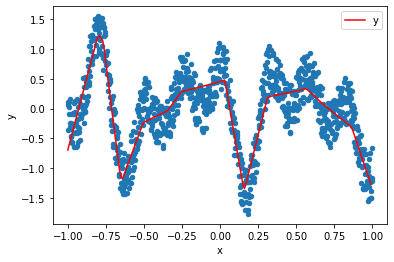

In [53]:
tmp = pd.read_csv('sample.csv')#[["shop.4","tested_positive.4"]]
tmp2 = pd.read_csv('submission.csv') 
import matplotlib.pyplot as plt
ax = tmp.plot(kind='scatter',x="x",y="y") # bar can be replaced by 

tmp2.plot(ax=ax,x="x",y="y",color='red') # bar can be replaced by 
# scatter or line or even left as default
 
plt.show()